# Imports

In [1]:
import pandas as pd
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Optional, Tuple, Union
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from collections import Counter
import logging
import re
import os
import json
import scipy.stats as stats
from tabulate import tabulate

# Quantitative Analysis: Correlations and Predictive Models
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.preprocessing import LabelEncoder

# Cluster Analysis / Segmentation
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# --- Factor Analysis / Principal Component Analysis (PCA) ---
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Classes

In [21]:
class SurveyDataCleaner:
    """
    A class to clean and process survey data related to data privacy and connected devices.
    
    This class handles missing values, standardizes responses, and prepares the data
    for analysis while maintaining data integrity and documenting transformations.
    """
    
    def __init__(self, survey_data: pd.DataFrame, questions_data: Optional[pd.DataFrame] = None):
        """
        Initialize the SurveyDataCleaner with raw survey data and optional questions metadata.
        
        Parameters:
        -----------
        survey_data : pd.DataFrame
            Raw survey data with responses
        questions_data : pd.DataFrame, optional
            Metadata about survey questions (id and descriptions)
        """
        # Make deep copies to prevent modifying original data
        self.raw_data = survey_data.copy(deep=True)
        self.cleaned_data = survey_data.copy(deep=True)
        
        # Standardize column names - ensure all are strings
        self.raw_data.columns = [str(col) for col in self.raw_data.columns]
        self.cleaned_data.columns = [str(col) for col in self.cleaned_data.columns]
        
        self.questions = questions_data
        self.missing_data_report = None
        self.transformation_log = []
        
        # Validate inputs
        self._validate_input_data()
        
    def _validate_input_data(self) -> None:
        """Validate the input data for expected structure."""
        try:
            if not isinstance(self.raw_data, pd.DataFrame):
                raise TypeError("Survey data must be a pandas DataFrame")
            
            if self.questions is not None and not isinstance(self.questions, pd.DataFrame):
                raise TypeError("Questions data must be a pandas DataFrame")
                
            logger.info(f"Data validated: {self.raw_data.shape[0]} responses with {self.raw_data.shape[1]} columns")
        except Exception as e:
            logger.error(f"Data validation failed: {str(e)}")
            raise
            
    def explore_data(self) -> Dict:
        """
        Perform initial data exploration and return summary statistics.
        
        Returns:
        --------
        Dict
            Dictionary containing summary statistics and data quality metrics
        """
        try:
            # Count responses
            n_responses = self.raw_data.shape[0]
            
            # Missing value analysis
            missing_values = self.raw_data.isnull().sum()
            missing_percentage = (missing_values / n_responses) * 100
            
            # Data types
            data_types = self.raw_data.dtypes
            
            # Create summary report
            summary = {
                "n_responses": n_responses,
                "missing_values": missing_values,
                "missing_percentage": missing_percentage,
                "data_types": data_types
            }
            
            logger.info(f"Data exploration completed: {n_responses} responses analyzed")
            return summary
        except Exception as e:
            logger.error(f"Data exploration failed: {str(e)}")
            raise
            
    def analyze_missing_values(self, visualization: bool = True) -> pd.DataFrame:
        """
        Analyze patterns of missing values and create a detailed report.
        
        Parameters:
        -----------
        visualization : bool, default=True
            Whether to generate visualizations of missing data patterns
            
        Returns:
        --------
        pd.DataFrame
            DataFrame containing missing value statistics
        """
        try:
            n_responses = self.raw_data.shape[0]
            
            # Calculate missing value statistics
            missing = self.raw_data.isnull().sum()
            missing_percent = (missing / n_responses) * 100
            
            # Create report DataFrame
            self.missing_data_report = pd.DataFrame({
                'Column': missing.index,
                'Missing_Count': missing.values,
                'Missing_Percent': missing_percent.values
            }).sort_values('Missing_Percent', ascending=False)
            
            # Add question descriptions if available
            if self.questions is not None:
                # Create a mapping of question numbers to descriptions
                question_map = {}
                for _, row in self.questions.iterrows():
                    question_map[str(row['quest_id'])] = row['question_descr']
                
                # Add descriptions to the report
                self.missing_data_report['Description'] = self.missing_data_report['Column'].apply(
                    lambda x: question_map.get(x, "No description available") 
                    if isinstance(x, str) and x.isdigit() else "No description available"
                )
            
            # Visualize if requested
            if visualization:
                plt.figure(figsize=(12, 8))
                sns.heatmap(self.raw_data.isnull(), cbar=False, yticklabels=False)
                plt.title('Missing Values Heatmap')
                plt.tight_layout()
                plt.show()
                
                # Plot top 10 columns with missing values
                top_missing = self.missing_data_report.head(10)
                plt.figure(figsize=(10, 6))
                sns.barplot(x='Column', y='Missing_Percent', data=top_missing)
                plt.xticks(rotation=45, ha='right')
                plt.title('Top 10 Columns with Missing Values')
                plt.tight_layout()
                plt.show()
            
            logger.info(f"Missing value analysis completed: {self.missing_data_report.shape[0]} columns analyzed")
            return self.missing_data_report
        
        except Exception as e:
            logger.error(f"Missing value analysis failed: {str(e)}")
            raise
    
    def handle_missing_values(self) -> None:
        """
        Apply appropriate missing value strategies based on data analysis.
        
        This method makes decisions about each column based on:
        1. Whether the missing values are structural (e.g., conditional questions)
        2. The percentage of missing values
        3. The data type and meaning of the column
        """
        try:
            if self.missing_data_report is None:
                logger.info("Running missing value analysis first")
                self.analyze_missing_values(visualization=False)
                
            # Keep track of transformations
            transformations = []
            
            # Handle each column based on question context and missing data percentage
            for _, row in self.missing_data_report.iterrows():
                column = row['Column']
                missing_pct = row['Missing_Percent']
                
                # Skip timestamp column
                if column == 'Timestamp':
                    continue

                # 1. Handle conditional questions (structural missing values)
                if column == '6':  # "Why don't you use connected devices?" (only for non-users)
                    # Fill with "Not Applicable" for users who answered "Yes" to question 5
                    self.cleaned_data['5'] = self.cleaned_data['5'].astype(str)
                    mask_users = (self.cleaned_data['5'].str.lower().isin(['yes', 'oui', 'ja', 'sí', 'si'])) & (self.cleaned_data[column].isnull())
                    self.cleaned_data.loc[mask_users, column] = "Not Applicable"
                    transformations.append(f"Column {column}: Filled structural NaNs with 'Not Applicable' for users")
                    
                    # STRICT ENFORCEMENT: Also set "Not Applicable" for ALL users regardless of existing value
                    mask_all_users = self.cleaned_data['5'].str.lower().isin(['yes', 'oui', 'ja', 'sí', 'si'])
                    self.cleaned_data.loc[mask_all_users, column] = "Not Applicable"
                    transformations.append(f"Column {column}: Strictly enforced 'Not Applicable' for all users")
                
                    # Fill with "No specific reason" for non-users who didn't specify a reason
                    mask_nonusers_no_reason = (self.cleaned_data['5'].str.lower().isin(['no', 'non', 'nein'])) & (self.cleaned_data[column].isnull())
                    self.cleaned_data.loc[mask_nonusers_no_reason, column] = "No specific reason"
                    transformations.append(f"Column {column}: Filled NaNs with 'No specific reason' for non-users")
                
                elif column in ['7', '8', '9', '10']:  # Questions only for users
                    # STRICT ENFORCEMENT: Set "Not Applicable" for ALL non-users regardless of existing value
                    self.cleaned_data['5'] = self.cleaned_data['5'].astype(str)
                    mask_all_nonusers = self.cleaned_data['5'].str.lower().isin(['no', 'non', 'nein'])
                    self.cleaned_data.loc[mask_all_nonusers, column] = "Not Applicable"
                    transformations.append(f"Column {column}: Strictly enforced 'Not Applicable' for all non-users")
                    
                    # Fill with "Not Applicable" for non-users
                    self.cleaned_data['5'] = self.cleaned_data['5'].astype(str)
                    mask = (self.cleaned_data['5'].str.lower().isin(['no', 'non', 'nein'])) & (self.cleaned_data[column].isnull())
                    self.cleaned_data.loc[mask, column] = "Not Applicable"
                    transformations.append(f"Column {column}: Filled structural NaNs with 'Not Applicable' for non-users")
                
                elif column == '18':  # "Why not share data?" (only for those who answered "No" to Q17)
                    # Ensure string type
                    self.cleaned_data['17'] = self.cleaned_data['17'].astype(str)
                    
                    # STRICT ENFORCEMENT: Set "Not Applicable" for ALL willing sharers regardless of existing value
                    mask_all_willing = self.cleaned_data['17'].str.lower().isin(['yes', 'oui', 'ja', 'sí', 'si'])
                    self.cleaned_data.loc[mask_all_willing, column] = "Not Applicable"
                    transformations.append(f"Column {column}: Strictly enforced 'Not Applicable' for all willing sharers")
                    
                    # Fill with "No specific reason" for unwilling sharers who didn't specify a reason
                    mask_unwilling_no_reason = (self.cleaned_data['17'].str.lower().isin(['no', 'non', 'nein'])) & (self.cleaned_data[column].isnull())
                    self.cleaned_data.loc[mask_unwilling_no_reason, column] = "No specific reason"
                    transformations.append(f"Column {column}: Filled NaNs with 'No specific reason' for unwilling sharers")
                
                # 2. Handle free-text responses (e.g., "other thoughts")
                elif column == '21' and missing_pct > 0:  # Other thoughts on data privacy
                    self.cleaned_data.loc[:, column] = self.cleaned_data[column].fillna("No comment")
                    transformations.append(f"Column {column}: Filled NaNs with 'No comment'")
                
                # 3. Handle email column - replace NaN with indication of no contact desired
                elif column == '26':  # Email column
                    self.cleaned_data.loc[:, column] = self.cleaned_data[column].fillna("No updates requested")
                    transformations.append(f"Column {column}: Filled NaNs with 'No updates requested'")
                
                # 4. Handle high percentage of missing values in non-conditional questions
                elif missing_pct > 50 and column not in ['6', '7', '8', '9', '10', '18', '21', '26']:
                    logger.warning(f"Column {column} has {missing_pct:.1f}% missing values - consider dropping")
                    transformations.append(f"Column {column}: High percentage of missing values ({missing_pct:.1f}%)")
                
                # 5. Handle numeric rating scales (likely 1-5 scale)
                elif column in ['1', '2', '3', '4', '12', '13', '15', '16', '20'] and missing_pct > 0:
                    # Convert to numeric first
                    self.cleaned_data[column] = pd.to_numeric(self.cleaned_data[column], errors='coerce')
                    
                    # For numeric ratings, impute with median
                    if pd.api.types.is_numeric_dtype(self.cleaned_data[column]):
                        median_value = self.cleaned_data[column].median()
                        self.cleaned_data[column] = self.cleaned_data[column].fillna(median_value)
                        transformations.append(f"Column {column}: Imputed {missing_pct:.1f}% NaNs with median ({median_value})")
            
            # Log all transformations
            for t in transformations:
                logger.info(t)
                self.transformation_log.append(t)
                
            logger.info(f"Missing value handling completed: {len(transformations)} transformations applied")
        
        except Exception as e:
            logger.error(f"Missing value handling failed: {str(e)}")
            raise

    def create_derived_features(self) -> None:
        """
        Create useful derived features for analysis.
        """
        try:
            # 1. Create user type column (user vs non-user of connected devices)
            if '5' in self.cleaned_data.columns:
                # Convert to string for consistent processing
                self.cleaned_data['5'] = self.cleaned_data['5'].astype(str).str.strip()
                
                # Define comprehensive lists of "Yes" and "No" variants in multiple languages
                yes_variants = ['yes', 'y', 'oui', 'ja', 'si', 'sí', 'Yes', 'Y', 'Oui', 'Ja', 'Si', 'Sí', 'YES', 'OUI', 'JA', 'SI', 'SÍ']
                no_variants = ['no', 'n', 'non', 'nein', 'No', 'N', 'Non', 'Nein', 'NO', 'NON', 'NEIN']
                
                # Set user types
                self.cleaned_data['user_type'] = 'Unknown'  # Default value
                self.cleaned_data.loc[self.cleaned_data['5'].isin(yes_variants), 'user_type'] = 'User'
                self.cleaned_data.loc[self.cleaned_data['5'].isin(no_variants), 'user_type'] = 'Non-user'
                
                # For case-insensitive matching, handle separately
                for idx, value in self.cleaned_data.loc[self.cleaned_data['user_type'] == 'Unknown', '5'].items():
                    if value.lower() in [y.lower() for y in yes_variants]:
                        self.cleaned_data.loc[idx, 'user_type'] = 'User'
                    elif value.lower() in [n.lower() for n in no_variants]:
                        self.cleaned_data.loc[idx, 'user_type'] = 'Non-user'
                
                # Log distribution 
                user_counts = self.cleaned_data['user_type'].value_counts()
                logger.info(f"Created derived feature: user_type with distribution: {user_counts.to_dict()}")
            else:
                logger.error(f"Column '5' not found. Available columns: {self.cleaned_data.columns.tolist()}")
                raise KeyError("Column '5' not found in dataset")
                
            # 2. Create language group feature based on responses in raw data
            self.cleaned_data['lang_group'] = 'English'  # Default
            
            language_counts = {'French': 0, 'German': 0, 'Spanish': 0, 'English': 0}
            
            # Use raw data to detect language before standardization
            for idx, row in self.raw_data.iterrows():
                french_found = False
                german_found = False
                spanish_found = False
                
                # Check yes/no columns
                for col in ['11']:
                    if col in self.raw_data.columns and pd.notna(row.get(col)):
                        val = str(row.get(col)).lower().strip()
                        
                        # Check French indicators
                        if val in ['oui', 'non'] or any(keyword in val for keyword in ['pas', 'quelque', 'très']):
                            self.cleaned_data.loc[idx, 'lang_group'] = 'French'
                            language_counts['French'] += 1
                            french_found = True
                            break
                        
                        # Check German indicators
                        elif val in ['ja', 'nein'] or any(keyword in val for keyword in ['nicht', 'etwas', 'sehr']):
                            self.cleaned_data.loc[idx, 'lang_group'] = 'German'
                            language_counts['German'] += 1
                            german_found = True
                            break
                        
                        # Check Spanish indicators (using accented sí)
                        elif val == 'sí' or any(keyword in val for keyword in ['muy', 'algo', 'los', 'igualmente']):
                            self.cleaned_data.loc[idx, 'lang_group'] = 'Spanish'
                            language_counts['Spanish'] += 1
                            spanish_found = True
                            break
                        
                        elif val == 'no' and any(keyword in val for keyword in ['beneficio', 'privacidad', 'preocupaciones', 'igualmente']):
                            self.cleaned_data.loc[idx, 'lang_group'] = 'Spanish'
                            language_counts['Spanish'] += 1
                            break
                
                # Count English responses
                if not (french_found or german_found or spanish_found):
                    language_counts['English'] += 1
            
            logger.info(f"Language detection results: {language_counts}")
            logger.info("Created derived feature: lang_group")

            # 3. Create privacy concern score and level
            privacy_columns = ['1', '2', '3', '4']
            if all(col in self.cleaned_data.columns for col in privacy_columns):
                # Convert all columns to numeric
                for col in privacy_columns:
                    # First try standard conversion
                    self.cleaned_data[col] = pd.to_numeric(self.cleaned_data[col], errors='coerce')
                
                # Calculate privacy concern score only for rows with complete data
                valid_rows = self.cleaned_data[privacy_columns].notna().all(axis=1)
                
                if valid_rows.sum() > 0:  # If we have valid rows
                    # Calculate score
                    self.cleaned_data.loc[valid_rows, 'privacy_concern_score'] = (
                        (6 - self.cleaned_data.loc[valid_rows, '1']) +  # Invert trust score
                        (6 - self.cleaned_data.loc[valid_rows, '2']) +  # Invert control score
                        self.cleaned_data.loc[valid_rows, '3'] +        # No inversion
                        self.cleaned_data.loc[valid_rows, '4']          # No inversion
                    ) / 4
                    
                    # Create categorical levels
                    bins = [0, 2, 3, 4, 5.1]  # Upper bound slightly above 5 to include exact 5
                    labels = ['Low', 'Moderate', 'High', 'Very High']
                    
                    self.cleaned_data['privacy_concern_level'] = pd.cut(
                        self.cleaned_data['privacy_concern_score'],
                        bins=bins,
                        labels=labels,
                        include_lowest=True
                    )
                    
                    logger.info(f"Created derived features: privacy_concern_score and privacy_concern_level for {valid_rows.sum()} valid responses")
            
            # 4. Create technology trust score (Q13)
            if '13' in self.cleaned_data.columns:
                # Convert to numeric
                self.cleaned_data['13'] = pd.to_numeric(self.cleaned_data['13'], errors='coerce')
                self.cleaned_data['tech_trust_score'] = self.cleaned_data['13']
                logger.info("Created derived feature: tech_trust_score")
            
            # 5. Create control preference score
            control_columns = ['3', '12', '15']
            if all(col in self.cleaned_data.columns for col in control_columns):
                # Convert to numeric
                for col in control_columns:
                    self.cleaned_data[col] = pd.to_numeric(self.cleaned_data[col], errors='coerce')
                
                # Calculate score for valid rows only
                valid_rows = self.cleaned_data[control_columns].notna().all(axis=1)
                
                if valid_rows.sum() > 0:
                    self.cleaned_data.loc[valid_rows, 'control_preference_score'] = (
                        self.cleaned_data.loc[valid_rows, '3'] +
                        self.cleaned_data.loc[valid_rows, '12'] +
                        self.cleaned_data.loc[valid_rows, '15']
                    ) / 3
                    
                    logger.info(f"Created derived feature: control_preference_score for {valid_rows.sum()} valid responses")
            
            # 6. Data ownership belief
            if '16' in self.cleaned_data.columns:
                # Convert to numeric
                self.cleaned_data['16'] = pd.to_numeric(self.cleaned_data['16'], errors='coerce')
                valid_rows = self.cleaned_data['16'].notna()
                
                if valid_rows.sum() > 0:
                    # Q16 is reversed: 1 (Strongly agree) to 5 (Strongly disagree)
                    self.cleaned_data.loc[valid_rows, 'data_ownership_belief'] = 6 - self.cleaned_data.loc[valid_rows, '16']
                    logger.info(f"Created derived feature: data_ownership_belief for {valid_rows.sum()} valid responses")
            
            # 7. Response completeness
            structural_nan_cols = ['6', '7', '8', '9', '10', '18']
            non_structural_cols = [col for col in self.cleaned_data.columns if col not in structural_nan_cols]
            
            # Calculate completeness excluding structural NaNs
            total_cols = len(non_structural_cols)
            self.cleaned_data['response_completeness'] = self.cleaned_data[non_structural_cols].apply(
                lambda row: row.notna().sum() / total_cols * 100,
                axis=1
            )
            
            logger.info("Created derived feature: response_completeness")
            
            # Count and log all derived features
            derived_features = ['user_type', 'lang_group', 'privacy_concern_score', 'privacy_concern_level', 
                               'tech_trust_score', 'control_preference_score', 'data_ownership_belief', 
                               'response_completeness']
            actual_derived = [f for f in derived_features if f in self.cleaned_data.columns]
            self.transformation_log.append(f"Created {len(actual_derived)} derived features: {', '.join(actual_derived)}")
            
        except Exception as e:
            logger.error(f"Derived feature creation failed: {str(e)}")
            import traceback
            logger.error(f"Exception details: {traceback.format_exc()}")
            raise

    def standardize_categorical_variables(self) -> None:
        """
        Standardize categorical responses including multi-language options.
        """
        try:
            transformations = []
            
            # 1. Standardize Yes/No questions
            yes_no_columns = ['5', '10', '11', '17']
            
            yes_variants = ['yes', 'Yes', 'YES', 'oui', 'Oui', 'OUI', 'ja', 'Ja', 'JA', 'si', 'Si', 'SI', 'sí', 'Sí', 'SÍ']
            no_variants = ['no', 'No', 'NO', 'non', 'Non', 'NON', 'nein', 'Nein', 'NEIN']
            
            for col in yes_no_columns:
                if col in self.cleaned_data.columns:
                    # Convert to string
                    self.cleaned_data[col] = self.cleaned_data[col].astype(str)
                    
                    # Apply standardization - direct replacement
                    for idx, value in self.cleaned_data[col].items():
                        if value.lower() in [y.lower() for y in yes_variants]:
                            self.cleaned_data.loc[idx, col] = 'Yes'
                        elif value.lower() in [n.lower() for n in no_variants]:
                            self.cleaned_data.loc[idx, col] = 'No'
                    
                    transformations.append(f"Column {col}: Standardized Yes/No variations")
            
            # 2. Standardize Q6 - Why non-users don't use devices
            if '6' in self.cleaned_data.columns:
                self.cleaned_data['6'] = self.cleaned_data['6'].astype(str)
                
                reason_mapping = {
                    # Privacy-related reasons
                    'confidentialité': 'Privacy',
                    'datenschutz': 'Privacy',
                    'privacidad': 'Privacy',
                    
                    # Cost-related reasons
                    'coût': 'Cost',
                    'kosten': 'Cost',
                    'coste': 'Cost',
                    'precio': 'Cost',
                    
                    # Complexity-related reasons
                    'complexité': 'Complexity',
                    'komplexität': 'Complexity',
                    'complejidad': 'Complexity',
                    
                    # No need reasons
                    'pas besoin': 'No need',
                    'kein bedarf': 'No need',
                    'no los necesito': 'No need',
                    'no need': 'No need',
                    'no los he ocupado': 'No need',

                    # No specific reason
                    'jamais pensé': 'No specific reason',
                    
                    # Distraction
                    'distracting': 'Too distracting',
                    'distract': 'Too distracting'
                }
                
                # Apply standardization
                for idx, value in self.cleaned_data['6'].items():
                    # Skip Not Applicable entries
                    if value == 'Not Applicable':
                        continue
                        
                    value_lower = value.lower()
                    
                    # Handle multiple reasons with commas
                    if ',' in value_lower:
                        reasons = []
                        for part in value_lower.split(','):
                            part = part.strip()
                            for key, replacement in reason_mapping.items():
                                if key in part:
                                    reasons.append(replacement)
                                    break
                        if reasons:
                            self.cleaned_data.loc[idx, '6'] = ', '.join(sorted(set(reasons)))
                            continue
                    
                    # Handle single reasons
                    matched = False
                    for key, replacement in reason_mapping.items():
                        if key in value_lower:
                            self.cleaned_data.loc[idx, '6'] = replacement
                            matched = True
                            break
                    
                    # Default to "No specific reason" if no match found
                    if not matched and value != "No specific reason":
                        self.cleaned_data.loc[idx, '6'] = "No specific reason"
                
                transformations.append("Column 6: Enhanced standardization of device non-usage reasons")
            
            # 3. Q7 - Standardize wearable devices/brands
            if '7' in self.cleaned_data.columns:
                self.cleaned_data['7'] = self.cleaned_data['7'].astype(str)
                
                # Create brand-based groupings
                brand_mapping = {
                    # Apple ecosystem
                    'apple': 'Apple',
                    'iphone': 'Apple',
                    'watch': 'Apple',  # When combined with "apple"
                    'santé': 'Apple',  # Apple Health in French
                    'health': 'Apple', # Apple Health in English
                    
                    # Garmin
                    'garmin': 'Garmin',
                    'garnin': 'Garmin',  # Typo
                    
                    # Fitbit
                    'fitbit': 'Fitbit',
                    
                    # Samsung
                    'samsung': 'Samsung',
                    'galaxy': 'Samsung',
                    
                    # Xiaomi
                    'xiaomi': 'Xiaomi',
                    'redmi': 'Xiaomi',
                    
                    # Other trackers
                    'strava': 'Strava',
                    'polar': 'Polar',
                    'coros': 'Coros',
                    'oura': 'Oura',
                    'whoop': 'Whoop',
                    'huawei': 'Huawei',
                    'withings': 'Withings',
                    'suunto': 'Suunto',
                    
                    # Health apps
                    'flo': 'Health Apps',
                    'clue': 'Health Apps',
                    'clover': 'Health Apps',
                    'menstrual': 'Health Apps',
                    'cycle': 'Health Apps',
                    'migraine': 'Health Apps',
                    'pill': 'Health Apps',
                    'nike run': 'Health Apps',
                    'runmeter': 'Health Apps',
                    'running': 'Health Apps',
                    'scale': 'Health Apps',
                    'balance': 'Health Apps',
                    'bácula': 'Health Apps'
                }
                
                # Apply standardization
                for idx, value in self.cleaned_data['7'].items():
                    # Skip Not Applicable
                    if value == 'Not Applicable':
                        continue
                    
                    value_lower = value.lower()
                    
                    if value_lower in ['oui', 'yes', 'si', 'sí']:
                        self.cleaned_data.loc[idx, '7'] = "Unspecified device"
                        continue
                    
                    # Extract all brands mentioned
                    brands = set()
                    
                    # Check for multiple devices separated by commas, plus signs, or slashes
                    device_parts = re.split(r'[,+/&]', value_lower)
                    
                    for part in device_parts:
                        part = part.strip()
                        found = False
                        for key, brand in brand_mapping.items():
                            if key in part:
                                brands.add(brand)
                                found = True
                        
                        # Special case for Apple Watch (needs both terms)
                        if 'apple' in part and 'watch' in part:
                            brands.add('Apple')
                    
                    # Convert to standardized string
                    if brands:
                        self.cleaned_data.loc[idx, '7'] = ", ".join(sorted(brands))
                    else:
                        self.cleaned_data.loc[idx, '7'] = "Other device"
                
                transformations.append("Column 7: Standardized device/brand names")

            # 4. Q8 - Health-privacy balance (improved to capture all responses)
            if '8' in self.cleaned_data.columns:
                self.cleaned_data['8'] = self.cleaned_data['8'].astype(str)

                # Define standardized categories
                health_clearly_outweighs = 'Health benefits clearly outweigh privacy concerns'
                health_somewhat_outweighs = 'Health benefits somewhat outweigh privacy concerns'
                equally_concerned = 'Equally concerned about both'
                privacy_somewhat_outweighs = 'Privacy concerns somewhat outweigh health benefits'
                privacy_clearly_outweighs = 'Privacy concerns clearly outweigh health benefits'

                # Use a function with explicit, ordered logic for reliable mapping
                def map_balance(value):
                    if pd.isna(value) or value in ['Not Applicable', 'nan']:
                        return value

                    val_lower = value.lower()

                    # Most specific phrases first to avoid incorrect partial matches
                    if 'préoccupations de confidentialité l’emportent largement' in val_lower or \
                       'las preocupaciones por la privacidad superan ampliamente' in val_lower or \
                       'privacy concerns clearly' in val_lower:
                        return privacy_clearly_outweighs
                    
                    if 'préoccupations de confidentialité l’emportent légèrement' in val_lower or \
                       'datenschutzbedenken überwiegen etwas' in val_lower or \
                       'privacy concerns somewhat' in val_lower:
                        return privacy_somewhat_outweighs

                    if 'bénéfices pour la santé l’emportent largement' in val_lower or \
                       'gesundheitlicher nutzen überwiegt deutlich' in val_lower or \
                       'el beneficio para la salud supera ampliamente' in val_lower or \
                       'health benefits clearly' in val_lower:
                        return health_clearly_outweighs

                    if 'bénéfices pour la santé l’emportent légèrement' in val_lower or \
                       'gesundheitlicher nutzen überwiegt etwas' in val_lower or \
                       'el beneficio para la salud es ligeramente mayor' in val_lower or \
                       'health benefits somewhat' in val_lower:
                        return health_somewhat_outweighs

                    if 'autant préoccupé' in val_lower or \
                       'gleich wichtig' in val_lower or \
                       'igualmente importantes' in val_lower or \
                       'equally concerned' in val_lower:
                        return equally_concerned
                    
                    # If no match, log a warning and return the original value
                    logger.warning(f"Could not standardize Q8 response: {value}")
                    return value

                self.cleaned_data['8'] = self.cleaned_data['8'].apply(map_balance)
                transformations.append("Column 8: Enhanced standardization of health-privacy balance responses")
            
            # 5. Q9 - Device usage frequency
            if '9' in self.cleaned_data.columns:
                self.cleaned_data['9'] = self.cleaned_data['9'].astype(str)
                
                frequency_mapping = {
                    # Daily
                    'quotidiennement': 'Daily',
                    'täglich': 'Daily',
                    'a diario': 'Daily',
                    'tous les jours': 'Daily',
                    'daily': 'Daily',
                    
                    # Weekly
                    'hebdomadaire': 'Weekly',
                    'wöchentlich': 'Weekly',
                    'semanal': 'Weekly',
                    'weekly': 'Weekly',
                    
                    # Monthly
                    'mensuellement': 'Monthly',
                    'monatlich': 'Monthly',
                    'mensualmente': 'Monthly',
                    'monthly': 'Monthly',
                    
                    # Rarely
                    'rarement': 'Rarely',
                    'selten': 'Rarely',
                    'rara vez': 'Rarely',
                    'rarely': 'Rarely',
                    'occasionally': 'Rarely',
                    
                    # Annually
                    'annuellement': 'Annually',
                    'jährlich': 'Annually',
                    'anualmente': 'Annually', 
                    'annually': 'Annually'
                }
                
                # Apply direct matching
                for idx, value in self.cleaned_data['9'].items():
                    value_lower = value.lower()
                    for key, replacement in frequency_mapping.items():
                        if key in value_lower:
                            self.cleaned_data.loc[idx, '9'] = replacement
                            break
                
                transformations.append("Column 9: Standardized device usage frequency")
            
            # 6. Q10 - Privacy policy reading
            if '10' in self.cleaned_data.columns:
                self.cleaned_data['10'] = self.cleaned_data['10'].astype(str)
                
                # "Skimmed" responses in different languages
                skimmed_variants = [
                    'parcouru rapidement', 'survol', 'juste un coup d\'oeil',
                    'überflogen', 'kurz angesehen',
                    'revisado por encima', 'eché un vistazo',
                    'skimmed', 'glanced', 'briefly looked'
                ]
                
                # Apply standardization
                for idx, value in self.cleaned_data['10'].items():
                    if value not in ['Yes', 'No']:  # Skip already standardized values
                        value_lower = value.lower()
                        if any(variant in value_lower for variant in skimmed_variants):
                            self.cleaned_data.loc[idx, '10'] = 'Skimmed'
                
                transformations.append("Column 10: Standardized privacy policy reading responses")
            
            # 7. Q11 - Awareness of decentralized approaches
            if '11' in self.cleaned_data.columns:
                self.cleaned_data['11'] = self.cleaned_data['11'].astype(str)
                
                awareness_mapping = {
                    # Very familiar
                    'très familier': 'Yes, very familiar',
                    'sehr vertraut': 'Yes, very familiar',
                    'muy familiarizado': 'Yes, very familiar',
                    
                    # Somewhat familiar
                    'quelque peu familier': 'Yes, somewhat familiar',
                    'etwas vertraut': 'Yes, somewhat familiar',
                    'algo familiarizado': 'Yes, somewhat familiar',
                    
                    # Not familiar
                    'pas du tout': 'No, not familiar',
                    'nicht vertraut': 'No, not familiar',
                    'no los conocía': 'No, not familiar'
                }
                
                # Apply direct matching
                for idx, value in self.cleaned_data['11'].items():
                    if value not in ['Yes', 'No']:  # Skip already standardized values
                        value_lower = value.lower()
                        for key, replacement in awareness_mapping.items():
                            if key in value_lower:
                                self.cleaned_data.loc[idx, '11'] = replacement
                                break
                
                transformations.append("Column 11: Standardized awareness responses")
            
            # 8. Q14 - Concerns about adopting new data management approaches (improved)
            if '14' in self.cleaned_data.columns:
                self.cleaned_data['14'] = self.cleaned_data['14'].astype(str)
                
                # Define standard concern categories
                standard_concerns = [
                    'Complexity/difficulty of use',
                    'Uncertain security/reliability',
                    'Cost of implementation',
                    'Integration with existing devices',
                    'Time required to manage my data'
                ]
                
                # More comprehensive mapping
                concerns_mapping = {
                    # Complexity
                    'complexité': 'Complexity/difficulty of use',
                    'difficulté': 'Complexity/difficulty of use', 
                    'komplexität': 'Complexity/difficulty of use',
                    'schwierige': 'Complexity/difficulty of use',
                    'complejidad': 'Complexity/difficulty of use',
                    'difícil': 'Complexity/difficulty of use',
                    'complexity': 'Complexity/difficulty of use',
                    'difficult': 'Complexity/difficulty of use',
                    
                    # Security/reliability
                    'sécurité': 'Uncertain security/reliability',
                    'fiabilité': 'Uncertain security/reliability',
                    'sicherheit': 'Uncertain security/reliability',
                    'zuverlässigkeit': 'Uncertain security/reliability',
                    'seguridad': 'Uncertain security/reliability',
                    'fiabilidad': 'Uncertain security/reliability',
                    'security': 'Uncertain security/reliability',
                    'reliability': 'Uncertain security/reliability',
                    
                    # Cost
                    'coût': 'Cost of implementation',
                    'kosten': 'Cost of implementation',
                    'coste': 'Cost of implementation',
                    'cost': 'Cost of implementation',
                    
                    # Integration
                    'intégration': 'Integration with existing devices',
                    'integration': 'Integration with existing devices',
                    'integración': 'Integration with existing devices',
                    
                    # Time
                    'temps': 'Time required to manage my data',
                    'zeit': 'Time required to manage my data',
                    'tiempo': 'Time required to manage my data',
                    'time': 'Time required to manage my data',
                }
                
                # Direct matching for exact standard concerns
                for concern in standard_concerns:
                    concerns_mapping[concern.lower()] = concern
                
                # Apply standardization
                for idx, value in self.cleaned_data['14'].items():
                    # Skip Not Applicable
                    if value == 'Not Applicable':
                        continue
                        
                    value_lower = value.lower()
                    
                    # Special case for irrelevant responses
                    if 'no suelo utilizar' in value_lower:
                        self.cleaned_data.loc[idx, '14'] = "Not Applicable"
                        continue
                    
                    # Handle responses with multiple concerns (comma separated)
                    if ',' in value:
                        # Already standardized, keep it
                        if all(concern in standard_concerns for concern in value.split(', ')):
                            continue
                    
                    # Detect all concerns mentioned in the response
                    detected_concerns = []
                    for key, concern in concerns_mapping.items():
                        if key in value_lower and concern not in detected_concerns:
                            detected_concerns.append(concern)
                    
                    # Update with standardized concerns
                    if detected_concerns:
                        self.cleaned_data.loc[idx, '14'] = ', '.join(detected_concerns)
                
                transformations.append("Column 14: Enhanced standardization of concerns")
            
            # 9. Q18 - Why not share data (improved)
            if '18' in self.cleaned_data.columns:
                self.cleaned_data['18'] = self.cleaned_data['18'].astype(str)
                
                # Define standard concerns
                standard_concerns = [
                    'Privacy loss',
                    'Breach risk',
                    'No control',
                    'Misuse',
                    'No specific reason',
                    'Not Applicable'
                ]
                
                sharing_concerns_mapping = {
                    # Privacy loss
                    'perte de confidentialité': 'Privacy loss',
                    'datenschutzverlust': 'Privacy loss',
                    'pérdida de privacidad': 'Privacy loss',
                    'privacy loss': 'Privacy loss',
                    'privacy': 'Privacy loss',
                    'confidentialité': 'Privacy loss',
                    'privacidad': 'Privacy loss',
                    
                    # Breach risk
                    'fuite de données': 'Breach risk',
                    'datenleck': 'Breach risk',
                    'filtración de datos': 'Breach risk',
                    'breach': 'Breach risk',
                    'leak': 'Breach risk',
                    'fuite': 'Breach risk',
                    
                    # No control
                    'manque de contrôle': 'No control',
                    'keine kontrolle': 'No control',
                    'falta de control': 'No control',
                    'no control': 'No control',
                    'contrôle': 'No control',
                    'control': 'No control',
                    
                    # Misuse
                    'mauvaise utilisation': 'Misuse',
                    'missbrauch': 'Misuse',
                    'mal uso': 'Misuse',
                    'misuse': 'Misuse',
                    'utilisation': 'Misuse'
                }
                
                # Direct matching for exact standard concerns
                for concern in standard_concerns:
                    sharing_concerns_mapping[concern.lower()] = concern
                
                # Apply standardization
                for idx, value in self.cleaned_data['18'].items():
                    # Skip Not Applicable
                    if value in ['Not Applicable', 'No specific reason']:
                        continue
                        
                    value_lower = value.lower()
                    
                    # Special case for specific Spanish response
                    if 'si los usara' in value_lower:
                        self.cleaned_data.loc[idx, '18'] = 'Not Applicable'
                        continue
                    
                    # Special case for "not interested"
                    if 'm intéresse pas' in value_lower:
                        self.cleaned_data.loc[idx, '18'] = 'No specific reason'
                        continue
                        
                    # Handle responses with multiple concerns (comma separated)
                    if ',' in value:
                        # Already standardized, keep it
                        if all(concern in standard_concerns for concern in value.split(', ')):
                            continue
                    
                    # Detect all concerns
                    detected_concerns = []
                    for key, concern in sharing_concerns_mapping.items():
                        if key in value_lower and concern not in detected_concerns:
                            detected_concerns.append(concern)
                    
                    # Update with standardized concerns
                    if detected_concerns:
                        self.cleaned_data.loc[idx, '18'] = ', '.join(detected_concerns)
                
                transformations.append("Column 18: Enhanced standardization of data sharing concerns")
            
            # 10. Q19 - Responsibility for ethical data use (improved)
            if '19' in self.cleaned_data.columns:
                self.cleaned_data['19'] = self.cleaned_data['19'].astype(str)
                
                # Define standard options
                std_individual = 'Individual users (my data my responsibility)'
                std_manufacturers = 'Device manufacturers/companies (Garmin, Apple, Google, etc.)'
                std_government = 'Government regulators (US, China, EU, etc.)'
                std_shared = 'Shared responsibility'
                std_unknown = 'Don\'t know'
                
                responsibility_mapping = {
                    # Individual users
                    'utilisateurs individuels': std_individual,
                    'einzelne nutzer': std_individual,
                    'usuarios individuales': std_individual,
                    'my data my responsa': std_individual,
                    'individual users': std_individual,
                    'individual': std_individual,
                    'ma responsabilité': std_individual,
                    'my responsibility': std_individual,
                    
                    # Device manufacturers
                    'fabricants': std_manufacturers,
                    'gerätehersteller': std_manufacturers,
                    'fabricantes': std_manufacturers,
                    'manufacturers': std_manufacturers,
                    'companies': std_manufacturers,
                    'apple': std_manufacturers,
                    'google': std_manufacturers,
                    'garmin': std_manufacturers,
                    'entreprises': std_manufacturers,
                    
                    # Government regulators
                    'régulateurs': std_government,
                    'staatliche': std_government,
                    'organismos gubernamentales': std_government,
                    'government': std_government,
                    'état': std_government,
                    'estado': std_government,
                    'gobierno': std_government,
                    'laws': std_government,
                    'leyes': std_government,
                    'regulators': std_government,
                    
                    # Shared responsibility
                    'responsabilité partagée': std_shared,
                    'geteilte verantwortung': std_shared,
                    'responsabilidad compartida': std_shared,
                    'shared': std_shared,
                    'partagé': std_shared,
                    'compartida': std_shared,
                    
                    # Don't know
                    'ne sais pas': std_unknown,
                    'weiß nicht': std_unknown,
                    'no tengo idea': std_unknown,
                    'no sé': std_unknown,
                    'don\'t know': std_unknown
                }
                
                # Apply standardization
                for idx, value in self.cleaned_data['19'].items():
                    if pd.isna(value):
                        continue
                        
                    value_lower = value.lower()
                    
                    # Skip if already standardized
                    if value in [std_individual, std_manufacturers, std_government, std_shared, std_unknown]:
                        continue
                    
                    matched = False
                    for key, replacement in responsibility_mapping.items():
                        if key in value_lower:
                            self.cleaned_data.loc[idx, '19'] = replacement
                            matched = True
                            break
                    
                    # Fallback to Don't know for unclassified responses
                    if not matched:
                        self.cleaned_data.loc[idx, '19'] = std_unknown
                
                transformations.append("Column 19: Enhanced standardization of responsibility responses")
                
            # 11. Process Q21 (free text comments) - translate and filter
            if '21' in self.cleaned_data.columns:
                self.cleaned_data['21'] = self.cleaned_data['21'].astype(str)
                
                # Define non-informative responses
                non_informative = ['no', 'non', 'nein', 'no comment', 'ninguno', 'ninguna. todo 👍', 'ninguna', 'none', 'aucun', 'keine']
                
                # Translation mapping for key non-English comments
                translation_map = {
                    'c\'est triste, mais je pense que le business des données': 
                    'It\'s sad, but I think the data business (sales, data brokers) makes too much money for companies to imagine a change towards a decentralized system, although that would be ideal. Could government pressure make this happen? Also, I find it frustrating that we can\'t have a kind of "dashboard" tracking all the health data we\'ve shared and be able to control it.',
                
                    'nos données seront toujours de l\'ordre du public': 
                    'Our data will always be in the public domain.',

                    'bitte die ganzen menstruationstracker nicht vergessen': 
                        'Please don\'t forget about menstruation trackers - these are apps used by millions with sensitive health data.',
                    
                    'datenspeicher über google und meta kann ich nicht vertrauen':
                        'I cannot trust data storage by Google and Meta.',
                    
                    'es una buena idea. crear algo asi. para protejer tua datos de salud': 
                        'It\'s a good idea to create something like this to protect your health data.',
                    
                    'il faut que ces futures organisations soient totalement transparentes': 
                        'Future organizations must be completely transparent with users about how their data is stored and used to minimize risk.',
                    
                    'je pars du principe que tout ce que toutes mes données de santé': 
                        'I assume that all my health data recorded on a device no longer belongs to me.',
                    
                    'je pense que la blockchaine est revolutionnaire': 
                        'I think blockchain is revolutionary but few people know about it or are informed.',
                    
                    'je pense que le business des grandes entreprises': 
                        'I think big business and their lobbying have a lot of power and it will be difficult to implement a system to protect everyone\'s data.',
                    
                    'je pense qu\'une solution open source et auto-herbergé': 
                        'I think an open-source and self-hosted solution is better than trusting a third party, for example a tool like Nextcloud.',
                    
                    'könnte es nicht passieren dass mit solcher digitalisierung': 
                        'With such digitalization, could it happen that I won\'t be able to buy a chocolate bar at checkout because my health data isn\'t acceptable? Just one example. As in the past, everyone can make their choice - participate or be excluded. All voluntary. Terrible!',
                    
                    'la première confidentialité est celle des transactions financières': 
                        'The primary confidentiality is that of financial transactions. Hence Monero.',
                    
                    'nos données seront toujours de l\'ordre du public': 
                        'Our data will always be in the public domain.',
                    
                    'para personas con demencia adaptarlos': 
                        'For people with dementia, adapt them in a friendly way to help with medication intake.',
                    
                    'ser discriminado por futuros empleadores': 
                        'Being discriminated against by future employers, insurers, not being eligible for credit.',
                    
                    'siempre tendremos desconfianza de gobiernos': 
                        'We will always distrust governments, health institutions and individuals due to the misuse that could be given to that information.',
                    
                    'travaillant dans l\'it, je sais': 
                        'Working in IT, I already know that many Swiss medical facilities do not respect the requirement to host patient records in Switzerland to save money while hiding it from their patients. So in the end, we are only better served by ourselves.'
                }
                
                # Process each comment
                for idx, value in self.cleaned_data['21'].items():
                    # Convert to lowercase for more accurate matching
                    value_lower = value.lower()
                    
                    # Check for non-informative responses (case-insensitive)
                    if pd.isna(value) or any(ni.lower() in value_lower for ni in non_informative):
                        self.cleaned_data.loc[idx, '21'] = "No comment"
                        continue
                    
                    # Translate known comments
                    matched = False
                    for key_fragment, translation in translation_map.items():
                        if key_fragment in value_lower:
                            self.cleaned_data.loc[idx, '21'] = translation
                            matched = True
                            break
                            
                    # Log if no translation was found for potentially meaningful comments
                    if not matched and len(value) > 20:  # If it's a substantial comment
                        logger.debug(f"No translation found for comment: {value[:50]}...")
                
                transformations.append("Column 21: Enhanced processing of comments with additional translations")
        
            # 12. Q23 - Education level
            if '23' in self.cleaned_data.columns:
                self.cleaned_data['23'] = self.cleaned_data['23'].astype(str)
                
                education_mapping = {
                    # Secondary/High School
                    'secondaire': "Upper Secondary / High School or equivalent",
                    'lycée': "Upper Secondary / High School or equivalent",
                    'sekundarstufe': "Upper Secondary / High School or equivalent",
                    'abitur': "Upper Secondary / High School or equivalent",
                    'secundaria': "Upper Secondary / High School or equivalent",
                    'bachillerato': "Upper Secondary / High School or equivalent",
                    'maturité': "Upper Secondary / High School or equivalent",
                    'high school': "Upper Secondary / High School or equivalent",
                    
                    # Bachelor's degree
                    'bachelor': "Bachelor's degree or equivalent",
                    'licence': "Bachelor's degree or equivalent",
                    'licenciatura': "Bachelor's degree or equivalent",
                    
                    # Master's degree
                    'master': "Master's degree or equivalent",
                    'maestría': "Master's degree or equivalent",
                    
                    # Doctorate
                    'doctorat': "Doctorate (PhD) or higher",
                    'phd': "Doctorate (PhD) or higher",
                    'doctorado': "Doctorate (PhD) or higher",
                    
                    # Vocational
                    'formation professionnelle': "Vocational/Technical training or certificate",
                    'berufsausbildung': "Vocational/Technical training or certificate",
                    'formación profesional': "Vocational/Technical training or certificate",
                    'brêvet': "Vocational/Technical training or certificate",
                    'certificat technique': "Vocational/Technical training or certificate",
                    'technische ausbildung': "Vocational/Technical training or certificate"
                }
                
                # Apply standardization
                for idx, value in self.cleaned_data['23'].items():
                    value_lower = value.lower()
                    for key, replacement in education_mapping.items():
                        if key in value_lower:
                            self.cleaned_data.loc[idx, '23'] = replacement
                            break
                
                transformations.append("Column 23: Standardized education level")
            
            # 13 Q24 - Occupation
            if '24' in self.cleaned_data.columns:
                self.cleaned_data['24'] = self.cleaned_data['24'].astype(str)
                
                occupation_mapping = {
                    # Student
                    'étudiant': 'Student',
                    'student': 'Student',
                    'estudiante': 'Student',
                    
                    # Employed
                    'salarié': 'Employed',
                    'angestellt': 'Employed',
                    'empleado': 'Employed',
                    'employed': 'Employed',
                    'salaried': 'Employed',
                    
                    # Self-employed
                    'indépendant': 'Self-employed',
                    'selbstständig': 'Self-employed',
                    'autónomo': 'Self-employed',
                    'self-employed': 'Self-employed',
                    'freelance': 'Self-employed',
                    
                    # Unemployed
                    'sans emploi': 'Unemployed',
                    'arbeitslos': 'Unemployed',
                    'desempleado': 'Unemployed',
                    'unemployed': 'Unemployed',
                    
                    # Retired
                    'retraité': 'Retired',
                    'rentner': 'Retired',
                    'jubilado': 'Retired',
                    'retired': 'Retired',
                    
                    # Other
                    'stagiaire': 'Employed',
                    'praktikant': 'Employed',
                    'becario': 'Employed',
                    'intern': 'Employed',
                    
                    'ama de casa': 'Unemployed',
                    'hausfrau': 'Unemployed',
                    'foyer': 'Unemployed',
                    'homemaker': 'Unemployed'
                }
                
                # Apply standardization
                for idx, value in self.cleaned_data['24'].items():
                    value_lower = value.lower()
                    for key, replacement in occupation_mapping.items():
                        if key in value_lower:
                            self.cleaned_data.loc[idx, '24'] = replacement
                            break
                
                transformations.append("Column 24: Standardized occupation")
            
            # 14 Q25 - Country names
            if '25' in self.cleaned_data.columns:
                self.cleaned_data['25'] = self.cleaned_data['25'].astype(str)
                
                country_mapping = {
                    'switzerland': 'Switzerland',
                    'suisse': 'Switzerland',
                    'schweiz': 'Switzerland',
                    'suiza': 'Switzerland',
                    'swiss': 'Switzerland',
                    'ch': 'Switzerland',
                    'suiss3': 'Switzerland',
                    
                    'usa': 'United States',
                    'états-unis': 'United States',
                    'estados unidos': 'United States',
                    'united states': 'United States',
                    'us': 'United States',
                    
                    'uk': 'United Kingdom',
                    'royaume-uni': 'United Kingdom',
                    'reino unido': 'United Kingdom',
                    'england': 'United Kingdom',
                    'britain': 'United Kingdom',
                    
                    'germany': 'Germany',
                    'allemagne': 'Germany',
                    'deutschland': 'Germany',
                    'alemania': 'Germany',
                    'de': 'Germany',
                    
                    'france': 'France',
                    'francia': 'France',
                    'frankreich': 'France',
                    'fr': 'France',
                    
                    'österreich': 'Austria',
                    'autriche': 'Austria',
                    'austria': 'Austria',
                    
                    'spain': 'Spain',
                    'espagne': 'Spain',
                    'spanien': 'Spain',
                    'españa': 'Spain',
                    'es': 'Spain',
                    
                    'méxico': 'Mexico',
                    'mexico': 'Mexico',
                    'mexique': 'Mexico',
                    'mexiko': 'Mexico',
                    
                    'serbie': 'Serbia',
                    'serbia': 'Serbia',
                    'serbien': 'Serbia',
                    
                    'danemark': 'Denmark',
                    'denmark': 'Denmark',
                    'dinamarca': 'Denmark',
                    'dänemark': 'Denmark',
                    'dk': 'Denmark'
                }
                
                # Apply standardization
                for idx, value in self.cleaned_data['25'].items():
                    value_lower = value.lower()
                    for key, replacement in country_mapping.items():
                        if key in value_lower:
                            self.cleaned_data.loc[idx, '25'] = replacement
                            break
                
                transformations.append("Column 25: Standardized country names")
             
             # 15. Process Q26 - Email validation
            if '26' in self.cleaned_data.columns:
                self.cleaned_data['26'] = self.cleaned_data['26'].astype(str)
                
                # Email validation function
                def is_valid_email(email_str):
                    return '@' in email_str and '.' in email_str.split('@')[-1]
                
                # Apply validation
                for idx, value in self.cleaned_data['26'].items():
                    if not is_valid_email(value):
                        self.cleaned_data.loc[idx, '26'] = "No updates requested"
                
                transformations.append("Column 26: Validated email addresses")
                # Log transformations
                for t in transformations:
                    logger.info(t)
                    self.transformation_log.append(t)
                    
                logger.info(f"Categorical variable standardization completed: {len(transformations)} transformations applied")
                
        except Exception as e:
            logger.error(f"Categorical variable standardization failed: {str(e)}")
            import traceback
            logger.error(f"Exception details: {traceback.format_exc()}")
            raise

    def convert_data_types(self) -> None:
        """
        Convert columns to appropriate data types for analysis.
        """
        try:
            transformations = []
            
            # 1. Numeric columns (scales 1-5)
            numeric_columns = ['1', '2', '3', '4', '12', '13', '15', '16', '20']
            for col in numeric_columns:
                if col in self.cleaned_data.columns:
                    try:
                        # Convert to numeric, but log if already converted earlier
                        if not pd.api.types.is_numeric_dtype(self.cleaned_data[col]):
                            self.cleaned_data[col] = pd.to_numeric(self.cleaned_data[col], errors='coerce')
                            transformations.append(f"Column {col}: Converted to numeric")
                    except Exception as e:
                        logger.warning(f"Column {col}: Failed to convert to numeric - {str(e)}")
            
            # 2. Keep timestamp as datetime
            if 'Timestamp' in self.cleaned_data.columns:
                if not pd.api.types.is_datetime64_dtype(self.cleaned_data['Timestamp']):
                    self.cleaned_data['Timestamp'] = pd.to_datetime(self.cleaned_data['Timestamp'], errors='coerce')
                    transformations.append("Column Timestamp: Converted to datetime")
            
            # 3. Convert categorical columns to category type (more memory efficient)
            categorical_columns = ['5', '6', '7', '8', '9', '10', '11', '17', '18', '19', '22', '23', '24', '25', 'user_type', 'lang_group']
            for col in categorical_columns:
                if col in self.cleaned_data.columns and not pd.api.types.is_categorical_dtype(self.cleaned_data[col]):
                    self.cleaned_data[col] = self.cleaned_data[col].astype('category')
                    transformations.append(f"Column {col}: Converted to category dtype")
            
            # Log transformations
            for t in transformations:
                logger.info(t)
                self.transformation_log.append(t)
                
            logger.info(f"Data type conversion completed: {len(transformations)} transformations applied")
            
        except Exception as e:
            logger.error(f"Data type conversion failed: {str(e)}")
            raise

    def _validate_cleaned_data(self) -> None:
        """Perform final validation checks on cleaned data."""
        try:
            # Check for unexpected NaN values in all derived columns
            key_columns = ['user_type', 'lang_group', 'privacy_concern_score', 'privacy_concern_level', 
                          'tech_trust_score', 'control_preference_score', 'data_ownership_belief', 
                          'response_completeness']
            
            for col in key_columns:
                if col in self.cleaned_data.columns:
                    nan_count = self.cleaned_data[col].isna().sum()
                    if nan_count > 0:
                        logger.warning(f"Validation: {col} contains {nan_count} unexpected NaN values")
            
            # Check for basic inconsistencies
            if 'user_type' in self.cleaned_data.columns and '5' in self.cleaned_data.columns:
                inconsistent = ((self.cleaned_data['5'] == 'Yes') & (self.cleaned_data['user_type'] != 'User')).sum()
                if inconsistent > 0:
                    logger.warning(f"Validation: Found {inconsistent} inconsistencies between Q5 and user_type")
            
            # Check for consistency between privacy_concern_score and privacy_concern_level
            if 'privacy_concern_score' in self.cleaned_data.columns and 'privacy_concern_level' in self.cleaned_data.columns:
                # Check if any rows have mismatch between score and level
                low = ((self.cleaned_data['privacy_concern_score'] <= 2) & 
                      (self.cleaned_data['privacy_concern_level'] != 'Low')).sum()
                
                moderate = ((self.cleaned_data['privacy_concern_score'] > 2) & 
                           (self.cleaned_data['privacy_concern_score'] <= 3) & 
                           (self.cleaned_data['privacy_concern_level'] != 'Moderate')).sum()
                
                high = ((self.cleaned_data['privacy_concern_score'] > 3) & 
                       (self.cleaned_data['privacy_concern_score'] <= 4) & 
                       (self.cleaned_data['privacy_concern_level'] != 'High')).sum()
                
                very_high = ((self.cleaned_data['privacy_concern_score'] > 4) & 
                            (self.cleaned_data['privacy_concern_level'] != 'Very High')).sum()
                
                total_inconsistent = low + moderate + high + very_high
                if total_inconsistent > 0:
                    logger.warning(f"Validation: Found {total_inconsistent} inconsistencies between privacy_concern_score and privacy_concern_level")
            
            # Check for language group consistency
            if 'lang_group' in self.cleaned_data.columns:
                unknown_lang = (self.cleaned_data['lang_group'] == 'Unknown').sum()
                if unknown_lang > 0:
                    logger.warning(f"Validation: Found {unknown_lang} responses with unknown language group")
            
            logger.info("Final data validation completed")
            
        except Exception as e:
            logger.error(f"Data validation failed: {str(e)}")
            
    def clean_data(self) -> pd.DataFrame:
        """
        Execute the full cleaning pipeline and return cleaned data.
        
        Returns:
        --------
        pd.DataFrame
            The fully cleaned and processed dataset
        """
        try:
            logger.info("Starting data cleaning pipeline")
            
            # Execute each step in the cleaning pipeline
            self.explore_data()
            self.analyze_missing_values(visualization=False)
            self.handle_missing_values()
            self.create_derived_features()
            self.standardize_categorical_variables()
            self.convert_data_types()
            
            # Final validation
            self._validate_cleaned_data()
            
            logger.info(f"Data cleaning completed: {len(self.transformation_log)} transformations applied")
            return self.cleaned_data
            
        except Exception as e:
            logger.error(f"Data cleaning pipeline failed: {str(e)}")
            raise
            
    def get_transformation_log(self) -> List[str]:
        """Return the log of all transformations applied to the data."""
        return self.transformation_log
    
    def get_clean_data(self) -> pd.DataFrame:
        """Return a copy of the cleaned data."""
        return self.cleaned_data.copy()
    
    def generate_cleaning_report(self) -> Dict:
        """Generate a comprehensive report on the cleaning process and results."""
        try:
            # Count rows before and after
            initial_rows = self.raw_data.shape[0]
            final_rows = self.cleaned_data.shape[0]
            
            # Count columns with missing values before and after
            initial_cols_with_missing = (self.raw_data.isnull().sum() > 0).sum()
            final_cols_with_missing = (self.cleaned_data.isnull().sum() > 0).sum()
            
            # Calculate average completeness
            avg_completeness = self.cleaned_data['response_completeness'].mean() if 'response_completeness' in self.cleaned_data.columns else None
            
            # Generate report
            report = {
                "initial_rows": initial_rows,
                "final_rows": final_rows,
                "rows_removed": initial_rows - final_rows,
                "initial_columns_with_missing": initial_cols_with_missing,
                "final_columns_with_missing": final_cols_with_missing,
                "transformations_applied": len(self.transformation_log),
                "average_response_completeness": avg_completeness,
                "transformation_log": self.transformation_log
            }
            
            return report
            
        except Exception as e:
            logger.error(f"Report generation failed: {str(e)}")
            raise

    def to_aggregated_percent_format(self) -> pd.DataFrame:
        """
        Transform the cleaned survey data into the format:
        [QuestionID, Question, Response, AggregatedPercent]
        Returns a DataFrame with one row per response option per question.
        """
        records = []
        # Use questions_data for descriptions if available
        for col in self.cleaned_data.columns:
            if col.isdigit():
                # Get question description
                question = None
                if self.questions is not None:
                    desc = self.questions[self.questions['quest_id'] == int(col)]['question_descr']
                    question = desc.values[0] if len(desc) > 0 else f"Question {col}"
                else:
                    question = f"Question {col}"
                # Get value counts (excluding NaN)
                counts = self.cleaned_data[col].value_counts(dropna=True)
                total = counts.sum()
                for resp, count in counts.items():
                    percent = round((count / total) * 100, 1) if total > 0 else 0
                    records.append({
                        "QuestionID": col,
                        "Question": question,
                        "Response": resp,
                        "AggregatedPercent": percent
                    })
        return pd.DataFrame(records)
# Function to get question description
def get_question_description(q_id):
    q_desc = questions_data[questions_data['quest_id'] == int(q_id)]['question_descr'].values
    if len(q_desc) > 0:
        return q_desc[0]
    return f"Question {q_id}"

class SurveyAnalyzer:
    """
    A class for analyzing and visualizing survey data based on question types.
    
    This class provides specialized methods for analyzing different types of survey questions:
    - Open-ended questions (text analysis, word clouds)
    - Single choice questions (distribution analysis)
    - Likert scale questions (distribution with scale interpretation)
    - Multiple answer questions (analysis of individual choices)
    """
    
    def __init__(self, survey_data: pd.DataFrame, questions_data: Optional[pd.DataFrame] = None, output_dir: str = "data/img"):
        """
        Initialize the SurveyAnalyzer with cleaned survey data and optional question metadata.
        
        Parameters:
        -----------
        survey_data : pd.DataFrame
            Cleaned survey data with responses
        questions_data : pd.DataFrame, optional
            Metadata about survey questions (including type information)
        """
        self.data = survey_data.copy()
        self.questions = questions_data
        self.output_dir = output_dir
        os.makedirs(self.output_dir, exist_ok=True)
        
        # Define question types mapping for easy reference
        self.open_ended_questions = ['21']
        self.single_choice_questions = ['5', '8', '9', '10', '11', '17', '19', '22', '23', '24', '25']
        self.likert_scale_questions = ['1', '2', '3', '4', '12', '13', '15', '16', '20']
        self.multiple_answer_questions = ['6', '7', '14', '18']
        
        # Likert scale definitions: question -> (low_label, high_label)
        self.likert_scales = {
            '1': ('No trust', 'Complete trust'),
            '2': ('No control', 'Complete control'),
            '3': ('Companies manage everything', 'Users have complete control'),
            '4': ('Not concerned', 'Very concerned'),
            '12': ('Not interested', 'Very interested'),
            '13': ('No trust', 'Complete trust'),
            '15': ('Not willing at all', 'Very willing'),
            '16': ('Strongly agree', 'Strongly disagree'),  # Note: Reversed scale
            '20': ('Very unlikely', 'Very likely')
        }
        
        # Download necessary NLTK resources if needed
        try:
            nltk.data.find('corpora/stopwords')
        except LookupError:
            nltk.download('stopwords')
    
    def analyze_open_ended_question(self, question_id: str, min_word_length: int = 3, 
                                   max_words: int = 100, figsize: Tuple[int, int] = (10, 6), 
                                   additional_stopwords: List[str] = None) -> Dict:
        """
        Analyze an open-ended question using NLP techniques and create a word cloud.
        
        Parameters:
        -----------
        question_id : str
            Question ID (column name) to analyze
        min_word_length : int, default=3
            Minimum length of words to include
        max_words : int, default=100
            Maximum number of words to include in analysis
        figsize : tuple, default=(10, 6)
            Figure size for the word cloud
        additional_stopwords : list, default=None
            Additional stopwords to filter out
            
        Returns:
        --------
        Dict
            Dictionary containing word frequencies and analysis results
        """
        try:
            # Log the question description
            question_desc = get_question_description(question_id)
            logger.info(f"Analyzing Q{question_id}: {question_desc}")
            
            if question_id not in self.open_ended_questions:
                logger.warning(f"Question {question_id} is not classified as an open-ended question")
            
            # Get the column data and remove non-informative entries
            responses = self.data[question_id].dropna()
            responses = responses[responses != 'No comment']
            
            if len(responses) == 0:
                logger.warning(f"No valid responses found for question {question_id}")
                return {"word_counts": {}, "total_words": 0, "unique_words": 0}
            
            # Combine all responses into a single text
            text = " ".join(responses.astype(str))
            
            # Process text: lowercase, remove punctuation
            text = text.lower()
            text = re.sub(r'[^\w\s]', ' ', text)
            
            # Tokenize and filter words
            words = text.split()
            
            # Get stopwords
            stop_words = set(stopwords.words('english'))
            
            # Add common words that aren't useful for analysis
            common_words = {'think', 'like', 'would', 'could', 'may', 'also', 'much', 'many', 
                            'way', 'use', 'uses', 'using', 'used', 'get', 'got', 'well', 'even',
                            'always', 'never', 'ever', 'just', 'now', 'one', 'two', 'three', 
                            'first', 'second', 'data', 'privacy', 'information', 'health'}
            
            stop_words.update(common_words)
        
            # Add additional stopwords if provided
            if additional_stopwords:
                stop_words.update(additional_stopwords)
            
            # Filter words: remove stopwords and short words
            filtered_words = [word for word in words if word not in stop_words and len(word) >= min_word_length]
            
            # Count word frequencies
            word_counts = Counter(filtered_words)
            
            # Create and display word cloud
            plt.figure(figsize=figsize)
            
            if len(word_counts) > 0:
                wordcloud = WordCloud(width=800, height=400, 
                                     background_color='white', 
                                     max_words=max_words).generate_from_frequencies(word_counts)
                
                plt.imshow(wordcloud, interpolation='bilinear')
                plt.axis("off")
                plt.title(f"Q{question_id}: {question_desc[:70]}...", fontsize=14)
                plt.tight_layout()
                # --- Save plot ---
                img_dir = os.path.join(self.output_dir, "open_ended_Q")
                os.makedirs(img_dir, exist_ok=True)
                img_path = os.path.join(img_dir, f"Q{question_id}_wordcloud.png")
                plt.savefig(img_path, bbox_inches='tight')
                plt.show()
                
            else:
                logger.warning(f"No words met the filtering criteria for question {question_id}")
            
            # Return analysis results
            return {
                "word_counts": dict(word_counts.most_common(20)),
                "total_words": len(filtered_words),
                "unique_words": len(word_counts)
            }
            
        except Exception as e:
            logger.error(f"Error analyzing open-ended question {question_id}: {str(e)}")
            import traceback
            logger.error(f"Exception details: {traceback.format_exc()}")
            return {"error": str(e)}
    

    def analyze_single_choice_question(self, question_id: str, figsize: Tuple[int, int] = (10, 6), 
                                        sort: bool = True, horizontal: bool = True,
                                        palette: str = 'viridis', show_mean: bool = True, save_path: str = None) -> Dict:
        """
        Analyzes a single-choice question, generating a bar plot of response frequencies.
        
        Args:
            question_id (str): The ID of the question to analyze (e.g., 'Q1').
            figsize (Tuple[int, int]): The size of the figure for the plot.
            sort (bool): Whether to sort the bars by frequency.
            horizontal (bool): Whether to create a horizontal bar plot.
            palette (str): The color palette for the plot.
            show_mean (bool): Whether to show the mean value on the plot (if responses are numeric).

        Returns:
            Dict: A dictionary containing the analysis results, including response counts and percentages.
        """
        if self.questions is None or int(question_id) not in self.questions['quest_id'].values:
            logger.error(f"Question ID {question_id} not found in metadata.")
            return {}

        question_info = self.questions[self.questions['quest_id'] == int(question_id)].iloc[0]
        question_desc = question_info['question_descr']
        
        if question_id not in self.data.columns:
            logger.error(f"Question column {question_id} not found in the survey data.")
            return {}

        responses = self.data[question_id].dropna()
        response_counts = responses.value_counts()
        
        if sort:
            response_counts = response_counts.sort_values(ascending=False)

        response_percentages = (response_counts / len(responses)) * 100

        # --- Plotting ---
        plt.figure(figsize=figsize)
        
        if horizontal:
            sns.barplot(x=response_counts.values, y=response_counts.index, palette=palette, orient='h')
            plt.xlabel("Count", fontsize=12)
            plt.ylabel("Response", fontsize=12)
        else:
            sns.barplot(x=response_counts.index, y=response_counts.values, palette=palette)
            plt.xlabel("Response", fontsize=12)
            plt.ylabel("Count", fontsize=12)
            plt.xticks(rotation=45, ha='right')

        # Show mean if applicable
        numeric_responses = pd.to_numeric(responses, errors='coerce').dropna()
        if show_mean and not numeric_responses.empty:
            mean_val = numeric_responses.mean()
            if horizontal:
                plt.axvline(mean_val, color='r', linestyle='--', label=f'Mean: {mean_val:.2f}')
            else:
                plt.axhline(mean_val, color='r', linestyle='--', label=f'Mean: {mean_val:.2f}')
            plt.legend()

        # Add title with shortened question text
        plt.title(f"Q{question_id}: {question_desc[:70]}...", fontsize=14)
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
        plt.show()
        plt.close()
        # Return analysis results
        return {
            'question_id': question_id,
            'question_text': question_desc,
            'response_counts': response_counts.to_dict(),
            'response_percentages': response_percentages.to_dict(),
            'most_common': response_counts.index[0] if not response_counts.empty else 'N/A',
            'least_common': response_counts.index[-1] if not response_counts.empty else 'N/A'
        }

    def analyze_likert_scale_question(self, question_id: str, figsize: Tuple[int, int] = (10, 6), 
                                    palette: str = 'viridis', show_mean: bool = True, save_path: str = None) -> Dict:
        """
        Analyzes a Likert scale question, generating a diverging bar chart.
        
        Args:
            question_id (str): The ID of the question to analyze.
            figsize (Tuple[int, int]): The size of the figure for the plot.
            palette (str): The color palette for the plot.
            show_mean (bool): Whether to show the mean value on the plot.

        Returns:
            Dict: A dictionary containing the analysis results.
        """
        if self.questions is None or int(question_id) not in self.questions['quest_id'].values:
            logger.error(f"Question ID {question_id} not found in metadata.")
            return {}

        question_info = self.questions[self.questions['quest_id'] == int(question_id)].iloc[0]
        question_desc = question_info['question_descr']
        
        if question_id not in self.data.columns:
            logger.error(f"Question column {question_id} not found in the survey data.")
            return {}

        responses = self.data[question_id].dropna()
        numeric_responses = pd.to_numeric(responses, errors='coerce').dropna()

        if not numeric_responses.empty:
            response_counts = numeric_responses.value_counts().sort_index()
            response_percentages = (response_counts / len(numeric_responses)) * 100
            
            # --- Plotting ---
            plt.figure(figsize=figsize)
            # Use hue to avoid future deprecation warnings and apply the palette correctly.
            sns.barplot(x=response_percentages.index, y=response_percentages.values, hue=response_percentages.index, palette=palette, legend=False)
            
            plt.xlabel("Response Scale", fontsize=12)
            plt.ylabel("Percentage (%)", fontsize=12)
            
            mean_val = numeric_responses.mean()
            median_val = numeric_responses.median()
            if show_mean:
                plt.axvline(x=mean_val - response_percentages.index.min(), color='black', linestyle='--', label=f'Mean: {mean_val:.2f}')
                plt.legend()

            # Add title
            plt.title(f"Q{question_id}: {question_desc[:70]}...", fontsize=14)
            plt.tight_layout()
            if save_path:
                plt.savefig(save_path, bbox_inches='tight')
            plt.show()
            plt.close()
        
        else:
            logger.warning(f"No valid numeric responses for question {question_id}")
            return {}

        # Return analysis results
        return {
            'question_id': question_id,
            'question_text': question_desc,
            'response_counts': response_counts.to_dict(),
            'response_percentages': response_percentages.to_dict(),
            'mean': numeric_responses.mean(),
            'median': numeric_responses.median(),
            'std': numeric_responses.std()
        }

    def analyze_multiple_answer_question(self, question_id: str, figsize: Tuple[int, int] = (12, 8),
                                       sort: bool = True, horizontal: bool = True,
                                       palette: str = 'viridis', save_path: str = None) -> Dict:
        """
        Analyzes a multiple-answer question where choices are in separate columns.
        
        Args:
            question_id (str): The base ID of the question (e.g., 'Q3').
            figsize (Tuple[int, int]): The size of the figure for the plot.
            sort (bool): Whether to sort the bars by frequency.
            horizontal (bool): Whether to create a horizontal bar plot.
            palette (str): The color palette for the plot.

        Returns:
            Dict: A dictionary containing the analysis results.
        """
        # For multiple answer questions, we check for comma-separated values in a single column
        if question_id not in self.data.columns:
            logger.error(f"No column found for multiple-answer question {question_id}")
            return {}

        if self.questions is None or int(question_id) not in self.questions['quest_id'].values:
            logger.error(f"Question ID {question_id} not found in metadata.")
            return {}
            
        question_info = self.questions[self.questions['quest_id'] == int(question_id)].iloc[0]
        question_desc = question_info['question_descr']

        # Process comma-separated responses
        responses = self.data[question_id].dropna()
        # Exclude non-applicable responses before splitting
        responses = responses[~responses.isin(['Not Applicable', 'No specific reason'])]
        
        all_choices = responses.str.split(',').explode().str.strip()
        choice_counts = all_choices.value_counts()

        if sort:
            choice_counts = choice_counts.sort_values(ascending=False)

        # --- Plotting ---
        plt.figure(figsize=figsize)
        
        if horizontal:
            sns.barplot(x=choice_counts.values, y=choice_counts.index, palette=palette, orient='h')
            plt.xlabel("Frequency", fontsize=12)
            plt.ylabel("Choice", fontsize=12)
        else:
            sns.barplot(x=choice_counts.index, y=choice_counts.values, palette=palette)
            plt.xlabel("Choice", fontsize=12)
            plt.ylabel("Frequency", fontsize=12)
            plt.xticks(rotation=45, ha='right')

        # Add title
        plt.title(f"Q{question_id}: {question_desc[:70]}...\nIndividual Choice Frequencies", fontsize=14)
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
        plt.show()
        plt.close()
        
        # Return analysis results
        return {
            'question_id': question_id,
            'question_text': question_desc,
            'choice_counts': choice_counts.to_dict(),
            'most_common_choice': choice_counts.index[0] if not choice_counts.empty else 'N/A',
            'total_respondents': len(responses)
        }
    
    def analyze_by_demographic(self, question_id: str, demographic_col: str, 
                            figsize: Tuple[int, int] = (12, 8)) -> Dict:
        """
        Analyzes a question's responses based on a demographic variable.
        Handles single-choice, Likert, and multiple-answer questions correctly.
        """
        logger.info(f"--- [DEBUG] Entering analyze_by_demographic for Q'{question_id}' by demographic '{demographic_col}' ---")
        if question_id not in self.data.columns or demographic_col not in self.data.columns:
            logger.error(f"Question ID {question_id} or demographic column {demographic_col} not found.")
            return {}

        # Define user-specific and non-user-specific questions
        user_only_questions = ['7', '8', '9', '10']
        non_user_only_questions = ['6']
        
        # Start with a copy of the data
        df = self.data.copy()
        logger.info(f"--- [DEBUG] Initial DataFrame shape for Q'{question_id}': {df.shape} ---")

        # --- Filter data for user-specific or non-user-specific questions ---
        if question_id in user_only_questions:
            logger.info(f"--- [DEBUG] Q'{question_id}' is a user-only question. Filtering for 'User' type. ---")
            df = df[df['user_type'] == 'User']
            logger.info(f"--- [DEBUG] DataFrame shape after filtering for 'User': {df.shape} ---")
        elif question_id in non_user_only_questions:
            logger.info(f"--- [DEBUG] Q'{question_id}' is a non-user-only question. Filtering for 'Non-user' type. ---")
            df = df[df['user_type'] == 'Non-user']
            logger.info(f"--- [DEBUG] DataFrame shape after filtering for 'Non-user': {df.shape} ---")

        is_likert = pd.api.types.is_numeric_dtype(df[question_id])
        is_multiple_answer = question_id in self.multiple_answer_questions

        if is_likert:
            # For Likert scales, plot mean responses per demographic group
            grouped_data = df.groupby(demographic_col)[question_id].mean().sort_values()
            plt.figure(figsize=figsize)
            sns.barplot(x=grouped_data.index, y=grouped_data.values, hue=grouped_data.index, palette='viridis', legend=False)
            plt.ylabel(f"Mean Response for Q{question_id}", fontsize=12)
            plt.xlabel(demographic_col, fontsize=12)
            plt.title(f"Mean Response to Q{question_id} by {demographic_col}", fontsize=14)
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            return {'type': 'demographic_mean', 'data': grouped_data.to_dict()}

        elif is_multiple_answer:
            # For multiple-answer questions, create a count plot of individual choices
            df_long = df[[question_id, demographic_col]].copy().dropna()
            df_long = df_long[~df_long[question_id].isin(['Not Applicable', 'No specific reason'])]
            df_long = df_long.assign(choice=df_long[question_id].str.split(',')).explode('choice')
            df_long['choice'] = df_long['choice'].str.strip()
            
            plt.figure(figsize=figsize)
            sns.countplot(y='choice', hue=demographic_col, data=df_long, palette='viridis', order=df_long['choice'].value_counts().index)
            plt.title(f'Distribution of Choices for Q{question_id} by {demographic_col}')
            plt.xlabel('Count')
            plt.ylabel('Choice')
            plt.legend(title=demographic_col)
            plt.tight_layout()
            return {'type': 'demographic_multiple_choice', 'data': pd.crosstab(df_long[demographic_col], df_long['choice']).to_dict()}

        else:
            # For single-choice categorical questions, plot stacked bar charts
            crosstab = pd.crosstab(df[demographic_col], df[question_id])
            crosstab_norm = crosstab.div(crosstab.sum(axis=1), axis=0) * 100
            
            if not crosstab_norm.empty:
                crosstab_norm.plot(kind='bar', stacked=True, figsize=figsize, colormap='viridis')
                plt.ylabel("Percentage (%)", fontsize=12)
                plt.xlabel(demographic_col, fontsize=12)
                plt.xticks(rotation=45, ha='right')
                plt.legend(title=f"Q{question_id} Response", bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.title(f"Responses to Q{question_id} by {demographic_col}", fontsize=14)
                plt.tight_layout()
            return {'type': 'demographic_crosstab', 'data': crosstab.to_dict()}
        
    def analyze_correlation_between_questions(self, question_id1: str, question_id2: str, 
                                           figsize: Tuple[int, int] = (10, 8)) -> Dict:
        """
        Analyze correlation between two questions, particularly useful for Likert scales.
        
        Parameters:
        -----------
        question_id1 : str
            First question ID to analyze
        question_id2 : str
            Second question ID to analyze
        figsize : tuple, default=(10, 8)
            Figure size for the chart
            
        Returns:
        --------
        Dict
            Dictionary containing correlation statistics
        """
        try:
            # Log question descriptions
            if self.questions is not None:
                q1_desc = self.questions[self.questions['quest_id'] == int(question_id1)]['question_descr'].values
                q2_desc = self.questions[self.questions['quest_id'] == int(question_id2)]['question_descr'].values
                
                if len(q1_desc) > 0 and len(q2_desc) > 0:
                    logger.info(f"Analyzing correlation between Q{question_id1}: {q1_desc[0][:50]}... and Q{question_id2}: {q2_desc[0][:50]}...")
            
            # Convert to numeric for correlation analysis
            q1_values = pd.to_numeric(self.data[question_id1], errors='coerce')
            q2_values = pd.to_numeric(self.data[question_id2], errors='coerce')
            
            # Drop rows where either question has missing values
            valid_data = pd.DataFrame({
                'q1': q1_values,
                'q2': q2_values
            }).dropna()
            
            if len(valid_data) < 10:
                logger.warning(f"Not enough valid data points to analyze correlation between Q{question_id1} and Q{question_id2}")
                return {"error": "Not enough valid data points"}
            
            # Calculate correlation
            correlation = valid_data['q1'].corr(valid_data['q2'])
            
            # Create visualization (scatter plot with regression line)
            plt.figure(figsize=figsize)
            
            # Add jitter for better visualization of overlapping points
            x_jitter = np.random.normal(0, 0.1, len(valid_data))
            y_jitter = np.random.normal(0, 0.1, len(valid_data))
            
            # Use colormap='viridis' for consistency
            sns.regplot(x=valid_data['q1'] + x_jitter, y=valid_data['q2'] + y_jitter, 
                        scatter_kws={'alpha': 0.5, 'color': plt.cm.viridis(0.5)}, 
                        line_kws={'color': plt.cm.viridis(0.8)})
            
            # Set proper ranges for axes
            plt.xlim(0.5, 5.5)
            plt.ylim(0.5, 5.5)
            
            # Add labels
            q1_label = f"Q{question_id1}"
            q2_label = f"Q{question_id2}"
            
            if self.questions is not None:
                q1_desc = self.questions[self.questions['quest_id'] == int(question_id1)]['question_descr'].values
                q2_desc = self.questions[self.questions['quest_id'] == int(question_id2)]['question_descr'].values
                
                if len(q1_desc) > 0:
                    q1_label += f": {q1_desc[0][:30]}..."
                if len(q2_desc) > 0:
                    q2_label += f": {q2_desc[0][:30]}..."
            
            plt.xlabel(q1_label)
            plt.ylabel(q2_label)
            plt.title(f"Correlation between Q{question_id1} and Q{question_id2}: r = {correlation:.2f}", 
                     fontsize=14)
            
            plt.tight_layout()
            # --- Save plot ---
            img_dir = os.path.join(self.output_dir, "corr")
            os.makedirs(img_dir, exist_ok=True)
            img_path = os.path.join(img_dir, f"corr1.png")
            plt.savefig(img_path, bbox_inches='tight')
            plt.show()
            
            
            # Return analysis results
            return {
                "correlation": correlation,
                "p_value": None,  # Could add p-value calculation
                "sample_size": len(valid_data),
                "interpretation": self._interpret_correlation(correlation)
            }
            
        except Exception as e:
            logger.error(f"Error analyzing correlation between Q{question_id1} and Q{question_id2}: {str(e)}")
            import traceback
            logger.error(f"Exception details: {traceback.format_exc()}")
            return {"error": str(e)}
    
    def _interpret_correlation(self, corr_value: float) -> str:
        """Helper method to interpret correlation strength."""
        abs_corr = abs(corr_value)
        if abs_corr < 0.1:
            strength = "negligible"
        elif abs_corr < 0.3:
            strength = "weak"
        elif abs_corr < 0.5:
            strength = "moderate"
        elif abs_corr < 0.7:
            strength = "strong"
        else:
            strength = "very strong"
            
        direction = "positive" if corr_value >= 0 else "negative"
        return f"A {strength} {direction} correlation"
    
    def analyze_all_questions(self, output_dir: str = "data/questions") -> Dict:
        """
        Run analysis on all questions and save results to files.
        
        Parameters:
        -----------
        output_dir : str, default="analysis_results"
            Directory to save visualization files
            
        Returns:
        --------
        Dict
            Summary of analysis results
        """
        try:
            # Create output directory if it doesn't exist
            os.makedirs(output_dir, exist_ok=True)
            
            results = {}
            
            # 1. Analyze open-ended questions
            for q_id in self.open_ended_questions:
                logger.info(f"Analyzing open-ended question {q_id}")
                plt.figure(figsize=(10, 6))
                results[f"Q{q_id}"] = self.analyze_open_ended_question(q_id)
                plt.savefig(f"{output_dir}/open_ended_Q/Q{q_id}_wordcloud.png", bbox_inches='tight')
                plt.close()
            
            # 2. Analyze single choice questions
            for q_id in self.single_choice_questions:
                logger.info(f"Analyzing single choice question {q_id}")
                save_path = f"{output_dir}/Q{q_id}_distribution.png"
                results[f"Q{q_id}"] = self.analyze_single_choice_question(q_id, save_path=f"{output_dir}/single_choice_q/Q{q_id}.png")
            
            # 3. Analyze Likert scale questions
            for q_id in self.likert_scale_questions:
                logger.info(f"Analyzing Likert scale question {q_id}")
                plt.figure(figsize=(10, 6))
                results[f"Q{q_id}"] = self.analyze_likert_scale_question(q_id, save_path=f"{output_dir}/likert_scale_Q/Q{q_id}_likert.png")
            
            # 4. Analyze multiple answer questions
            for q_id in self.multiple_answer_questions:
                logger.info(f"Analyzing multiple answer question {q_id}")
                plt.figure(figsize=(12, 8))
                results[f"Q{q_id}"] = self.analyze_multiple_answer_question(q_id, save_path=f"{output_dir}multiple_answer_Q/Q{q_id}_multiple_choice.png")
            
            # 5. Generate summary report
            summary = {
                "total_questions_analyzed": len(results),
                "analysis_timestamp": pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
                "output_directory": os.path.abspath(output_dir)
            }
            
            # Save summary as JSON
            with open(f"{output_dir}/analysis_summary.json", 'w') as f:
                json.dump(summary, f, indent=4)
            
            return summary
            
        except Exception as e:
            logger.error(f"Error in batch analysis: {str(e)}")
            import traceback
            logger.error(f"Exception details: {traceback.format_exc()}")
            return {"error": str(e)}
    
    def analyze_all_correlations(self, include_derived=True, figsize=(14, 12)) -> dict:
        """
        Generate separate correlation heatmaps for Likert-scale questions and derived features.
        
        Parameters:
        -----------
        include_derived : bool, default=True
            Whether to include a separate analysis of derived numerical features
        figsize : tuple, default=(14, 12)
            Figure size for each heatmap
            
        Returns:
        --------
        Dict
            Dictionary containing separate correlation matrices and analysis results
        """
        try:
            # Log the process
            logger.info("Generating separate correlation heatmaps for Likert scale questions and derived features")
            
            # Get numeric columns from original Likert questions
            likert_cols = self.likert_scale_questions
            
            # Identify available derived features
            derived_features = []
            if include_derived:
                derived_candidates = [
                    'privacy_concern_score', 
                    'control_preference_score', 
                    'tech_trust_score', 
                    'data_ownership_belief', 
                    'response_completeness'
                ]
                derived_features = [col for col in derived_candidates if col in self.data.columns]
            
            results = {}
            
            # 1. Analyze correlations between raw Likert questions only
            logger.info("Analyzing correlations between raw Likert scale questions")
            likert_data = self.data[likert_cols].apply(pd.to_numeric, errors='coerce')
            likert_corr_matrix = likert_data.corr()
            
            # Create visualization for Likert questions
            plt.figure(figsize=figsize)
            
            # Create a mask for the upper triangle
            mask = np.triu(np.ones_like(likert_corr_matrix, dtype=bool))
            
            # Create a custom colormap
            cmap = sns.diverging_palette(230, 20, as_cmap=True)
            
            # Plot the heatmap for Likert questions
            ax = sns.heatmap(likert_corr_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                            square=True, linewidths=.5, annot=True, fmt='.2f',
                            cbar_kws={"shrink": .8})
            
            # Create better labels using question descriptions
            labels = []
            for col in likert_cols:
                if self.questions is not None:
                    q_desc = self.questions[self.questions['quest_id'] == int(col)]['question_descr'].values
                    if len(q_desc) > 0:
                        # Truncate description to first few words
                        short_desc = ' '.join(q_desc[0].split()[:3]) + '...'
                        labels.append(f"Q{col}: {short_desc}")
                    else:
                        labels.append(f"Q{col}")
                else:
                    labels.append(f"Q{col}")
            
            # Set the labels
            ax.set_xticklabels(labels, rotation=45, ha='right')
            ax.set_yticklabels(labels, rotation=0)
            
            plt.title("Correlation Matrix of Likert Scale Questions", fontsize=16)
            plt.tight_layout()
            # --- Save plot ---
            img_dir = os.path.join(self.output_dir, "corr")
            os.makedirs(img_dir, exist_ok=True)
            img_path = os.path.join(img_dir, "corr_likert.png")
            plt.savefig(img_path, bbox_inches='tight')
            plt.show()
            
            
            # Find strongest correlations for Likert questions
            likert_corr_pairs = []
            for i in range(len(likert_cols)):
                for j in range(i+1, len(likert_cols)):
                    corr_value = likert_corr_matrix.iloc[i, j]
                    likert_corr_pairs.append((likert_cols[i], likert_cols[j], corr_value))
            
            # Sort by absolute correlation value
            likert_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
            
            results["likert_correlation_matrix"] = likert_corr_matrix.to_dict()
            results["likert_strongest_correlations"] = likert_corr_pairs[:10]
            results["likert_weakest_correlations"] = sorted(likert_corr_pairs, key=lambda x: abs(x[2]))[:10]
            
            # 2. If requested and available, analyze correlations between derived features
            if include_derived and len(derived_features) > 1:
                logger.info("Analyzing correlations between derived features")
                derived_data = self.data[derived_features].apply(pd.to_numeric, errors='coerce')
                derived_corr_matrix = derived_data.corr()
                
                # Create visualization for derived features
                plt.figure(figsize=figsize)
                
                # Create a mask for the upper triangle
                derived_mask = np.triu(np.ones_like(derived_corr_matrix, dtype=bool))
                
                # Plot the heatmap for derived features
                sns.heatmap(derived_corr_matrix, mask=derived_mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                        square=True, linewidths=.5, annot=True, fmt='.2f',
                        cbar_kws={"shrink": .8})
                
                plt.title("Correlation Matrix of Derived Features", fontsize=16)
                plt.tight_layout()
                plt.show()
                
                # Find strongest correlations for derived features
                derived_corr_pairs = []
                for i in range(len(derived_features)):
                    for j in range(i+1, len(derived_features)):
                        corr_value = derived_corr_matrix.iloc[i, j]
                        derived_corr_pairs.append((derived_features[i], derived_features[j], corr_value))
                
                # Sort by absolute correlation value
                if derived_corr_pairs:
                    derived_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
                    results["derived_correlation_matrix"] = derived_corr_matrix.to_dict()
                    results["derived_strongest_correlations"] = derived_corr_pairs
                else:
                    results["derived_correlation_matrix"] = {}
                    results["derived_strongest_correlations"] = []
                    
                # 3. Optional: Analyze relationships between questions and derived features
                logger.info("Analyzing relationships between questions and derived features")
                all_data = self.data[likert_cols + derived_features].apply(pd.to_numeric, errors='coerce')
                cross_corr_matrix = all_data.corr()
                
                # Extract only the cross-correlations (not within groups)
                cross_correlations = []
                for q_col in likert_cols:
                    for d_col in derived_features:
                        corr_value = cross_corr_matrix.loc[q_col, d_col]
                        cross_correlations.append((q_col, d_col, corr_value))
                
                # Sort by absolute correlation value
                cross_correlations.sort(key=lambda x: abs(x[2]), reverse=True)
                results["question_derived_relationships"] = cross_correlations[:10]
                
            return results
            
        except Exception as e:
            logger.error(f"Error generating correlation heatmap: {str(e)}")
            import traceback
            logger.error(f"Exception details: {traceback.format_exc()}")
            return {"error": str(e)}
        
    def analyze_derived_features(self, figsize=(12, 10)) -> dict:
        """
        Analyze derived features in the dataset.
        
        Parameters:
        -----------
        figsize : tuple, default=(12, 10)
            Figure size for charts
            
        Returns:
        --------
        Dict
            Dictionary containing analysis results
        """
        try:
            results = {}
            
            # 1. Analyze language groups
            if 'lang_group' in self.data.columns:
                logger.info("Analyzing language groups distribution")
                
                # Calculate distribution
                lang_dist = self.data['lang_group'].value_counts()
                
                plt.figure(figsize=(10, 6))
                # Use hue instead of palette
                ax = sns.barplot(x=lang_dist.index, y=lang_dist.values, 
                            hue=lang_dist.index, legend=False, palette='viridis')
                
                # Add percentage labels
                total = len(self.data)
                for i, p in enumerate(ax.patches):
                    height = p.get_height()
                    percentage = height / total * 100
                    ax.text(p.get_x() + p.get_width()/2, height + 2, 
                        f'{percentage:.1f}%', ha='center', va='bottom')
                    
                plt.title("Distribution of Language Groups", fontsize=14)
                plt.xlabel("Language Group")
                plt.ylabel("Count")
                plt.tight_layout()
                # --- Save plot ---
                img_dir = os.path.join(self.output_dir, "features")
                os.makedirs(img_dir, exist_ok=True)
                img_path = os.path.join(img_dir, f"language_group.png")
                plt.savefig(img_path, bbox_inches='tight')
                plt.show()
            
                
                results["lang_group"] = lang_dist.to_dict()
            
            # 2. Analyze user types
            if 'user_type' in self.data.columns:
                logger.info("Analyzing user type distribution")
                
                # Calculate distribution
                user_type_dist = self.data['user_type'].value_counts()
                
                plt.figure(figsize=(10, 6))
                # Use hue instead of palette
                ax = sns.barplot(x=user_type_dist.index, y=user_type_dist.values, 
                            hue=user_type_dist.index, legend=False, palette='viridis')
                
                # Add percentage labels
                total = len(self.data)
                for i, p in enumerate(ax.patches):
                    height = p.get_height()
                    percentage = height / total * 100
                    ax.text(p.get_x() + p.get_width()/2, height + 2, 
                        f'{percentage:.1f}%', ha='center', va='bottom')
                    
                plt.title("Distribution of User Types", fontsize=14)
                plt.xlabel("User Type")
                plt.ylabel("Count")
                plt.tight_layout()
                # --- Save plot ---
                img_dir = os.path.join(self.output_dir, "features")
                os.makedirs(img_dir, exist_ok=True)
                img_path = os.path.join(img_dir, f"user_type.png")
                plt.savefig(img_path, bbox_inches='tight')
                plt.show()
                
                results["user_type"] = user_type_dist.to_dict()
                
                # Analyze user type by language group (if both exist)
                if 'lang_group' in self.data.columns:
                    logger.info("Analyzing user type distribution by language group")
                    
                    plt.figure(figsize=(12, 6))
                    crosstab = pd.crosstab(self.data['lang_group'], self.data['user_type'], 
                                        normalize='index') * 100
                    crosstab.plot(kind='bar', stacked=False, colormap='viridis')
                    
                    plt.title("User Types by Language Group", fontsize=14)
                    plt.xlabel("Language Group")
                    plt.ylabel("Percentage")
                    plt.legend(title="User Type")
                    plt.tight_layout()
                    # --- Save plot ---
                    img_dir = os.path.join(self.output_dir, "features")
                    os.makedirs(img_dir, exist_ok=True)
                    img_path = os.path.join(img_dir, f"user_by_lang_group.png")
                    plt.savefig(img_path, bbox_inches='tight')
                    plt.show()
                    
                    results["user_type_by_language"] = crosstab.to_dict()
            
            # 3. Analyze privacy concern levels
            if 'privacy_concern_level' in self.data.columns:
                logger.info("Analyzing privacy concern levels")
                
                # Calculate distribution
                privacy_levels = self.data['privacy_concern_level'].value_counts().sort_index(
                    ascending=False)  # Sort by concern level (High to Low)
                
                plt.figure(figsize=(10, 6))
                # Use predefined order for better visualization
                level_order = ['Very High', 'High', 'Moderate', 'Low']
                valid_levels = [level for level in level_order if level in privacy_levels.index]
                
                # Prepare data frame for plotting
                plot_df = pd.DataFrame({
                    'Level': privacy_levels.index,
                    'Count': privacy_levels.values
                }).set_index('Level').loc[valid_levels].reset_index()
                
                # Plot with hue
                ax = sns.barplot(x='Level', y='Count', hue='Level', data=plot_df, 
                            legend=False, palette='viridis')
                
                # Add percentage labels
                total = privacy_levels.sum()
                for i, p in enumerate(ax.patches):
                    height = p.get_height()
                    percentage = height / total * 100
                    ax.text(p.get_x() + p.get_width()/2, height + 2, 
                        f'{percentage:.1f}%', ha='center', va='bottom')
                    
                plt.title("Distribution of Privacy Concern Levels", fontsize=14)
                plt.xlabel("Privacy Concern Level")
                plt.ylabel("Count")
                plt.tight_layout()
                # --- Save plot ---
                img_dir = os.path.join(self.output_dir, "features")
                os.makedirs(img_dir, exist_ok=True)
                img_path = os.path.join(img_dir, f"privacy_concern_level.png")
                plt.savefig(img_path, bbox_inches='tight')
                plt.show()
                
                results["privacy_concern_level"] = privacy_levels.to_dict()
                
                # Analyze privacy concern levels by user type (if both exist)
                if 'user_type' in self.data.columns:
                    logger.info("Analyzing privacy concern levels by user type")
                    
                    plt.figure(figsize=(12, 6))
                    
                    # Create a crosstab
                    crosstab = pd.crosstab(self.data['user_type'], self.data['privacy_concern_level'])
                    
                    # Convert to percentages
                    crosstab_pct = crosstab.div(crosstab.sum(axis=1), axis=0) * 100
                    
                    # Plot
                    crosstab_pct.plot(kind='bar', colormap='viridis')
                    
                    plt.title("Privacy Concern Levels by User Type", fontsize=14)
                    plt.xlabel("User Type")
                    plt.ylabel("Percentage")
                    plt.legend(title="Privacy Concern Level")
                    plt.tight_layout()
                    # --- Save plot ---
                    img_dir = os.path.join(self.output_dir, "features")
                    os.makedirs(img_dir, exist_ok=True)
                    img_path = os.path.join(img_dir, f"users_by_privacy_concern_level.png")
                    plt.savefig(img_path, bbox_inches='tight')
                    plt.show()
                    
                    results["privacy_by_user_type"] = crosstab_pct.to_dict()
            
            # 4. Analyze data ownership belief
            if 'data_ownership_belief' in self.data.columns:
                logger.info("Analyzing data ownership beliefs")
                
                # Calculate distribution
                ownership_dist = self.data['data_ownership_belief'].value_counts()
                
                plt.figure(figsize=(10, 6))
                # Use hue instead of palette
                ax = sns.barplot(x=ownership_dist.index, y=ownership_dist.values, 
                            hue=ownership_dist.index, legend=False, palette='viridis')
                
                # Add percentage labels
                total = len(self.data)
                for i, p in enumerate(ax.patches):
                    height = p.get_height()
                    percentage = height / total * 100
                    ax.text(p.get_x() + p.get_width()/2, height + 2, 
                        f'{percentage:.1f}%', ha='center', va='bottom')
                    
                plt.title("Distribution of Data Ownership Beliefs", fontsize=14)
                plt.xlabel("Data Ownership Belief")
                plt.ylabel("Count")
                plt.tight_layout()
                # --- Save plot ---
                img_dir = os.path.join(self.output_dir, "features")
                os.makedirs(img_dir, exist_ok=True)
                img_path = os.path.join(img_dir, f"data_ownership_belief.png")
                plt.savefig(img_path, bbox_inches='tight')
                plt.show()
                
                results["data_ownership_belief"] = ownership_dist.to_dict()
            
            # 5. Control preference score distribution
            if 'control_preference_score' in self.data.columns:
                logger.info("Analyzing control preference score distribution")
                
                plt.figure(figsize=(10, 6))
                sns.histplot(self.data['control_preference_score'].dropna(), 
                        kde=True, bins=10, color=plt.cm.viridis(0.5))
                
                plt.title("Distribution of Control Preference Scores", fontsize=14)
                plt.xlabel("Control Preference Score")
                plt.ylabel("Count")
                plt.tight_layout()
                # --- Save plot ---
                img_dir = os.path.join(self.output_dir, "features")
                os.makedirs(img_dir, exist_ok=True)
                img_path = os.path.join(img_dir, f"control_preference_score.png")
                plt.savefig(img_path, bbox_inches='tight')
                plt.show()
                
                # Also analyze mean control preference by user type if available
                if 'user_type' in self.data.columns:
                    logger.info("Analyzing control preference by user type")
                    
                    plt.figure(figsize=(10, 6))
                    sns.boxplot(x='user_type', y='control_preference_score', 
                            data=self.data, palette='viridis')
                    
                    plt.title("Control Preference by User Type", fontsize=14)
                    plt.xlabel("User Type")
                    plt.ylabel("Control Preference Score")
                    plt.tight_layout()
                    # --- Save plot ---
                    img_dir = os.path.join(self.output_dir, "features")
                    os.makedirs(img_dir, exist_ok=True)
                    img_path = os.path.join(img_dir, f"user_by_control_preference_score.png")
                    plt.savefig(img_path, bbox_inches='tight')
                    plt.show()
                
                results["control_preference"] = {
                    "mean": self.data['control_preference_score'].mean(),
                    "median": self.data['control_preference_score'].median(),
                    "std": self.data['control_preference_score'].std(),
                }
            
            return results
            
        except Exception as e:
            logger.error(f"Error analyzing derived features: {str(e)}")
            import traceback
            logger.error(f"Exception details: {traceback.format_exc()}")
            return {"error": str(e)}

    def _add_mean_median_lines(self, ax, values, orientation='vertical', color_mean='red', color_median='green'):
        """
        Helper to add mean and median lines/labels to a plot.
        """
        try:
            mean_val = values.mean()
            median_val = values.median()
            if orientation == 'vertical':
                ax.axvline(mean_val, color=color_mean, linestyle='--', label=f'Mean: {mean_val:.2f}')
                ax.axvline(median_val, color=color_median, linestyle=':', label=f'Median: {median_val:.2f}')
                ax.legend()
            else:
                ax.axhline(mean_val, color=color_mean, linestyle='--', label=f'Mean: {mean_val:.2f}')
                ax.axhline(median_val, color=color_median, linestyle=':', label=f'Median: {median_val:.2f}')
                ax.legend()
        except Exception as e:
            logger.warning(f"Could not plot mean/median lines: {str(e)}")

class SurveyPewComparator:
    """
    Class to standardize and efficiently plot comparisons between survey and Pew data.
    Handles Likert, categorical, and aggregated response types with consistent formatting.
    """

    def __init__(self, agg_df, pew_df, mapping, output_dir="data/img/pew_comparison_plots"):
        """
        Parameters:
            agg_df (pd.DataFrame): Aggregated survey data (columns: QuestionID, Response, AggregatedPercent, Question)
            pew_df (pd.DataFrame): Pew data (columns: QuestionID, Response, AggregatedPercent, Question)
            mapping (dict): Mapping from Pew codes to survey QuestionIDs
            output_dir (str): Directory to save plots
        """
        self.agg_df = agg_df
        self.pew_df = pew_df
        self.mapping = mapping
        self.output_dir = output_dir
        os.makedirs(self.output_dir, exist_ok=True)

    def plot_comparison(self, pew_code, survey_qid, survey_label=None, pew_label=None, 
                       likert=False, likert_range=(1,5), pew_order=None, 
                       xlabel_survey=None, xlabel_pew=None, 
                       color_survey='#6c757d', color_pew='#495057'):
        """
        Plot a standardized side-by-side comparison for a given Pew code and survey question.

        Parameters:
            pew_code (str): Pew QuestionID
            survey_qid (str): Survey QuestionID
            survey_label (str): Title for survey subplot
            pew_label (str): Title for Pew subplot
            likert (bool): If True, treat survey as Likert scale
            likert_range (tuple): (min, max) Likert values
            pew_order (list): Order of Pew responses
            xlabel_survey (str): X-axis label for survey
            xlabel_pew (str): X-axis label for Pew
            color_survey (str): Bar color for survey
            color_pew (str): Bar color for Pew
        """

        # Exclude unwanted responses
        exclude_responses = ['Not sure', 'No answer', "Don't know", "Does not use internet", 'Not Applicable', 'N/A']
        # Prepare survey data
        survey_df = self.agg_df[self.agg_df['QuestionID'] == survey_qid].copy()
        survey_df = survey_df[['Response', 'AggregatedPercent', 'Question']].rename(
            columns={'AggregatedPercent': 'SurveyPercent'}
        )
        if likert:
            survey_df['Response'] = pd.to_numeric(survey_df['Response'], errors='coerce')
            survey_df = survey_df.sort_values('Response', ascending=False)
        survey_df = survey_df[~survey_df['Response'].isin(exclude_responses)]
        # --- AGGREGATE Q6 RESPONSES FOR DIGHABT1 ---
        if pew_code == "DIGHABT1" and survey_qid == "6":
            # Mark responses that mention 'Privacy'
            survey_df['Privacy'] = survey_df['Response'].str.contains('Privacy', case=False, na=False)
            # Aggregate: Privacy-related vs. Not privacy-related
            agg = survey_df.groupby('Privacy')['SurveyPercent'].sum().reset_index()
            agg['Response'] = agg['Privacy'].map({True: 'Privacy-related reason', False: 'Other reason'})
            agg['Question'] = survey_df['Question'].iloc[0]
            survey_df = agg[['Response', 'SurveyPercent', 'Question']]
            
        #display the FULL lenght of each cell in the DataFrame
        pd.set_option('display.max_colwidth', None)
        display(survey_df)
        # Prepare Pew data
        pew_df = self.pew_df[self.pew_df['QuestionID'] == pew_code].copy()
        pew_df = pew_df[~pew_df['Response'].isin(exclude_responses)]
        pew_df = pew_df[['Response', 'AggregatedPercent', 'Question']].rename(
            columns={'AggregatedPercent': 'PewPercent'}
        )
        if pew_order:
            pew_df = pew_df[pew_df['Response'].isin(pew_order)].copy()
            # Ensure numeric BEFORE aggregation
            pew_df['PewPercent'] = pd.to_numeric(pew_df['PewPercent'], errors='coerce')
            # Aggregate percent if multiple rows per response (e.g., mean)
            pew_df = pew_df.groupby('Response', as_index=False)['PewPercent'].mean()
            # Set categorical order and sort
            pew_df['Response'] = pd.Categorical(pew_df['Response'], categories=pew_order, ordered=True)
            pew_df = pew_df.sort_values('Response', ascending=True)
            # --- FIX: Re-add 'Question' column if missing ---
            if 'Question' not in pew_df.columns:
                question_text = self.pew_df[self.pew_df['QuestionID'] == pew_code]['Question'].iloc[0] \
                    if not self.pew_df[self.pew_df['QuestionID'] == pew_code].empty else ""
                pew_df['Question'] = question_text
        #display 
        display(pew_df)
        # Plot
        fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)
        # Survey subplot
        axes[0].bar(
            survey_df['Response'].astype(str), 
            survey_df['SurveyPercent'], 
            color=color_survey
        )
        axes[0].set_title(f"Survey Q{survey_qid}")
        axes[0].set_xlabel(xlabel_survey or "Response")
        axes[0].set_ylabel("Percent")
        if likert:
            axes[0].set_xticks(survey_df['Response'].astype(str))
            axes[0].set_xticklabels(survey_df['Response'].astype(int))
        # Add question text as subtitle
        survey_q_text = survey_df['Question'].iloc[0] if not survey_df.empty else ""
        axes[0].text(0.5, -0.22, survey_q_text, ha='center', va='top', fontsize=9, color='dimgray', transform=axes[0].transAxes, wrap=True)
        # Pew subplot
        axes[1].bar(
            pew_df['Response'].astype(str), 
            pd.to_numeric(pew_df['PewPercent'], errors='coerce'), 
            color=color_pew
        )
        axes[1].set_title(f"Pew {pew_code}")
        axes[1].set_xlabel(xlabel_pew or "Response")
        if pew_order:
            axes[1].set_xticks(range(len(pew_order)))
            axes[1].set_xticklabels(pew_order, rotation=0)
        # Add question text as subtitle
        pew_q_text = pew_df['Question'].iloc[0] if not pew_df.empty else ""
        axes[1].text(0.5, -0.22, pew_q_text, ha='center', va='top', fontsize=9, color='dimgray', transform=axes[1].transAxes, wrap=True)
        # Standardize y-axis
        axes[0].set_ylim(0, 100)
        axes[1].set_ylim(0, 100)
        plt.suptitle(f"{f'Survey Q{survey_qid}'} vs. {f'Pew {pew_code}'}", fontsize=14)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        # Save plot
        safe_pew_code = str(pew_code).replace('/', '_')
        fname = f"{self.output_dir}/compare_{survey_qid}_vs_{safe_pew_code}.png"
        plt.savefig(fname, bbox_inches='tight')
        plt.show()

    def plot_all_comparisons(self):
        """
        Automatically plot all mapped comparisons using standardized settings.
        """
        for pew_code, survey_qids in self.mapping.items():
            ### debugging statements
            display(f"Processing Pew code: {pew_code}")
            display(f"Mapped survey QIDs: {survey_qids}")
            for survey_qid in survey_qids:
                # Determine Likert/categorical and Pew order
                likert = survey_qid in ['1', '2', '3', '4', '12', '13', '15', '16', '20']
                # Custom Pew orders for known codes
                pew_orders = {
                    "CONTROLCO": [
                        "A great deal of control", "Some control", "Very little control", "No control"
                    ],
                    "SMLEAD": [
                        "A great deal", "Some", "Very little", "Not at all"
                    ],
                    "PRIVWRY ": [
                        "Worried", "Somewhat worried", "Not too worried", "Not at all worried"
                        ]                   
                }
                # Titles and labels
                survey_label = f"Survey Q{survey_qid}: {self.agg_df[self.agg_df['QuestionID'] == survey_qid]['Question'].iloc[0]}" \
                    if not self.agg_df[self.agg_df['QuestionID'] == survey_qid].empty else f"Survey Q{survey_qid}"
                pew_label = f"Pew {pew_code}: {self.pew_df[self.pew_df['QuestionID'] == pew_code]['Question'].iloc[0]}" \
                    if not self.pew_df[self.pew_df['QuestionID'] == pew_code].empty else f"Pew {pew_code}"
                xlabel_survey = "Likert Response (1=Low, 5=High)" if likert else "Response"
                xlabel_pew = "Response"
                # Plot
                self.plot_comparison(
                    pew_code=pew_code,
                    survey_qid=survey_qid,
                    survey_label=survey_label,
                    pew_label=pew_label,
                    likert=likert,
                    pew_order=pew_orders.get(pew_code),
                    xlabel_survey=xlabel_survey,
                    xlabel_pew=xlabel_pew
                )


# Cleaning

2025-07-21 10:11:12,152 - INFO - Data validated: 238 responses with 27 columns
2025-07-21 10:11:12,154 - INFO - Starting data cleaning pipeline
2025-07-21 10:11:12,156 - INFO - Data exploration completed: 238 responses analyzed
2025-07-21 10:11:12,161 - INFO - Missing value analysis completed: 27 columns analyzed
2025-07-21 10:11:12,184 - INFO - Column 21: Filled NaNs with 'No comment'
2025-07-21 10:11:12,186 - INFO - Column 26: Filled NaNs with 'No updates requested'
2025-07-21 10:11:12,188 - INFO - Column 18: Strictly enforced 'Not Applicable' for all willing sharers
2025-07-21 10:11:12,189 - INFO - Column 18: Filled NaNs with 'No specific reason' for unwilling sharers
2025-07-21 10:11:12,190 - INFO - Column 6: Filled structural NaNs with 'Not Applicable' for users
2025-07-21 10:11:12,191 - INFO - Column 6: Strictly enforced 'Not Applicable' for all users
2025-07-21 10:11:12,192 - INFO - Column 6: Filled NaNs with 'No specific reason' for non-users
2025-07-21 10:11:12,192 - INFO - Co


Cleaning completed: 50 transformations applied
Average response completeness: 100.0%
Cleaned data saved to data/survey_cleaned.xlsx
Transformation log saved to data/transformation_log.txt

Language Distribution:
lang_group
French     127
Spanish     49
English     40
German      22
Name: count, dtype: int64

User Type Distribution:
user_type
User        137
Non-user    101
Name: count, dtype: int64

Available derived features:
- privacy_concern_score
- privacy_concern_level

Privacy Concern Levels:
privacy_concern_level
High         121
Very High     69
Moderate      44
Low            4
Name: count, dtype: int64
- control_preference_score
- data_ownership_belief


C:\Users\URHU\AppData\Local\Temp\ipykernel_30104\3060132340.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='lang_group', y='privacy_concern_score', data=cleaned_data, palette='viridis')
C:\Users\URHU\AppData\Local\Temp\ipykernel_30104\3060132340.py:66: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_means = cleaned_data.groupby('lang_group')['privacy_concern_score'].mean()
2025-07-21 10:11:13,361 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\URHU\AppData\Local\Temp\ipykernel_301

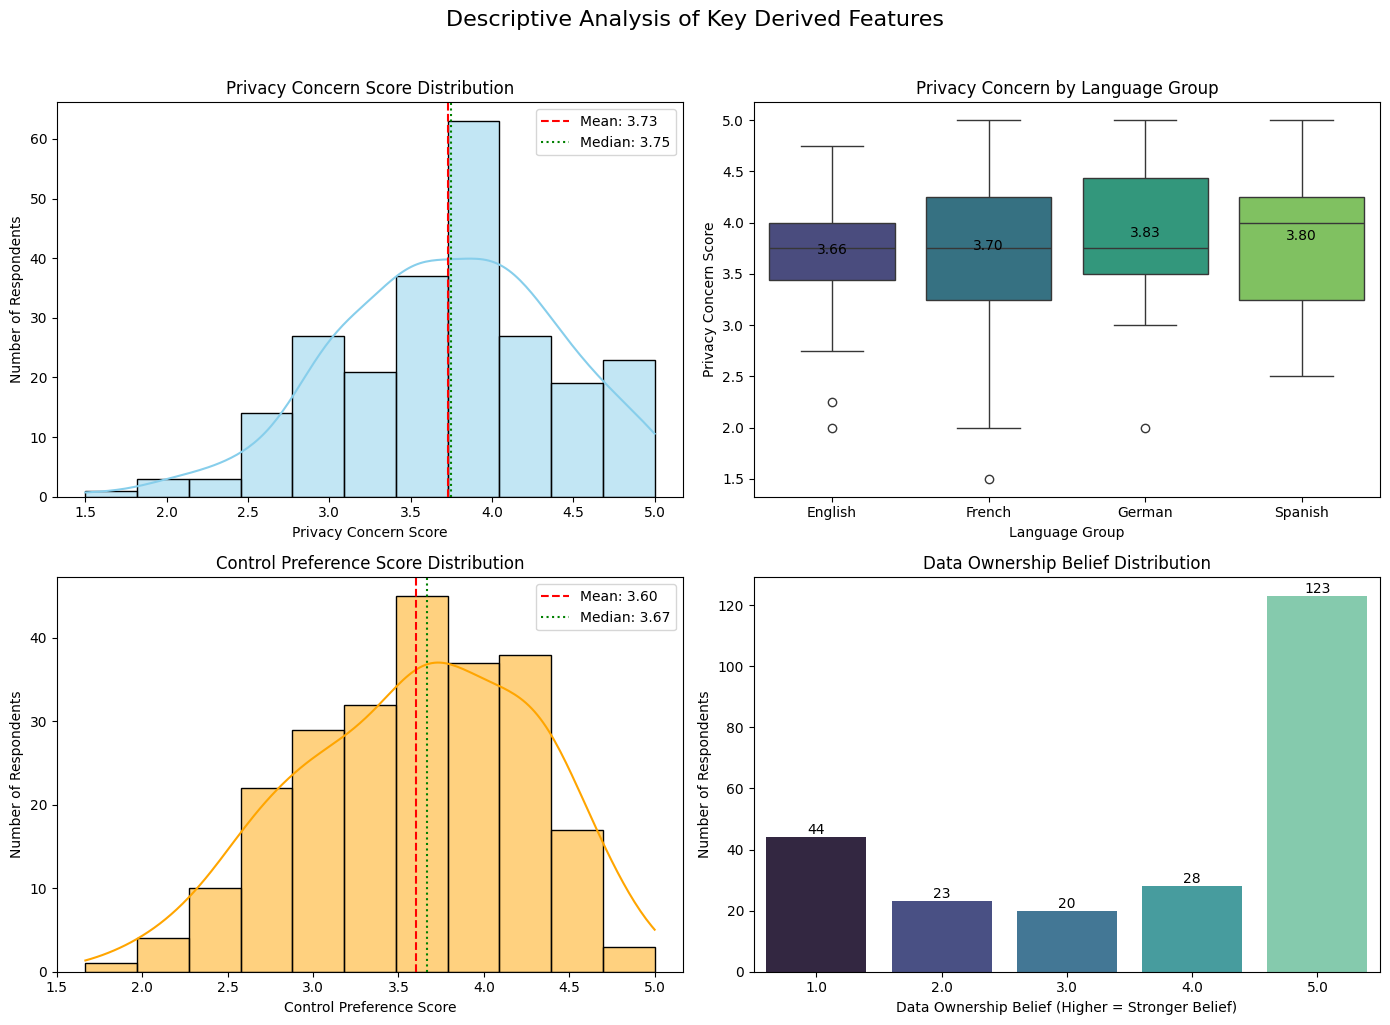

In [7]:
# Example usage
if __name__ == "__main__":
    try:
        # Load survey data and questions metadata
        survey_raw = pd.read_excel('data/survey_V2.xlsx', sheet_name='raw')
        questions_data = pd.read_excel('data/survey_V2.xlsx', sheet_name='index.questions')

        # Initialize cleaner and run full cleaning pipeline
        cleaner = SurveyDataCleaner(survey_raw, questions_data)
        cleaned_data = cleaner.clean_data()
        report = cleaner.generate_cleaning_report()
        print(f"\nCleaning completed: {report['transformations_applied']} transformations applied")
        print(f"Average response completeness: {report['average_response_completeness']:.1f}%")

        # Save cleaned data and transformation log
        cleaned_data.to_excel('data/survey_cleaned.xlsx', index=False)
        print("Cleaned data saved to data/survey_cleaned.xlsx")
        with open('data/transformation_log.txt', 'w') as f:
            for transformation in cleaner.get_transformation_log():
                f.write(f"{transformation}\n")
        print("Transformation log saved to data/transformation_log.txt")

        # Display summary statistics for key derived features
        print("\nLanguage Distribution:")
        print(cleaned_data['lang_group'].value_counts())
        print("\nUser Type Distribution:")
        print(cleaned_data['user_type'].value_counts())
        print("\nAvailable derived features:")
        for feature in ['privacy_concern_score', 'privacy_concern_level', 'control_preference_score', 'data_ownership_belief']:
            if feature in cleaned_data.columns:
                print(f"- {feature}")
                if feature == 'privacy_concern_level':
                    print("\nPrivacy Concern Levels:")
                    print(cleaned_data['privacy_concern_level'].value_counts())

        # Descriptive analysis summary plot for derived features
        has_privacy_score = 'privacy_concern_score' in cleaned_data.columns
        has_control_score = 'control_preference_score' in cleaned_data.columns
        has_ownership_belief = 'data_ownership_belief' in cleaned_data.columns

        plt.figure(figsize=(14, 10))
        plot_count = 0

        # Privacy concern distribution
        if has_privacy_score:
            plot_count += 1
            plt.subplot(2, 2, plot_count)
            sns.histplot(cleaned_data['privacy_concern_score'], kde=True, color='skyblue')
            plt.title('Privacy Concern Score Distribution')
            plt.xlabel('Privacy Concern Score')
            plt.ylabel('Number of Respondents')
            mean_val = cleaned_data['privacy_concern_score'].mean()
            median_val = cleaned_data['privacy_concern_score'].median()
            plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
            plt.axvline(median_val, color='green', linestyle=':', label=f'Median: {median_val:.2f}')
            plt.legend()

        # Privacy concern by language group
        if has_privacy_score:
            plot_count += 1
            plt.subplot(2, 2, plot_count)
            sns.boxplot(x='lang_group', y='privacy_concern_score', data=cleaned_data, palette='viridis')
            plt.title('Privacy Concern by Language Group')
            plt.xlabel('Language Group')
            plt.ylabel('Privacy Concern Score')
            group_means = cleaned_data.groupby('lang_group')['privacy_concern_score'].mean()
            for i, group in enumerate(group_means.index):
                plt.text(i, group_means[group], f'{group_means[group]:.2f}', ha='center', va='bottom', color='black')

        # Control preference score
        if has_control_score:
            plot_count += 1
            plt.subplot(2, 2, plot_count)
            sns.histplot(cleaned_data['control_preference_score'], kde=True, color='orange')
            plt.title('Control Preference Score Distribution')
            plt.xlabel('Control Preference Score')
            plt.ylabel('Number of Respondents')
            mean_val = cleaned_data['control_preference_score'].mean()
            median_val = cleaned_data['control_preference_score'].median()
            plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
            plt.axvline(median_val, color='green', linestyle=':', label=f'Median: {median_val:.2f}')
            plt.legend()

        # Data ownership belief
        if has_ownership_belief:
            plot_count += 1
            plt.subplot(2, 2, plot_count)
            sns.countplot(x='data_ownership_belief', data=cleaned_data, palette='mako')
            plt.title('Data Ownership Belief Distribution')
            plt.xlabel('Data Ownership Belief (Higher = Stronger Belief)')
            plt.ylabel('Number of Respondents')
            ownership_counts = cleaned_data['data_ownership_belief'].value_counts().sort_index()
            for i, count in enumerate(ownership_counts):
                plt.text(i, count, str(count), ha='center', va='bottom', color='black')

        # Only save and show if we have at least one plot
        if plot_count > 0:
            plt.suptitle('Descriptive Analysis of Key Derived Features', fontsize=16, y=1.02)
            plt.tight_layout()
            plt.savefig('data/derived_features_summary.png')
            plt.show()
        else:
            print("\nNo derived numerical features available for plotting")

    except Exception as e:
        logger.error(f"Error in main execution: {str(e)}")
        import traceback
        logger.error(f"Exception details: {traceback.format_exc()}")

# Survey Analysis

2025-08-07 12:56:57,124 - INFO - Loading cleaned survey data...
2025-08-07 12:56:57,220 - INFO - Analyzing Q4 by age group (Q22)...
2025-08-07 12:56:57,221 - INFO - --- [DEBUG] Entering analyze_by_demographic for Q'4' by demographic '22' ---
2025-08-07 12:56:57,221 - INFO - --- [DEBUG] Initial DataFrame shape for Q'4': (238, 36) ---
2025-08-07 12:56:57,280 - INFO - Analyzing Q13 by education level (Q23)...
2025-08-07 12:56:57,280 - INFO - --- [DEBUG] Entering analyze_by_demographic for Q'13' by demographic '23' ---
2025-08-07 12:56:57,281 - INFO - --- [DEBUG] Initial DataFrame shape for Q'13': (238, 36) ---
2025-08-07 12:56:57,330 - INFO - Running batch analysis on all questions...
2025-08-07 12:56:57,331 - INFO - Analyzing open-ended question 21
2025-08-07 12:56:57,334 - INFO - Analyzing Q21: Do you have any other thoughts on data privacy or decentralized solutions?



Demographic Analysis - Privacy concern by age group:

Demographic Analysis - Trust in new tech by education level:


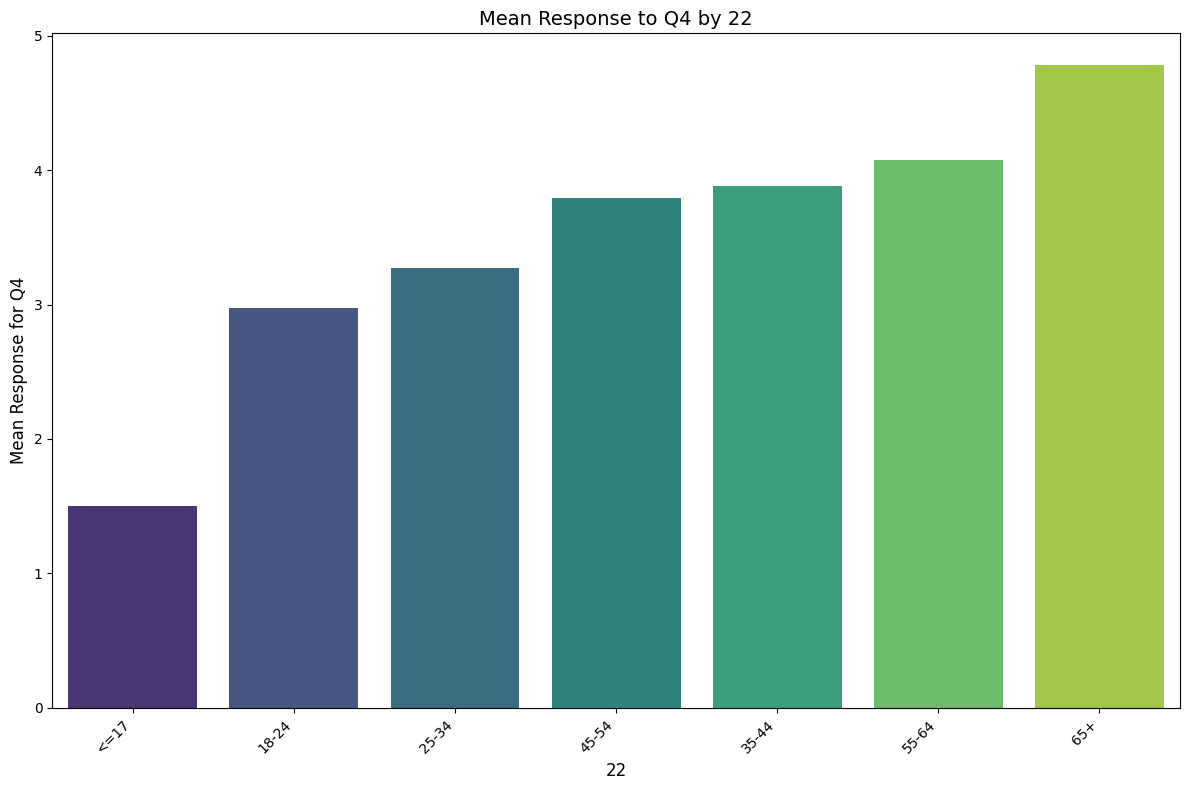

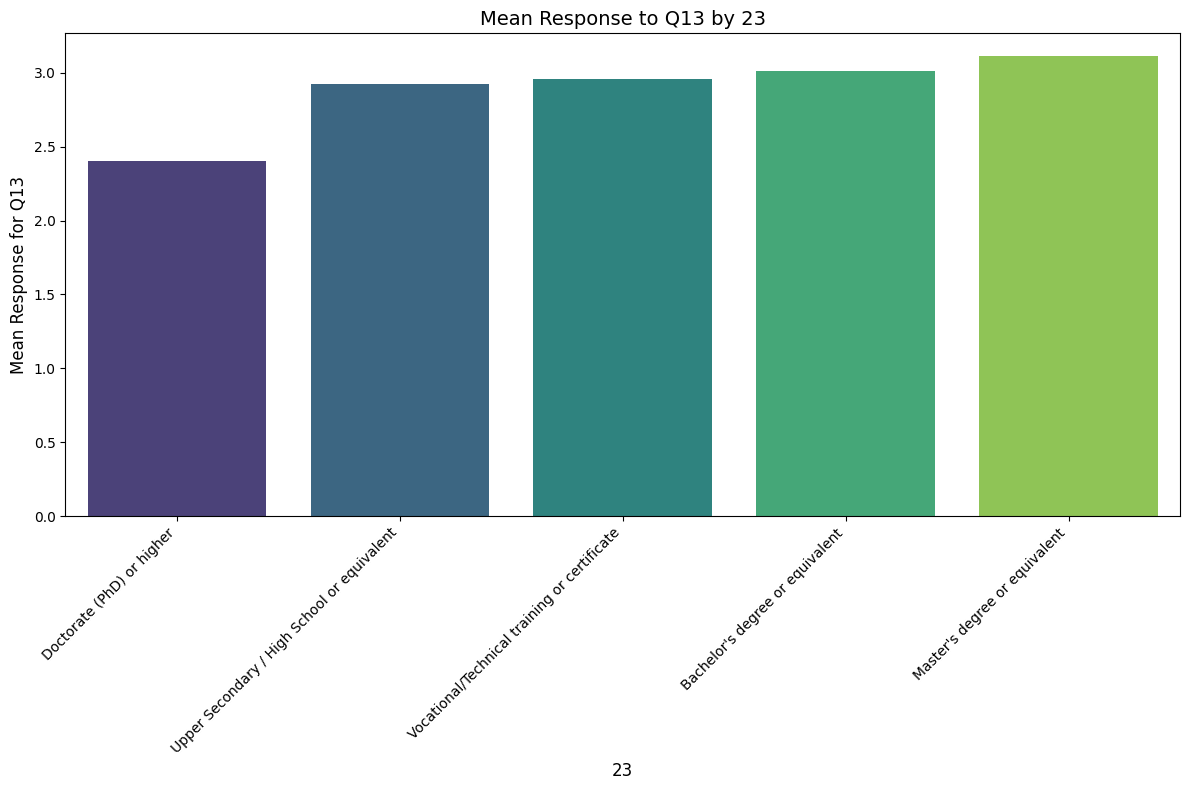

<Figure size 1000x600 with 0 Axes>

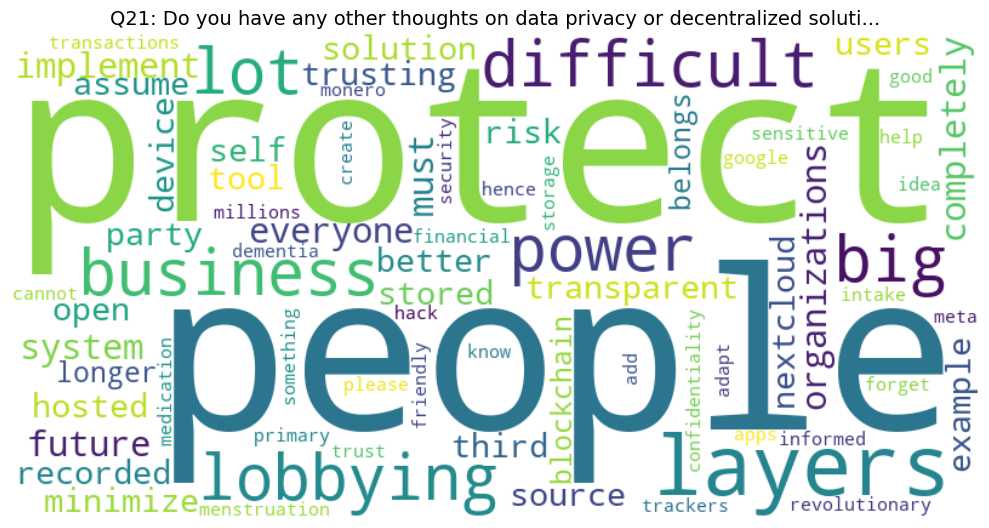

2025-08-07 12:56:58,016 - ERROR - Error in batch analysis: [Errno 2] No such file or directory: 'data/questions/open_ended_Q/Q21_wordcloud.png'
2025-08-07 12:56:58,019 - ERROR - Exception details: Traceback (most recent call last):
  File "C:\Users\URHU\AppData\Local\Temp\ipykernel_18176\603763287.py", line 2124, in analyze_all_questions
    plt.savefig(f"{output_dir}/open_ended_Q/Q{q_id}_wordcloud.png", bbox_inches='tight')
    ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\URHU\Documents\thesis_private\.venv\Lib\site-packages\matplotlib\pyplot.py", line 1251, in savefig
    res = fig.savefig(*args, **kwargs)  # type: ignore[func-returns-value]
  File "c:\Users\URHU\Documents\thesis_private\.venv\Lib\site-packages\matplotlib\figure.py", line 3490, in savefig
    self.canvas.print_figure(fname, **kwargs)
    ~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^
  File "c:\Users\URHU\Documents\thesis_private\.venv\Lib\site-packages\matplotlib\b


Batch Analysis Complete:


<Figure size 640x480 with 0 Axes>

In [22]:
try:
    
    # Configure basic logging
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    logger = logging.getLogger(__name__)
    
    # Load cleaned survey data and questions metadata
    logger.info("Loading cleaned survey data...")
    survey_cleaned = pd.read_excel('data/survey_cleaned.xlsx')
    questions_data = pd.read_excel('data/survey_V2.xlsx', sheet_name='index.questions')
    
    # Initialize the analyzer
    analyzer = SurveyAnalyzer(survey_cleaned, questions_data)
    
    # Create output directory for visualizations
    os.makedirs('analysis_output', exist_ok=True)
      
    # Analyze by demographic factors
    
    # Privacy concern (Q4) by age group (Q22)
    logger.info("Analyzing Q4 by age group (Q22)...")
    age_results = analyzer.analyze_by_demographic('4', '22')
    print(f"\nDemographic Analysis - Privacy concern by age group:")
    if 'highest_mean_group' in age_results:
        print(f"Highest mean score in age group: {age_results['highest_mean_group']}")
        print(f"Lowest mean score in age group: {age_results['lowest_mean_group']}")
    
    # Trust in new tech (Q13) by education level (Q23)
    logger.info("Analyzing Q13 by education level (Q23)...")
    edu_results = analyzer.analyze_by_demographic('13', '23')
    print(f"\nDemographic Analysis - Trust in new tech by education level:")
    if 'highest_mean_group' in edu_results:
        print(f"Highest mean score in education group: {edu_results['highest_mean_group']}")
    
    ###
    #Run batch analysis on all questions (this will take some time)
    run_batch = True  # Set to True if you want to run batch analysis
    if run_batch:
        logger.info("Running batch analysis on all questions...")
        batch_results = analyzer.analyze_all_questions(output_dir="data/questions")
        print(f"\nBatch Analysis Complete:")
        print(f"Total questions analyzed: {batch_results['total_questions_analyzed']}")
        print(f"Results saved to: {batch_results['output_directory']}")
    
    
    # Add these lines instead:
    logger.info("Generating correlation heatmap for all questions...")
    all_corr_results = analyzer.analyze_all_correlations()
    print(f"\nCorrelation Analysis Complete:")
    print(f"Top 5 strongest correlations:")
    for q1, q2, corr in all_corr_results["likert_strongest_correlations"][:5]:
        print(f"  Q{q1} and Q{q2}: {corr:.2f}")

    # Add derived feature analysis
    logger.info("Analyzing derived features...")
    derived_results = analyzer.analyze_derived_features()
    print("\nDerived Feature Analysis Complete")
    
except Exception as e:
    logger.error(f"Error in analysis execution: {str(e)}")
    import traceback
    logger.error(f"Exception details: {traceback.format_exc()}")

In [23]:
# show Q21 results
logger.info("Analyzing Q21 results...")
q21_results = survey_cleaned['21'].value_counts()
print("\nQ21 Results:")
print(q21_results)



2025-08-07 12:56:58,036 - INFO - Analyzing Q21 results...



Q21 Results:
21
No comment                                                                                                                                227
I think big business and their lobbying have a lot of power and it will be difficult to implement a system to protect everyone's data.      1
Future organizations must be completely transparent with users about how their data is stored and used to minimize risk.                    1
I think an open-source and self-hosted solution is better than trusting a third party, for example a tool like Nextcloud.                   1
I assume that all my health data recorded on a device no longer belongs to me.                                                              1
I think blockchain is revolutionary but few people know about it or are informed.                                                           1
The primary confidentiality is that of financial transactions. Hence Monero.                                                       

# External Comparison

2025-05-11 11:54:48,960 - INFO - Data validated: 238 responses with 35 columns


'Processing Pew code: CONCERNCO'

"Mapped survey QIDs: ['4']"

,Response,SurveyPercent,Question
16,5,23.9,How concerned are you about health data privacy?
15,4,28.2,How concerned are you about health data privacy?
17,3,23.1,How concerned are you about health data privacy?
18,2,18.9,How concerned are you about health data privacy?
19,1,5.9,How concerned are you about health data privacy?


,Response,PewPercent,Question
102,Very concerned,36,How concerned are you about how companies are using the data they collect about you?
103,Somewhat concerned,45,How concerned are you about how companies are using the data they collect about you?
104,Not too concerned,17,How concerned are you about how companies are using the data they collect about you?
105,Not at all concerned,4,How concerned are you about how companies are using the data they collect about you?


2025-05-11 11:54:49,002 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-11 11:54:49,004 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-11 11:54:49,008 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


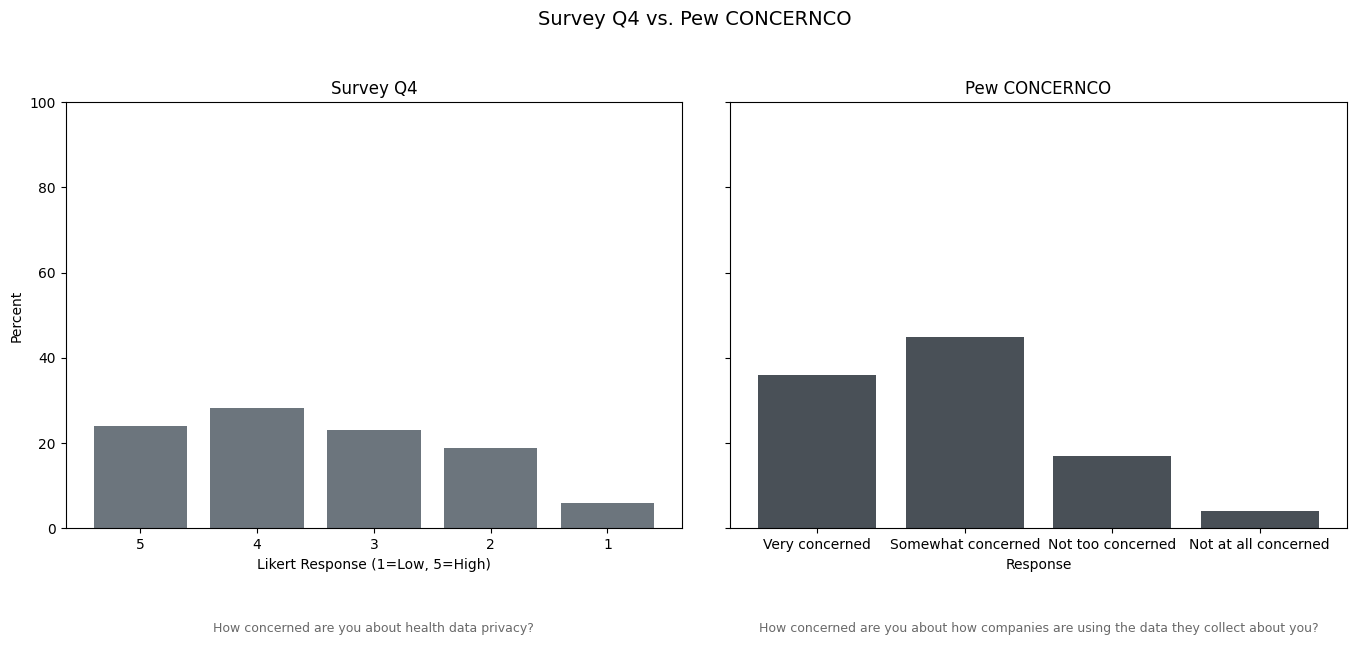

'Processing Pew code: CONTROLCO'

"Mapped survey QIDs: ['2']"

,Response,SurveyPercent,Question
9,5,4.2,How much control do you feel you have over your data?
8,4,8.0,How much control do you feel you have over your data?
7,3,23.1,How much control do you feel you have over your data?
5,2,40.8,How much control do you feel you have over your data?
6,1,23.9,How much control do you feel you have over your data?


,Response,PewPercent,Question
0,A great deal of control,4.0,How much control do you think you have over the data that companies collect about you?
2,Some control,18.0,How much control do you think you have over the data that companies collect about you?
3,Very little control,51.0,How much control do you think you have over the data that companies collect about you?
1,No control,27.0,How much control do you think you have over the data that companies collect about you?


2025-05-11 11:54:49,540 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-11 11:54:49,542 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-11 11:54:49,546 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


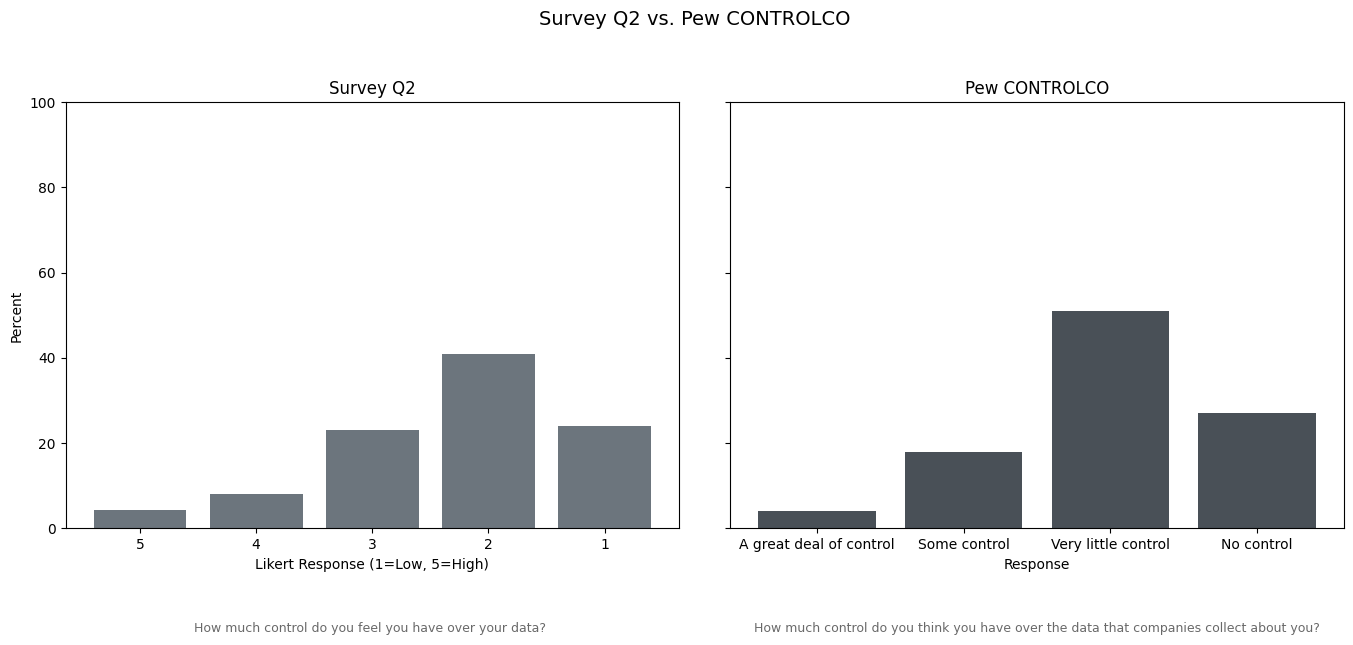

'Processing Pew code: SMLEAD'

"Mapped survey QIDs: ['1']"

,Response,SurveyPercent,Question
4,5,5.5,How much do you trust current centralized systems (where companies store and manage your data) to protect your health information?
3,4,12.6,How much do you trust current centralized systems (where companies store and manage your data) to protect your health information?
0,3,42.4,How much do you trust current centralized systems (where companies store and manage your data) to protect your health information?
1,2,22.7,How much do you trust current centralized systems (where companies store and manage your data) to protect your health information?
2,1,16.8,How much do you trust current centralized systems (where companies store and manage your data) to protect your health information?


,Response,PewPercent,Question
0,A great deal,6.000000,How much do you trust that leaders of social media companies will publicly admit mistakes and take responsibility when they misuse or compromise users’ personal data?
2,Some,12.666667,How much do you trust that leaders of social media companies will publicly admit mistakes and take responsibility when they misuse or compromise users’ personal data?
3,Very little,32.666667,How much do you trust that leaders of social media companies will publicly admit mistakes and take responsibility when they misuse or compromise users’ personal data?
1,Not at all,41.666667,How much do you trust that leaders of social media companies will publicly admit mistakes and take responsibility when they misuse or compromise users’ personal data?


2025-05-11 11:54:50,055 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-11 11:54:50,056 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-11 11:54:50,059 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


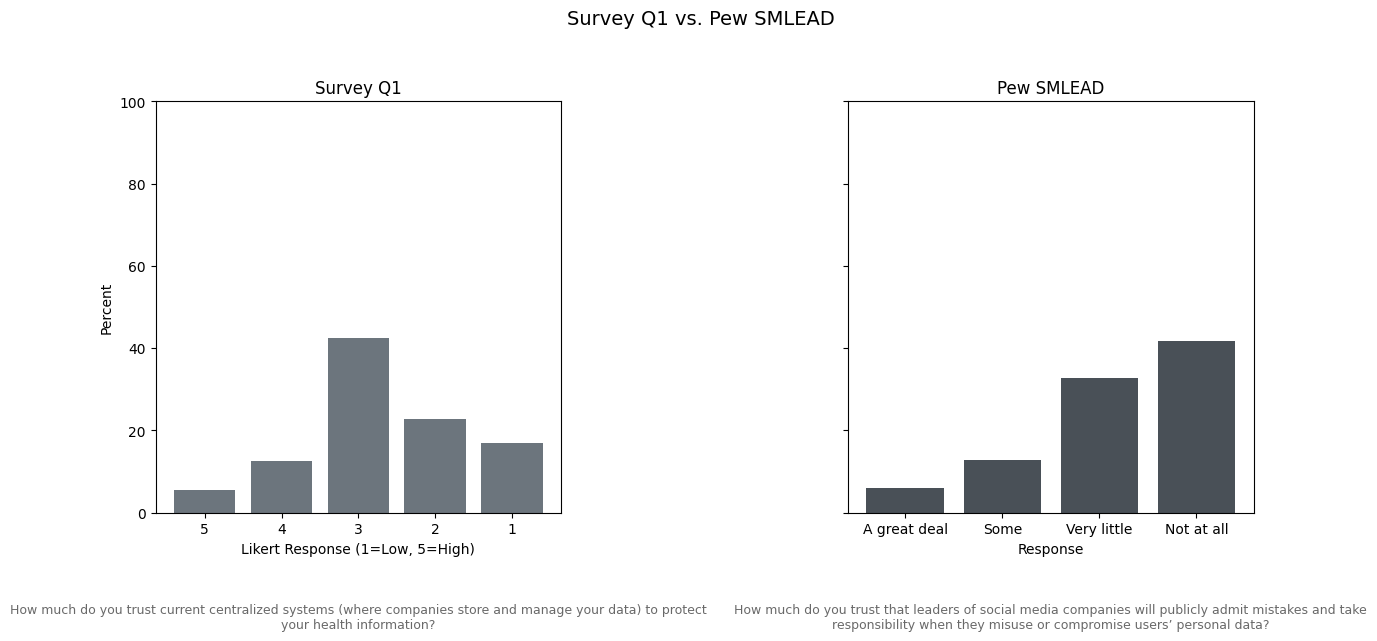

'Processing Pew code: AIPRIV3'

"Mapped survey QIDs: ['13']"

,Response,SurveyPercent,Question
94,5,4.6,How much trust do you have in systems based on new technologies (like blockchain) to protect your data?
91,4,27.7,How much trust do you have in systems based on new technologies (like blockchain) to protect your data?
90,3,40.8,How much trust do you have in systems based on new technologies (like blockchain) to protect your data?
92,2,18.1,How much trust do you have in systems based on new technologies (like blockchain) to protect your data?
93,1,8.8,How much trust do you have in systems based on new technologies (like blockchain) to protect your data?


,Response,PewPercent,Question
372,A great deal,2,How much do you trust companies to make responsible decisions about how they use AI in their products?
373,Some,22,How much do you trust companies to make responsible decisions about how they use AI in their products?
374,Very little,41,How much do you trust companies to make responsible decisions about how they use AI in their products?
375,Not at all,30,How much do you trust companies to make responsible decisions about how they use AI in their products?


2025-05-11 11:54:50,833 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-11 11:54:50,834 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-11 11:54:50,839 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


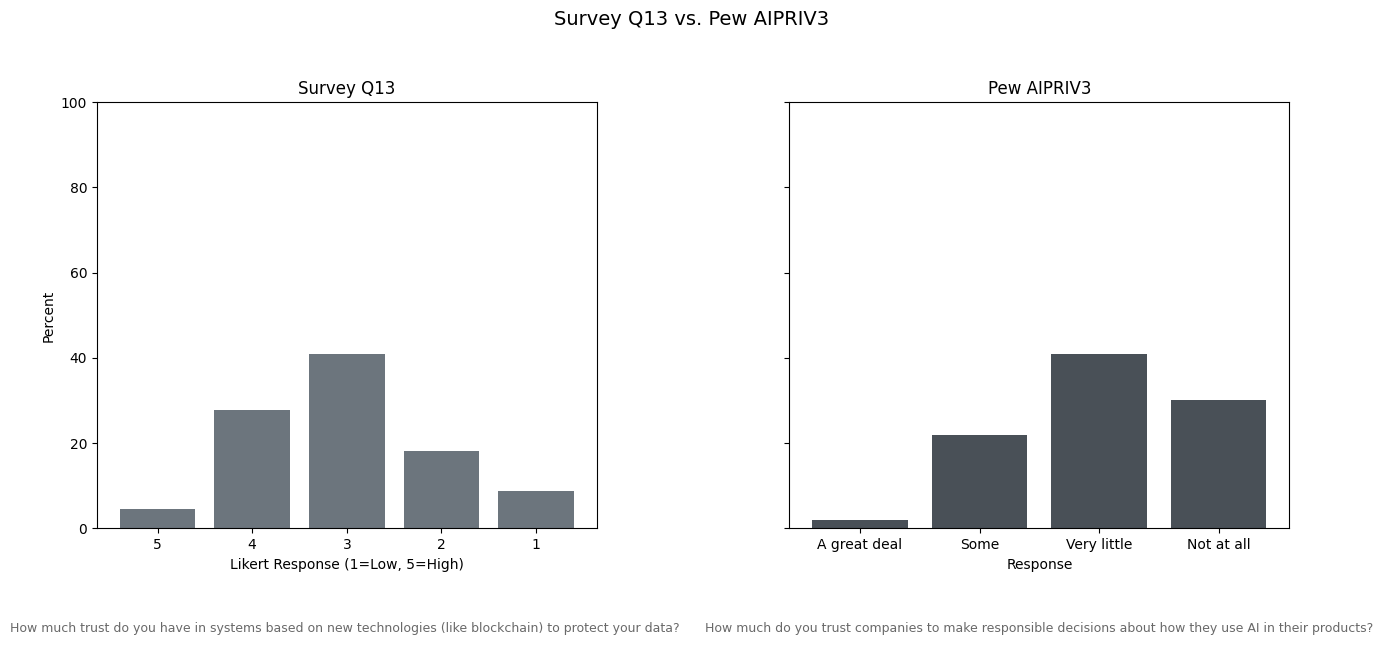

'Processing Pew code: PRIVWRY'

"Mapped survey QIDs: ['4']"

,Response,SurveyPercent,Question
16,5,23.9,How concerned are you about health data privacy?
15,4,28.2,How concerned are you about health data privacy?
17,3,23.1,How concerned are you about health data privacy?
18,2,18.9,How concerned are you about health data privacy?
19,1,5.9,How concerned are you about health data privacy?


,Response,PewPercent,Question
28,Very worried,38,How worried are you about… a. People stealing your identity or personal information
29,Somewhat worried,46,How worried are you about… a. People stealing your identity or personal information
30,Not too worried,14,How worried are you about… a. People stealing your identity or personal information
31,Not at all worried,2,How worried are you about… a. People stealing your identity or personal information
33,Very worried,42,How worried are you about… b. Companies selling your information to others without you knowing
34,Somewhat worried,42,How worried are you about… b. Companies selling your information to others without you knowing
35,Not too worried,14,How worried are you about… b. Companies selling your information to others without you knowing
36,Not at all worried,2,How worried are you about… b. Companies selling your information to others without you knowing
38,Very worried,15,How worried are you about… c. Law enforcement monitoring what you do online
39,Somewhat worried,24,How worried are you about… c. Law enforcement monitoring what you do online


2025-05-11 11:54:51,610 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-11 11:54:51,612 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-11 11:54:51,615 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


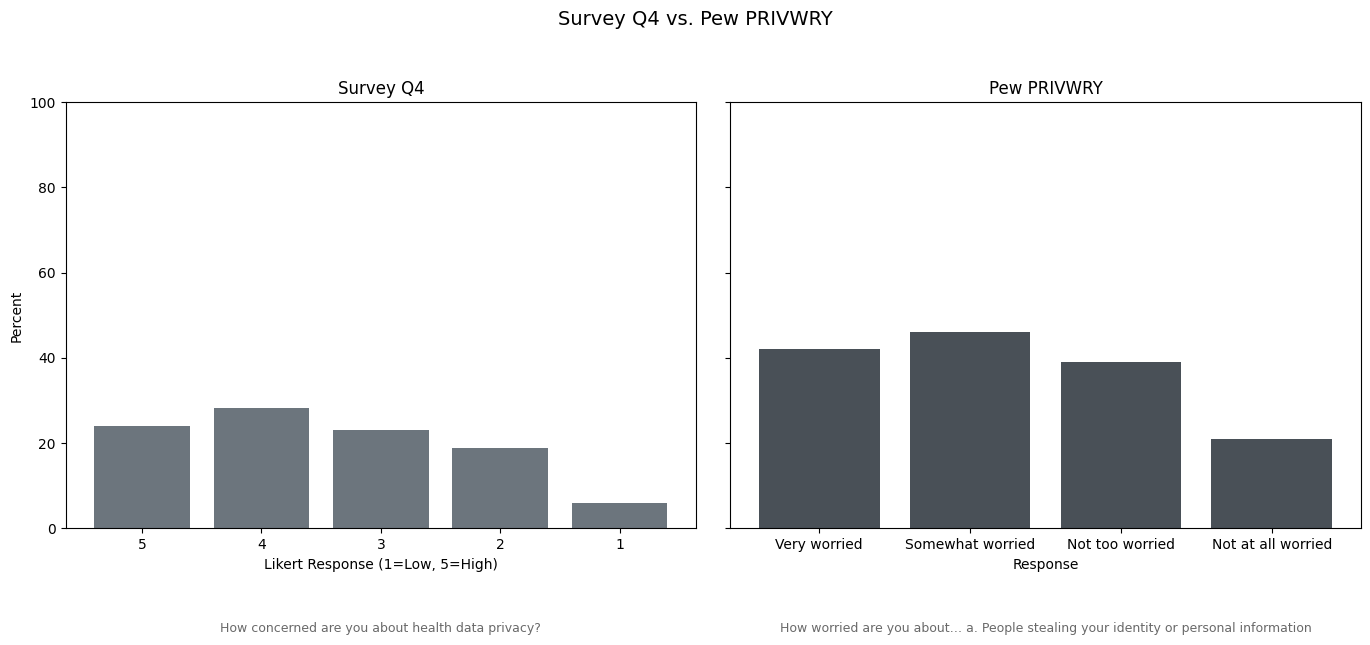

'Processing Pew code: PPREAD'

"Mapped survey QIDs: ['10']"

,Response,SurveyPercent,Question
79,No,38.8,(users only) Have you read your device’s privacy policy?
80,Skimmed,14.8,(users only) Have you read your device’s privacy policy?
81,Yes,3.8,(users only) Have you read your device’s privacy policy?


,Response,PewPercent,Question
150,Always or almost always,31,"How often do you click “agree” right away, without reading what these policies say?"
151,Often,26,"How often do you click “agree” right away, without reading what these policies say?"
152,Sometimes,22,"How often do you click “agree” right away, without reading what these policies say?"
153,Rarely,12,"How often do you click “agree” right away, without reading what these policies say?"
154,Never,6,"How often do you click “agree” right away, without reading what these policies say?"


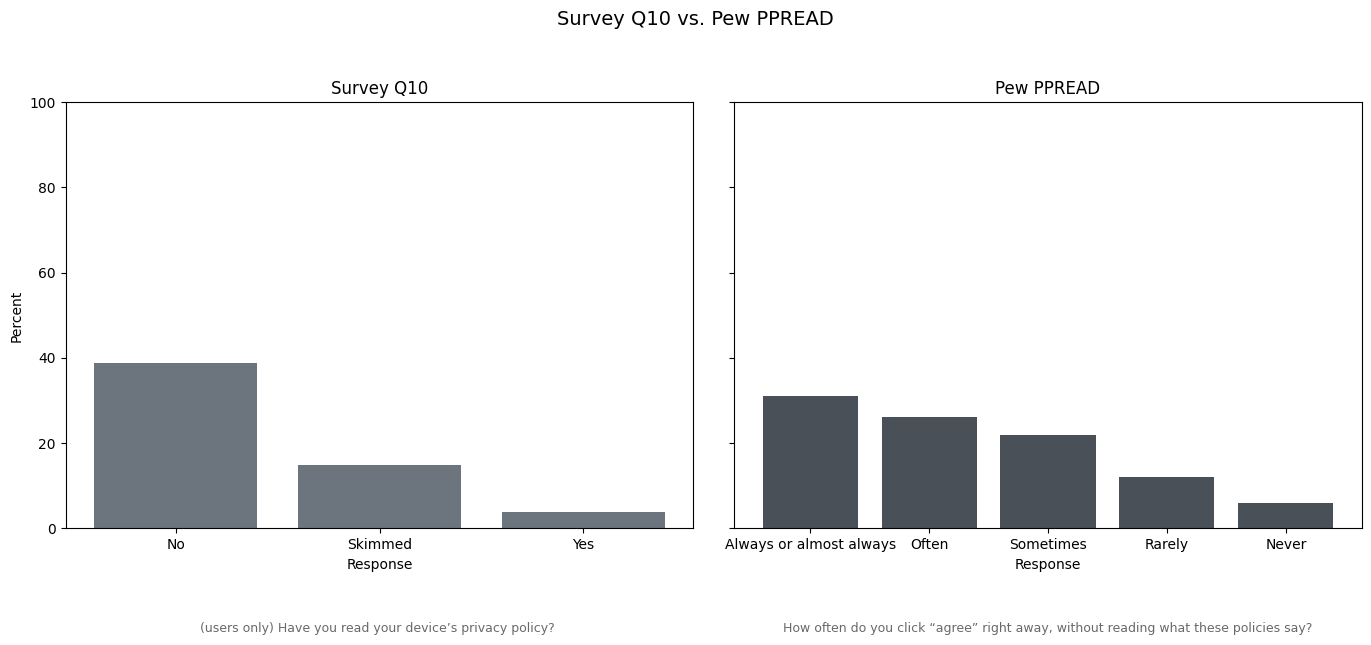

'Processing Pew code: AI_HEARD'

"Mapped survey QIDs: ['11']"

,Response,SurveyPercent,Question
82,"No, not familiar",48.3,"Prior to this survey, were you aware of these decentralized data management approaches?"
83,"Yes, somewhat familiar",42.4,"Prior to this survey, were you aware of these decentralized data management approaches?"
84,"Yes, very familiar",9.2,"Prior to this survey, were you aware of these decentralized data management approaches?"


,Response,PewPercent,Question
350,A lot,27,How much have you heard or read about AI?
351,A little,60,How much have you heard or read about AI?
352,Nothing at all,14,How much have you heard or read about AI?


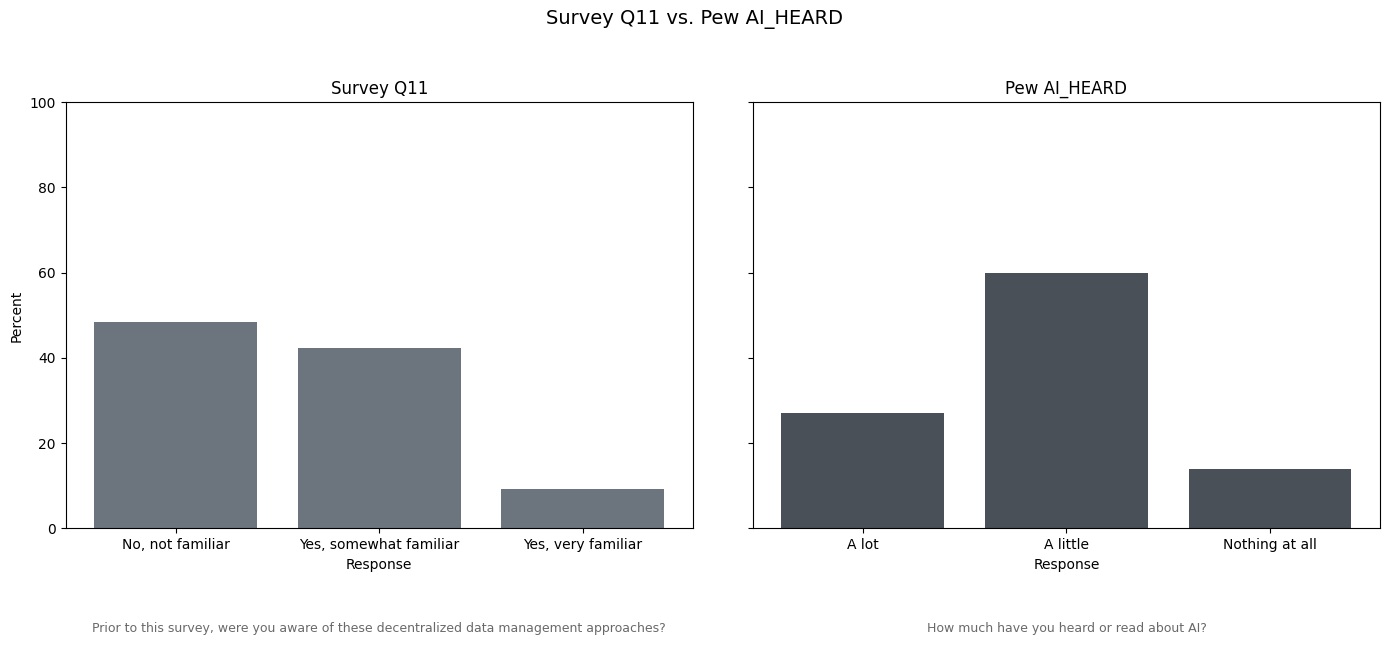

'Processing Pew code: DIGHABT1'

"Mapped survey QIDs: ['6']"

,Response,SurveyPercent,Question
0,Other reason,32.7,(non-users only) Why don’t you use connected devices? \n\nselect all that apply
1,Privacy-related reason,9.5,(non-users only) Why don’t you use connected devices? \n\nselect all that apply


,Response,PewPercent,Question
186,"Yes, I have",49,"Have you ever stopped using a digital device, website or app because you were worried about how your personal information was being used?"
187,"No, I have not",47,"Have you ever stopped using a digital device, website or app because you were worried about how your personal information was being used?"


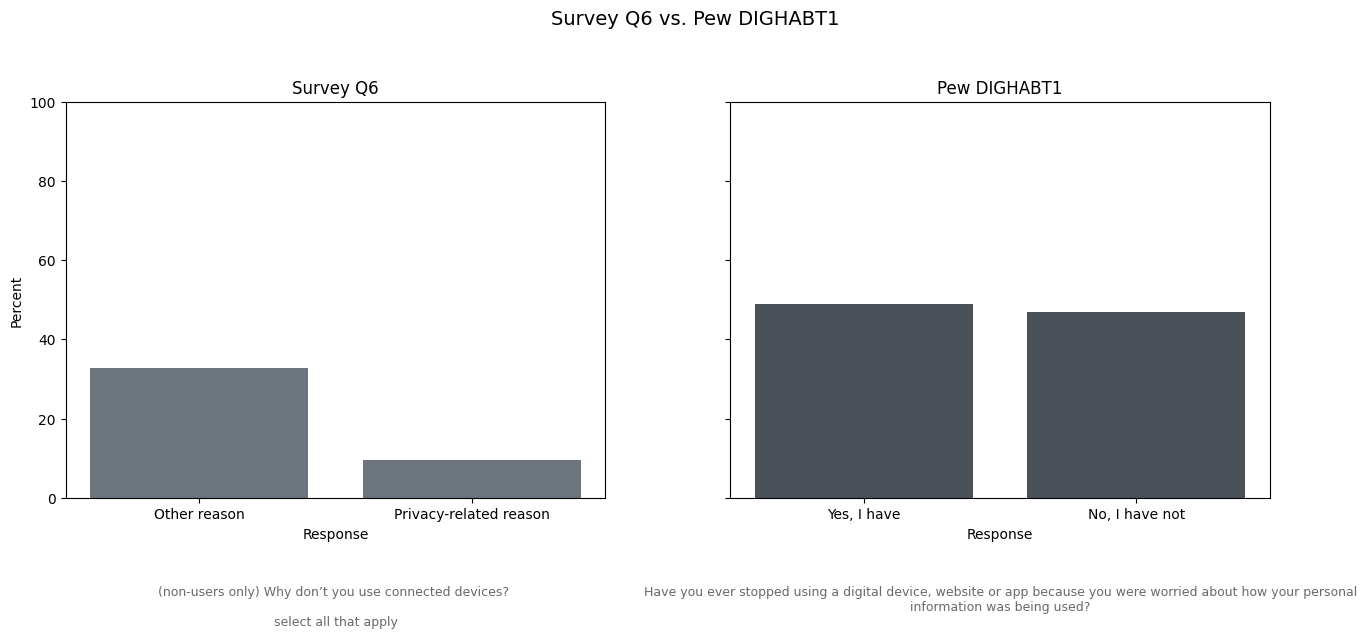

In [ ]:
# Load cleaned data and questions metadata
survey_cleaned = pd.read_excel('data/survey_cleaned.xlsx')
questions_data = pd.read_excel('data/survey_V2.xlsx', sheet_name='index.questions')
cleaner = SurveyDataCleaner(survey_cleaned, questions_data)
agg_df = cleaner.to_aggregated_percent_format()
agg_df.to_csv('data/survey_aggregated_percent.csv', index=False)
# Load Pew data
pew_data = pd.read_csv('data/pew_2023.csv')
relevant_codes = [
    'CONCERNCO', 'CONTROLCO', 'UNDERSTANDCO', 'CONCERNGOV', 'CONTROLGOV', 'UNDERSTANDGOV',
    'SMLEAD', 'AIPRIV1', 'AIPRIV2', 'AIPRIV3', 'PRIVFEEL', 'PRIVWRY', 'CYBCONF', 'DIGHABT1',
    'DIGHABT2', 'PPREAD', 'PPEFF', 'PPUSE', 'PWFEEL', 'PWPREF', 'PWMAN', 'PWEXP', 'SPACCESS',
    'UPDATEPREF', 'PRIVACYREG', 'GOVREGV1', 'KIDPRIV1', 'KIDPRIV2', 'ACCPTLWF1', 'ACCPTLWF2',
    'AI_HEARD', 'DIGCONF', 'TECHHELP', 'DKQ'
]
filtered_pew_data = pew_data[pew_data['QuestionID'].isin(relevant_codes)]
# Mapping between Pew codes and survey question IDs
mapping = {
    "CONCERNCO": ["4"],
    "CONTROLCO": ["2"],
    "SMLEAD": ["1"],
    "AIPRIV3": ["13"],
    "PRIVWRY": ["4"],
    "PPREAD": ["10"],
    "AI_HEARD": ["11"],
    "DIGHABT1": ["6"],

}

# Initialize and run the comparator
comparator = SurveyPewComparator(agg_df, filtered_pew_data, mapping)
# Example: plot all mapped comparisons
comparator.plot_all_comparisons()

# --- End standardized comparison plotting ---

# Quantitative Analysis

## per question details


Q2: How much control do you feel you have over your data? 
2
2    97
1    57
3    55
4    19
5    10
Name: count, dtype: int64

Q3: How much control do you feel users should have over their own health data?
3
5    138
4     64
3     32
2      3
1      1
Name: count, dtype: int64

Q16: Should users own their wearable data?
16
1    123
5     44
2     28
4     23
3     20
Name: count, dtype: int64


## Subgroup

In [9]:
question_ids_to_analyze = ['12'] #13,11,15,20, 14


In [10]:
survey_cleaned = pd.read_excel('data/survey_cleaned.xlsx')
questions_data = pd.read_excel('data/survey_V2.xlsx', sheet_name='index.questions')

def check_subgroup_for_question(survey_df, question_col, subgroup_col):
    """
    For a given question column, return the distribution of responses by subgroup as a formatted DataFrame.
    Handles both single-answer and multiple-answer questions correctly.
    """
    logger.info(f"--- [DEBUG] Entering check_subgroup_for_question for Q'{question_col}' by subgroup '{subgroup_col}' ---")
    if question_col not in survey_df.columns:
        return {"error": f"Question column '{question_col}' not found in survey data."}
    if subgroup_col not in survey_df.columns:
        return {"error": f"Subgroup column '{subgroup_col}' not found in survey data."}

    # Define user-specific and non-user-specific questions
    user_only_questions = ['7', '8', '9', '10']
    non_user_only_questions = ['6']

    # Select relevant columns, including 'user_type' for potential filtering
    required_cols = [question_col, subgroup_col]
    if 'user_type' not in required_cols:
        required_cols.append('user_type')
        
    df = survey_df[required_cols].copy()
    logger.info(f"--- [DEBUG] Initial DataFrame shape for Q'{question_col}': {df.shape} ---")

    # --- Filter data for user-specific or non-user-specific questions ---
    if question_col in user_only_questions:
        logger.info(f"--- [DEBUG] Q'{question_col}' is a user-only question. Filtering for 'User' type. ---")
        df = df[df['user_type'] == 'User']
        logger.info(f"--- [DEBUG] DataFrame shape after filtering for 'User': {df.shape} ---")
    elif question_col in non_user_only_questions:
        logger.info(f"--- [DEBUG] Q'{question_col}' is a non-user-only question. Filtering for 'Non-user' type. ---")
        df = df[df['user_type'] == 'Non-user']
        logger.info(f"--- [DEBUG] DataFrame shape after filtering for 'Non-user': {df.shape} ---")

    # Use a temporary analyzer to check question type
    analyzer_temp = SurveyAnalyzer(survey_df)
    is_multiple_answer = question_col in analyzer_temp.multiple_answer_questions

    # Drop rows where the question or subgroup is NaN
    df = df[[question_col, subgroup_col]].dropna()
    logger.info(f"--- [DEBUG] DataFrame shape after dropping NaNs: {df.shape} ---")

    if df.empty:
        logger.warning(f"--- [DEBUG] DataFrame is empty for Q'{question_col}' after filtering and NaN drop. ---")
        return pd.DataFrame()

    if is_multiple_answer:
        # Exclude non-informative answers before splitting
        df = df[~df[question_col].isin(['Not Applicable', 'No specific reason'])]
        if df.empty:
            return pd.DataFrame()

        # Split comma-separated values and explode into long format
        df_long = df.assign(choice=df[question_col].str.split(',')).explode('choice')
        df_long['choice'] = df_long['choice'].str.strip()

        # Create crosstab from the long format data
        subgroup_dist = pd.crosstab(df_long[subgroup_col], df_long['choice'])
        
        # Normalize by the total number of respondents in each subgroup, not by total choices
        subgroup_respondent_counts = df[subgroup_col].value_counts()
        subgroup_dist = subgroup_dist.div(subgroup_respondent_counts, axis=0) * 100
        
        subgroup_dist.columns.name = "Choice"

    else:
        # Original logic for single-answer questions
        subgroup_dist = pd.crosstab(df[subgroup_col], df[question_col], normalize='index') * 100
        subgroup_dist.columns.name = "Response"

    subgroup_dist = subgroup_dist.round(1)
    subgroup_dist.index.name = subgroup_col
    return subgroup_dist
def check_subgroup_for_all_questions(survey_df, subgroup_col, question_cols=None):
    """
    For all question columns, return the subgroup distribution for each as formatted DataFrames.
    """
    if question_cols is None:
        # Use only columns that look like question IDs (digits)
        question_cols = [col for col in survey_df.columns if col.isdigit()]
    results = {}
    for q_col in question_cols:
        results[q_col] = check_subgroup_for_question(survey_df, q_col, subgroup_col)
    return results
def check_subgroup_for_multiple(survey_df, subgroup_cols, question_cols=None):
    """
    Loop through multiple subgroup columns and return results for each.
    """
    all_results = {}
    for subgroup_col in subgroup_cols:
        all_results[subgroup_col] = check_subgroup_for_all_questions(survey_df, subgroup_col, question_cols)
    return all_results
def show_question_results(cleaned_data, questions_data, question_ids):
    """
    Display the value counts and question description for one or more questions.

    Parameters:
    - cleaned_data: pd.DataFrame, the cleaned survey data
    - questions_data: pd.DataFrame, the questions metadata
    - question_ids: str or list of str, question column(s) to display
    """
    if isinstance(question_ids, str):
        question_ids = [question_ids]
    for qid in question_ids:
        desc_row = questions_data[questions_data['quest_id'] == int(qid)]
        desc = desc_row['question_descr'].values[0] if not desc_row.empty else f"Question {qid}"
        print(f"\nQ{qid}: {desc}")
        print(cleaned_data[qid].value_counts(dropna=False))

# --- Main Execution Block ---
#rename col 22,23,24,25 to Age group, Education level, Occupation, Country
survey_cleaned.rename(columns={
    '22': 'Age group',
    '23': 'Education level',
    '24': 'Occupation',
    '25': 'Country'
}, inplace=True)
subgroup_cols = [
    'user_type',
    'lang_group',
    'privacy_concern_score',
    'privacy_concern_level',
    'tech_trust_score',
    'control_preference_score',
    'data_ownership_belief',
    'response_completeness',
    'Age group',
    'Education level',
    'Occupation',
    'Country',
    'cluster_profile'
]
# The results of this function are not used in the report generation, but it's good practice to have it run correctly.
results = check_subgroup_for_multiple(survey_cleaned, subgroup_cols)

# Set this parameter to True to save the report, or False to display it directly.
save_to_file = True 

output_md_file = 'drafts/subgroup_analysis_report.md'
# Define a dedicated directory for subgroup analysis images
output_img_dir = r"data\img\subgroup_ana"
os.makedirs(output_img_dir, exist_ok=True)


# Instantiate the analyzer to use its plotting and metrics functions
analyzer = SurveyAnalyzer(survey_cleaned, questions_data)

if save_to_file:
    with open(output_md_file, 'w', encoding='utf-8') as f:
        f.write("# Subgroup Analysis Report\n\n")
        
        for qid in question_ids_to_analyze:
            # --- Get Question Info ---
            desc_row = questions_data[questions_data['quest_id'] == int(qid)]
            desc = desc_row['question_descr'].values[0] if not desc_row.empty else f"Question {qid}"
            
            f.write(f"---\n\n# Question {qid}: {desc}\n\n")
            
            # --- Generate and Write Overall Distribution Plot and Metrics ---
            f.write("## Overall Distribution & Metrics\n\n")
            
            analysis_results = {}
            overall_plot_path_abs = os.path.join(output_img_dir, f"Q{qid}_overall_dist.png")
            
            original_img_dir = None
            try:
                original_img_dir = analyzer.output_dir
                analyzer.output_dir = output_img_dir
                
                md_dir = os.path.dirname(output_md_file)
                overall_plot_path_rel = os.path.relpath(overall_plot_path_abs, md_dir).replace('\\', '/')
                logger.info(f"Q{qid}: Absolute plot path set to: {overall_plot_path_abs}")
                logger.info(f"Q{qid}: Relative plot path for MD set to: {overall_plot_path_rel}")

                # Call the appropriate analysis function based on question type
                if qid in analyzer.likert_scale_questions:
                    logger.info(f"Q{qid}: Identified as Likert scale. Calling analyze_likert_scale_question.")
                    analysis_results = analyzer.analyze_likert_scale_question(qid)
                    plt.savefig(overall_plot_path_abs, bbox_inches='tight')
                    plt.close()
                    f.write(f"![Overall Distribution for Q{qid}]({overall_plot_path_rel})\n\n")
                    f.write("### Key Metrics\n\n")
                    f.write(f"- **Mean:** {analysis_results.get('mean', 'N/A'):.2f}\n")
                    f.write(f"- **Median:** {analysis_results.get('median', 'N/A'):.2f}\n")
                    f.write(f"- **Std. Dev:** {analysis_results.get('std', 'N/A'):.2f}\n\n")

                elif qid in analyzer.single_choice_questions:
                    logger.info(f"Q{qid}: Identified as single choice. Calling analyze_single_choice_question.")
                    analysis_results = analyzer.analyze_single_choice_question(qid)
                    plt.savefig(overall_plot_path_abs, bbox_inches='tight')
                    plt.close()
                    f.write(f"![Overall Distribution for Q{qid}]({overall_plot_path_rel})\n\n")
                    f.write("### Key Metrics\n\n")
                    f.write(f"- **Most Common:** {analysis_results.get('most_common', 'N/A')}\n")
                    f.write(f"- **Least Common:** {analysis_results.get('least_common', 'N/A')}\n\n")

                elif qid in analyzer.multiple_answer_questions:
                    logger.info(f"Q{qid}: Identified as multiple answer. Calling analyze_multiple_answer_question.")
                    analysis_results = analyzer.analyze_multiple_answer_question(qid)
                    plt.savefig(overall_plot_path_abs, bbox_inches='tight')
                    plt.close()
                    logger.info(f"Q{qid}: Attempting to write MD link using: {overall_plot_path_rel}")
                    f.write(f"![Overall Distribution for Q{qid}]({overall_plot_path_rel})\n\n")
                    f.write("### Key Metrics\n\n")
                    f.write(f"- **Most Common Choice:** {analysis_results.get('most_common_choice', 'N/A')}\n")
                    f.write(f"- **Total Respondents:** {analysis_results.get('total_respondents', 'N/A')}\n\n")
                else:
                    f.write("_No specific analysis function for this question type. Displaying raw counts._\n\n")

            finally:
                if original_img_dir:
                    analyzer.output_dir = original_img_dir
                plt.close('all')

            f.write("### Overall Distribution Table\n\n")
            overall_dist = survey_cleaned[qid].value_counts(dropna=False).to_frame().to_markdown()
            f.write(f"{overall_dist}\n\n")
            
            # --- Generate and Write Subgroup Tables and PLOTS ---
            f.write("## Subgroup Distributions\n\n")
            for subgroup_col in subgroup_cols:
                # Skip analysis if subgroup is a high-cardinality continuous variable or the question itself
                if subgroup_col == qid or survey_cleaned[subgroup_col].nunique() > 50:
                    logger.info(f"Skipping subgroup analysis for '{subgroup_col}' due to high cardinality or self-comparison.")
                    continue

                f.write(f"### Distribution by Subgroup: `{subgroup_col}`\n\n")
                
                sanitized_subgroup_col = subgroup_col.replace(' ', '_').replace('/', '_')
                subgroup_plot_path_abs = os.path.join(output_img_dir, f"Q{qid}_by_{sanitized_subgroup_col}.png")
                logger.info(f"Attempting to save subgroup plot for Q{qid} by '{subgroup_col}' to: {os.path.abspath(subgroup_plot_path_abs)}")
                
                try:
                    original_img_dir = analyzer.output_dir
                    analyzer.output_dir = output_img_dir
                    
                    # Call the now-corrected demographic analysis function which creates a plot
                    analyzer.analyze_by_demographic(qid, subgroup_col)
                    plt.savefig(subgroup_plot_path_abs, bbox_inches='tight')
                    plt.close()
                    
                    md_dir = os.path.dirname(output_md_file)
                    subgroup_plot_path_rel = os.path.relpath(subgroup_plot_path_abs, md_dir).replace('\\', '/')
                    f.write(f"![Distribution for Q{qid} by {subgroup_col}]({subgroup_plot_path_rel})\n\n")

                except Exception as e:
                    logger.error(f"Failed to generate or save plot for subgroup '{subgroup_col}'. Error: {e}", exc_info=True)
                    f.write(f"_Could not generate plot for this subgroup: {e}_\n\n")
                finally:
                    if original_img_dir:
                        analyzer.output_dir = original_img_dir
                    plt.close('all')

                # --- Generate and write the table using the corrected function ---
                dist = check_subgroup_for_question(survey_cleaned, qid, subgroup_col)
                
                if isinstance(dist, dict) and 'error' in dist:
                    f.write(f"_{dist['error']}_\n\n")
                elif dist.empty:
                    f.write("_No data available for this subgroup table._\n\n")
                else:
                    f.write(dist.to_markdown() + "\n\n")

    print(f"Subgroup analysis report saved to '{output_md_file}'")
else:
    # Display output directly in the notebook (original functionality)
    for qid in question_ids_to_analyze:
        desc_row = questions_data[questions_data['quest_id'] == int(qid)]
        desc = desc_row['question_descr'].values[0] if not desc_row.empty else f"Question {qid}"
        print(f"--- Question {qid}: {desc} ---")
        
        # Display overall plot and metrics
        if qid in analyzer.likert_scale_questions:
            analyzer.analyze_likert_scale_question(qid)
        elif qid in analyzer.single_choice_questions:
            analyzer.analyze_single_choice_question(qid)
        elif qid in analyzer.multiple_answer_questions:
            analyzer.analyze_multiple_answer_question(qid)
        else:
            print("\nOverall Distribution:")
            print(survey_cleaned[qid].value_counts(dropna=False))
        
        # Display subgroup tables
        for subgroup_col in subgroup_cols:
            print(f"\n--- Distribution by Subgroup: {subgroup_col} ---")
            dist = check_subgroup_for_question(survey_cleaned, qid, subgroup_col)
            display(dist)
        print("\n" + "="*80 + "\n")

2025-07-22 10:28:24,857 - INFO - --- [DEBUG] Entering check_subgroup_for_question for Q'1' by subgroup 'user_type' ---
2025-07-22 10:28:24,859 - INFO - --- [DEBUG] Initial DataFrame shape for Q'1': (238, 2) ---
2025-07-22 10:28:24,864 - INFO - --- [DEBUG] DataFrame shape after dropping NaNs: (238, 2) ---
2025-07-22 10:28:24,889 - INFO - --- [DEBUG] Entering check_subgroup_for_question for Q'2' by subgroup 'user_type' ---
2025-07-22 10:28:24,891 - INFO - --- [DEBUG] Initial DataFrame shape for Q'2': (238, 2) ---
2025-07-22 10:28:24,894 - INFO - --- [DEBUG] DataFrame shape after dropping NaNs: (238, 2) ---
2025-07-22 10:28:24,901 - INFO - --- [DEBUG] Entering check_subgroup_for_question for Q'3' by subgroup 'user_type' ---
2025-07-22 10:28:24,903 - INFO - --- [DEBUG] Initial DataFrame shape for Q'3': (238, 2) ---
2025-07-22 10:28:24,906 - INFO - --- [DEBUG] DataFrame shape after dropping NaNs: (238, 2) ---
2025-07-22 10:28:24,916 - INFO - --- [DEBUG] Entering check_subgroup_for_question 

Subgroup analysis report saved to 'drafts/subgroup_analysis_report.md'


##  Correlation

In [4]:
# Load cleaned survey data
df = pd.read_excel('data/survey_cleaned.xlsx').copy()

# Ensure derived columns exist and are properly named
df['Age group'] = df['22'] if '22' in df.columns else df.get('Age group')
df['Education level'] = df['23'] if '23' in df.columns else df.get('Education level')
df['Occupation'] = df['24'] if '24' in df.columns else df.get('Occupation')
df['Country'] = df['25'] if '25' in df.columns else df.get('Country')

# One-hot encode cluster_profile, lang_group, and Age group
dummy_cols = []
# Define which original columns will be replaced by dummies
cols_to_dummify = ['cluster_profile', 'lang_group', 'Age group', 'user_type', 'Education level', 'Occupation']
for col in cols_to_dummify:
    if col in df.columns:
        dummies = pd.get_dummies(df[col], prefix=col.replace(' ', '_'))
        df = pd.concat([df, dummies], axis=1)
        dummy_cols += list(dummies.columns)
# List of variables to correlate with Q4, Q1, Q19
# Exclude the original columns that were dummified
base_corr_vars = [
    'privacy_concern_score',
    'tech_trust_score', 'control_preference_score', 'data_ownership_belief',
    'Education level', 'Occupation',
    'Country'
]
# Filter out any base vars that were also dummified
corr_vars = [v for v in base_corr_vars if v not in cols_to_dummify] + dummy_cols

# Helper: encode categorical variables as codes for correlation
def encode_categoricals(df, columns):
    df = df.copy()
    for col in columns:
        if col in df.columns and not pd.api.types.is_numeric_dtype(df[col]):
            df[col] = pd.Categorical(df[col]).codes
    return df

# Directory for saving correlation plots
corr_dir = 'data/img/corr'
os.makedirs(corr_dir, exist_ok=True)

# Function to plot correlation heatmap for a given question vs key variables
def plot_correlation_heatmap(question_col, question_name, df, corr_vars, save_dir, is_multi_choice_text=False):
    """
    Analyzes and plots correlations as a heatmap, including statistical significance.
    If is_multi_choice_text is True, it one-hot encodes the question column first.
    Only statistically significant variables (p < 0.05) are plotted.
    """
    from scipy.stats import pearsonr
    import logging

    logger = logging.getLogger(__name__)
    logger.info(f"--- [DEBUG] Entering plot_correlation_heatmap for Q{question_col}: {question_name} ---")

    df_copy = df.copy()

# Function to plot correlation heatmap for a given question vs key variables
def plot_correlation_heatmap(question_col, question_name, df, corr_vars, save_dir, is_multi_choice_text=False):
    """
    Analyzes and plots correlations as a heatmap, including statistical significance.
    If is_multi_choice_text is True, it one-hot encodes the question column first.
    Only statistically significant variables (p < 0.05) are plotted.
    """
    from scipy.stats import pearsonr
    df_copy = df.copy()

    # --- Special handling for multi-choice text questions (like Q19 or Q18) ---
    if is_multi_choice_text:
        # Clean the column: fill NaNs, remove non-applicable answers, and strip whitespace
        responses = df_copy[question_col].fillna('').str.strip()
        responses = responses.replace(['Not Applicable', 'No specific reason'], '')

        # Use str.get_dummies to correctly one-hot encode comma-separated values
        q_dummies = responses.str.get_dummies(sep=',')
        
        # Clean up dummy column names (remove leading/trailing spaces)
        q_dummies.columns = [col.strip() for col in q_dummies.columns]

        # Handle potential duplicate columns by combining them
        q_dummies = q_dummies.groupby(level=0, axis=1).max()
        
        # Add a prefix to the dummy columns for clarity
        q_dummies = q_dummies.add_prefix(f"Q{question_col}_")

        # Combine with the original dataframe
        df_copy = pd.concat([df_copy, q_dummies], axis=1)
        analysis_vars = list(q_dummies.columns)
        all_vars = analysis_vars + corr_vars
    else:
        analysis_vars = [question_col]
        all_vars = analysis_vars + corr_vars

    # Prepare dataframe for correlation
    valid_vars = [v for v in all_vars if v in df_copy.columns]
    df_corr = df_copy[valid_vars].copy()
    
    # Remove potential duplicate columns from the list of variables to correlate against
    corr_vars = [v for v in corr_vars if v in df_corr.columns and v not in analysis_vars]
    # Ensure corr_vars has unique values after filtering
    corr_vars = list(dict.fromkeys(corr_vars))

    df_corr = encode_categoricals(df_corr, valid_vars)
    df_corr = df_corr.apply(pd.to_numeric, errors='coerce').dropna()

    # --- Calculate Correlation and P-values ---
    corr_matrix = pd.DataFrame(index=corr_vars, columns=analysis_vars, dtype=float)
    pval_matrix = pd.DataFrame(index=corr_vars, columns=analysis_vars, dtype=float)

    for r_var in corr_vars:
        for c_var in analysis_vars:
            if r_var in df_corr.columns and c_var in df_corr.columns and r_var != c_var:
                # Ensure there is variance in the columns to avoid errors
                if df_corr[r_var].nunique() > 1 and df_corr[c_var].nunique() > 1:
                    corr, pval = pearsonr(df_corr[r_var], df_corr[c_var])
                    corr_matrix.loc[r_var, c_var] = corr
                    pval_matrix.loc[r_var, c_var] = pval

    # --- Filter for Statistically Significant Variables ---
    significant_vars_mask = (pval_matrix < 0.05).any(axis=1)
    significant_vars = pval_matrix.index[significant_vars_mask]

    if significant_vars.empty:
        print(f"--- No statistically significant correlations found for {question_name}. ---")
        return

    corr_matrix_sig = corr_matrix.loc[significant_vars]
    pval_matrix_sig = pval_matrix.loc[significant_vars]

    # --- Create Annotation Labels with Significance ---
    annot_labels = corr_matrix_sig.copy().astype(str)
    for r in annot_labels.index:
        for c in annot_labels.columns:
            pval = pval_matrix_sig.loc[r, c]
            corr_val = corr_matrix_sig.loc[r, c]
            if pd.isna(pval) or pd.isna(corr_val): continue
            stars = ""
            if pval < 0.001: stars = "***"
            elif pval < 0.01: stars = "**"
            elif pval < 0.05: stars = "*"
            annot_labels.loc[r, c] = f"{corr_val:.2f}{stars}"

    # --- Display Correlation Matrix Table ---
    print(f"--- Significant Correlation Matrix for {question_name} Analysis ---")
    if is_multi_choice_text:
        # Sort columns by the strength of their correlations for better readability
        sorted_cols = corr_matrix_sig.abs().sum().sort_values(ascending=False).index
        corr_matrix_sig = corr_matrix_sig[sorted_cols]
        annot_labels = annot_labels[sorted_cols]

    print(tabulate(annot_labels, headers='keys', tablefmt='psql'))
    print("Significance: * p < 0.05, ** p < 0.01, *** p < 0.001\n")

    # --- Plotting the Heatmap ---
    plt.figure(figsize=(max(8, len(analysis_vars) * 1.2), max(6, len(significant_vars) * 0.5)))
    sns.heatmap(
        corr_matrix_sig,
        annot=annot_labels,
        cmap='viridis',
        fmt='s',
        linewidths=.5,
        vmin=-1,
        vmax=1
    )
    plt.title(f"Significant Correlations of {question_name} with Key Features", fontsize=15)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()

    # Save plot
    fname = os.path.join(save_dir, f"corr_heatmap_{question_col}_vs_key_vars.png")
    plt.savefig(fname, bbox_inches='tight')
    plt.show()

    print(f"Saved correlation heatmap for {question_name} to {fname}")

# Function to plot correlation bar for a given question vs key variables
def plot_corr_bar(question_col, question_name, df, corr_vars, save_dir):
    """
    Analyzes and plots correlations as a bar chart, including statistical significance.
    Only statistically significant variables (p < 0.05) are plotted.
    """
    from scipy.stats import pearsonr
    # Prepare dataframe
    all_vars = [question_col] + corr_vars
    df_corr = df[all_vars].copy()
    df_corr = encode_categoricals(df_corr, all_vars)
    df_corr = df_corr.apply(pd.to_numeric, errors='coerce').dropna()

    # --- Calculate Correlations and P-values ---
    corrs = {}
    pvals = {}
    for var in corr_vars:
        if var in df_corr.columns and var != question_col:
            corr, pval = pearsonr(df_corr[question_col], df_corr[var])
            corrs[var] = corr
            pvals[var] = pval
    
    corrs_series = pd.Series(corrs)
    pvals_series = pd.Series(pvals)

    # --- Filter for Statistically Significant Correlations ---
    significant_mask = pvals_series < 0.05
    corrs_sig = corrs_series[significant_mask]
    pvals_sig = pvals_series[significant_mask]

    if corrs_sig.empty:
        print(f"--- No statistically significant correlations found for {question_name}. ---")
        return

    # --- Display Correlation Table with Significance ---
    print(f"--- Significant Correlations for {question_name} Analysis ---")
    corr_table = corrs_sig.sort_values(ascending=False).to_frame(name='Correlation')
    corr_table['p-value'] = pvals_sig
    corr_table['Significance'] = corr_table['p-value'].apply(
        lambda p: '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else ''))
    )
    corr_table['Correlation'] = corr_table.apply(lambda row: f"{row['Correlation']:.2f}{row['Significance']}", axis=1)
    print(tabulate(corr_table[['Correlation']], headers=[question_name, 'Correlation'], tablefmt='psql'))
    print("Significance: * p < 0.05, ** p < 0.01, *** p < 0.001\n")

    # --- Plotting ---
    # Create labels with significance for the plot
    plot_labels = corrs_sig.sort_values().index.map(
        lambda var: f"{var}{corr_table.loc[var, 'Significance']}"
    )

    plt.figure(figsize=(10, max(5, len(corrs_sig) * 0.4))) # Adjust height
    colors = sns.color_palette("viridis", len(corrs_sig))
    sorted_corrs = corrs_sig.sort_values()
    bars = plt.barh(range(len(sorted_corrs)), sorted_corrs.values, color=colors)
    plt.yticks(range(len(sorted_corrs)), plot_labels)
    plt.title(f"Significant Correlations of {question_name} with Key Features", fontsize=15)
    plt.xlabel("Correlation Coefficient")
    plt.tight_layout()

    # Save plot
    fname = os.path.join(save_dir, f"corr_{question_col}_vs_key_vars_bar.png")
    plt.savefig(fname, bbox_inches='tight')
    plt.show()

    print(f"Saved correlation bar plot for {question_name} to {fname}")



--- Significant Correlations for Privacy (Q4) Analysis ---
+-------------------------------------+---------------+
| Privacy (Q4)                        | Correlation   |
|-------------------------------------+---------------|
| privacy_concern_score               | 0.71***       |
| cluster_profile_Skeptical Non-Users | 0.28***       |
| control_preference_score            | 0.23***       |
| Age_group_65+                       | 0.22***       |
| lang_group_Spanish                  | 0.21***       |
| Age_group_55-64                     | 0.18**        |
| Occupation_Retired                  | 0.16*         |
| tech_trust_score                    | -0.14*        |
| Age_group_<=17                      | -0.15*        |
| Age_group_25-34                     | -0.16*        |
| Age_group_18-24                     | -0.16*        |
| lang_group_French                   | -0.19**       |
| Occupation_Student                  | -0.26***      |
| cluster_profile_Pragmatic Sharers   | -0.28

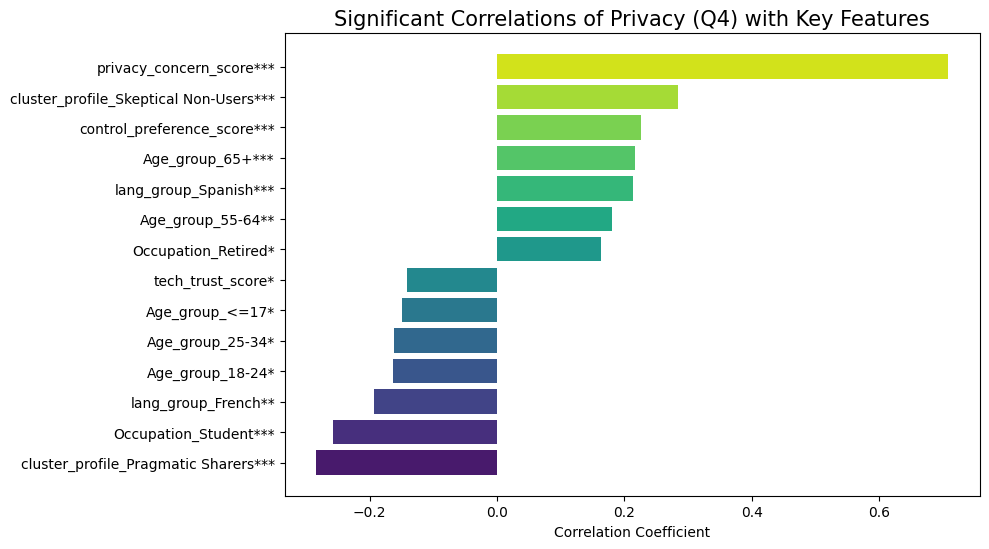

Saved correlation bar plot for Privacy (Q4) to data/img/corr\corr_4_vs_key_vars_bar.png
--- Significant Correlations for Trust (Q1) Analysis ---
+-----------------------+---------------+
| Trust (Q1)            | Correlation   |
|-----------------------+---------------|
| tech_trust_score      | 0.46***       |
| Age_group_65+         | -0.15*        |
| privacy_concern_score | -0.74***      |
+-----------------------+---------------+
Significance: * p < 0.05, ** p < 0.01, *** p < 0.001



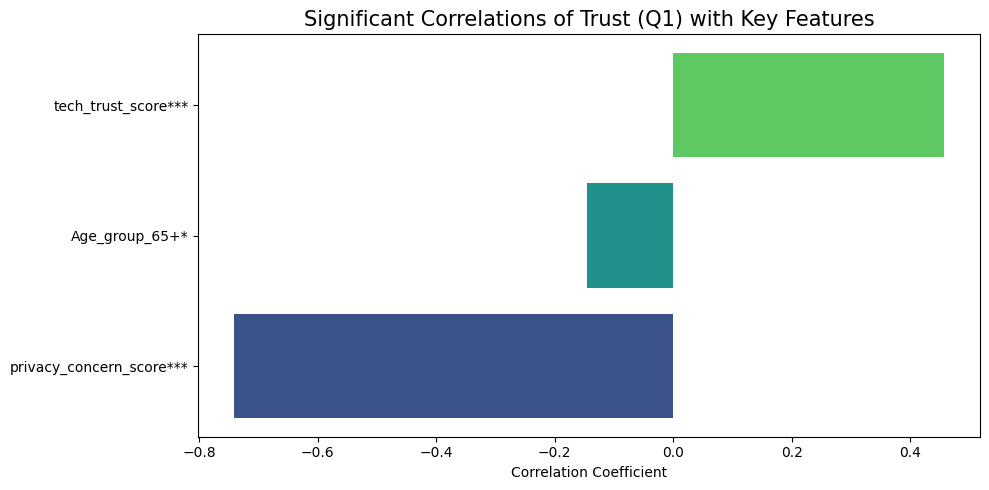

Saved correlation bar plot for Trust (Q1) to data/img/corr\corr_1_vs_key_vars_bar.png
--- Significant Correlation Matrix for Perceived Responsibility (Q19) Analysis ---
+-------------------------------------------------------------+----------------------------------------------------+-------------+----------------------------------------------+-------------+--------------+------------------+-------------+----------+---------------------------------+-----------------------------+
|                                                             | Q19_Individual users (my data my responsibility)   | Q19_etc.)   | Q19_Device manufacturers/companies (Garmin   | Q19_Apple   | Q19_Google   | Q19_Don't know   | Q19_China   | Q19_EU   | Q19_Government regulators (US   | Q19_Shared responsibility   |
|-------------------------------------------------------------+----------------------------------------------------+-------------+----------------------------------------------+-------------+----------

C:\Users\UrsHu\AppData\Local\Temp\ipykernel_32944\1622599149.py:80: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  q_dummies = q_dummies.groupby(level=0, axis=1).max()


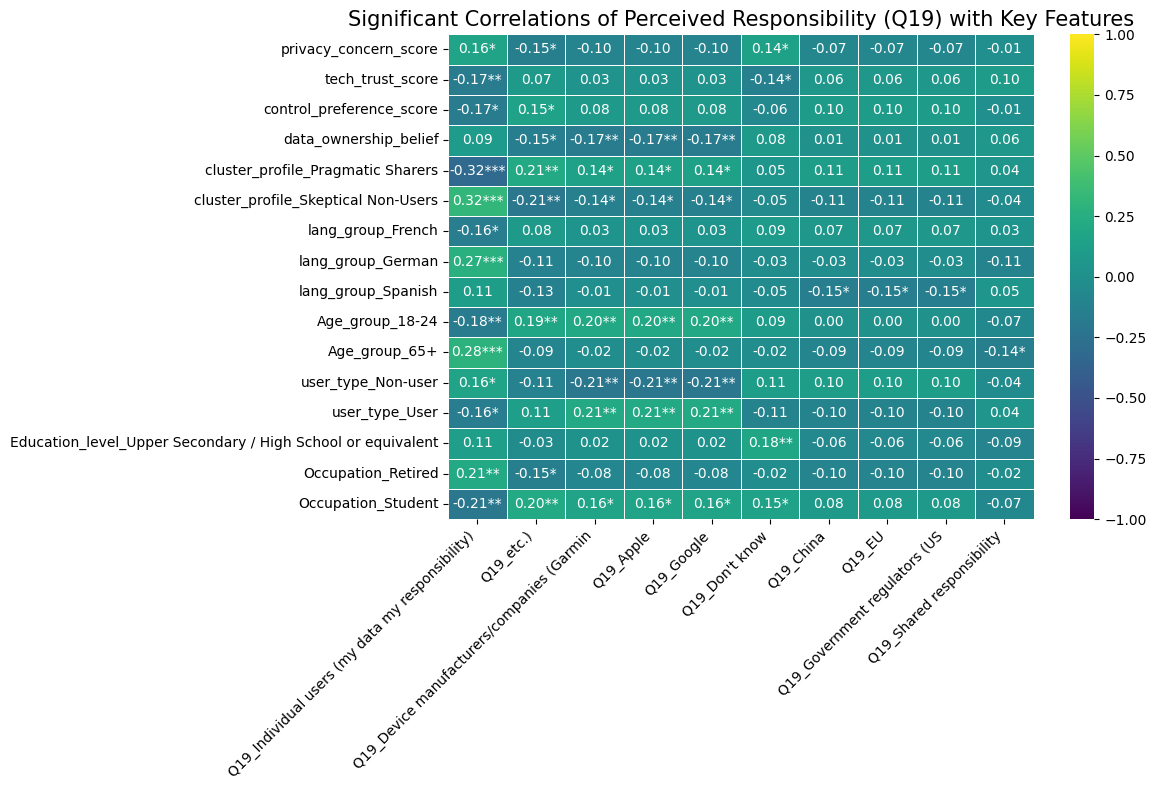

Saved correlation heatmap for Perceived Responsibility (Q19) to data/img/corr\corr_heatmap_19_vs_key_vars.png
--- Significant Correlations for Willingness to Adopt New Tech (Q12) Analysis ---
+-----------------------------------------------+---------------+
| Willingness to Adopt New Tech (Q12)           | Correlation   |
|-----------------------------------------------+---------------|
| control_preference_score                      | 0.77***       |
| tech_trust_score                              | 0.41***       |
| cluster_profile_Pragmatic Sharers             | 0.28***       |
| Age_group_25-34                               | 0.20**        |
| user_type_User                                | 0.19**        |
| Education_level_Master's degree or equivalent | 0.19**        |
| Occupation_Retired                            | -0.15*        |
| Education_level_Doctorate (PhD) or higher     | -0.17*        |
| Age_group_55-64                               | -0.17**       |
| user_type_Non-

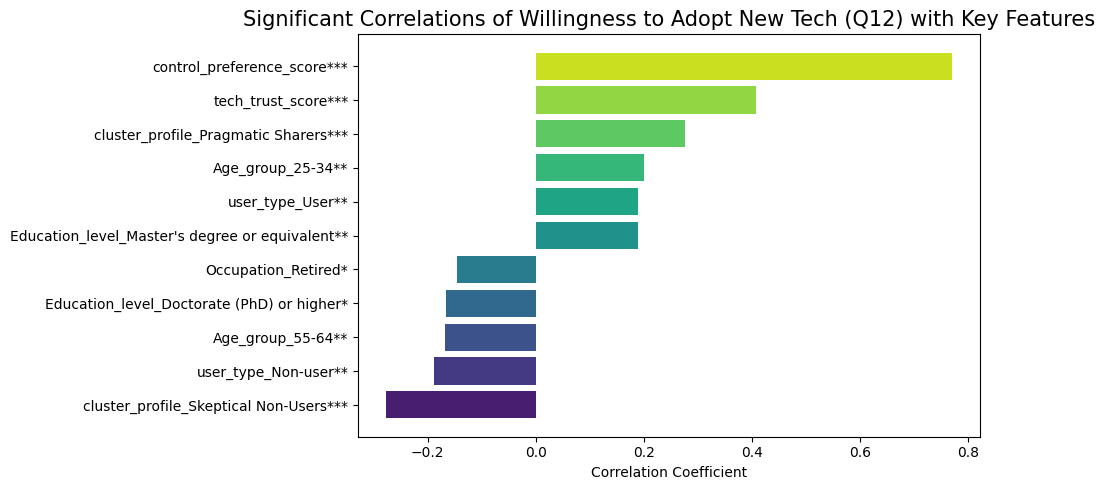

Saved correlation bar plot for Willingness to Adopt New Tech (Q12) to data/img/corr\corr_12_vs_key_vars_bar.png


In [5]:
# Plot for Q4 (privacy concern about health data privacy)
plot_corr_bar('4', 'Privacy (Q4)', df, corr_vars, corr_dir)
# Plot for Q1 (trust in centralized data handlers)
plot_corr_bar('1', 'Trust (Q1)', df, corr_vars, corr_dir)
# Plot for Q19 (perceived responsibility for ethical data use)
plot_correlation_heatmap('19', 'Perceived Responsibility (Q19)', df, corr_vars, corr_dir, is_multi_choice_text=True)

# # Plot for Q2 (actual control over data)
# plot_corr_bar('2', 'Actual Control Over Data (Q2)', df, corr_vars, corr_dir)
# # Plot for Q3 (control users should have over data)
# plot_corr_bar('3', 'Control Users Should have over Data (Q3)', df, corr_vars, corr_dir)
# # plot for q16 (belief in data ownership)
# plot_corr_bar('16', 'Belief in Data Ownership (Q16)', df, corr_vars, corr_dir)

# # plot for q17 (wilingness to share data for health insights)
# plot_corr_bar('17', 'Willingness to Share Data for Health Insights (Q17)', df, corr_vars, corr_dir)
# # plot for q18 (if no to the q17, why not?)
# plot_correlation_heatmap('18', 'Reasons for Not Sharing Data (Q18)', df, corr_vars, corr_dir, is_multi_choice_text=True)

#plot for Q10 (privacy policy reading)
# plot_correlation_heatmap('10', 'Privacy Policy Reading (Q10)', df, corr_vars, corr_dir, is_multi_choice_text=True)
# #plot for Q8 (health privacy tradeoff)
# plot_correlation_heatmap('8', 'Health Privacy Tradeoff (Q8)', df, corr_vars, corr_dir, is_multi_choice_text=True)
#plot for q5 (device usage)
# plot_correlation_heatmap('5', 'Device Usage (Q5)', df, corr_vars, corr_dir, is_multi_choice_text=True)
# #plot q9 (frequency of usage for users only)
# plot_correlation_heatmap('9', 'Frequency of Usage (Q9)', df, corr_vars, corr_dir, is_multi_choice_text=True)
# # q7 brand app usage
# plot_correlation_heatmap('7', 'Brand App Usage (Q7)', df, corr_vars, corr_dir, is_multi_choice_text=True)

# #13,11,15,20, 14
# # plot for Q11 (Awareness of New Tech)
# plot_correlation_heatmap('11', 'Awareness of New Tech (Q11)', df, corr_vars, corr_dir, is_multi_choice_text=True)
# # plot for Q13 (Trust in New Tech)
# plot_corr_bar('13', 'Trust in New Tech (Q13)', df, corr_vars, corr_dir)
# # plot for Q15 (willingness to pay)
# plot_corr_bar('15', 'Willingness to Pay for Privacy (Q15)', df, corr_vars, corr_dir)
# #plot for Q20 (expectations from new tech)
# plot_corr_bar('20', 'Expectations from New Tech (Q20)', df, corr_vars, corr_dir)
# #plot for Q14 (concern about new tech)
# plot_correlation_heatmap('14', 'Concern About New Tech (Q14)', df, corr_vars, corr_dir, is_multi_choice_text=True)
#plot for Q12 (willingness to adopt)
plot_corr_bar('12', 'Willingness to Adopt New Tech (Q12)', df, corr_vars, corr_dir)

## Regression

Correlation Matrix of Key Features:
+--------------------------+-------------------------+----------------------------+--------------------+-------------------------+--------------------+--------------------+-------------+-------------------+
|                          |   privacy_concern_score |   control_preference_score |   tech_trust_score |   data_ownership_belief |   willing_to_share |   willing_to_adopt |   age_group |   education_level |
|--------------------------+-------------------------+----------------------------+--------------------+-------------------------+--------------------+--------------------+-------------+-------------------|
| privacy_concern_score    |               1         |                  0.201788  |         -0.341309  |               0.0721658 |         -0.36929   |         -0.0804422 |    0.228316 |         0.103542  |
| control_preference_score |               0.201788  |                  1         |          0.334254  |              -0.056446  |      

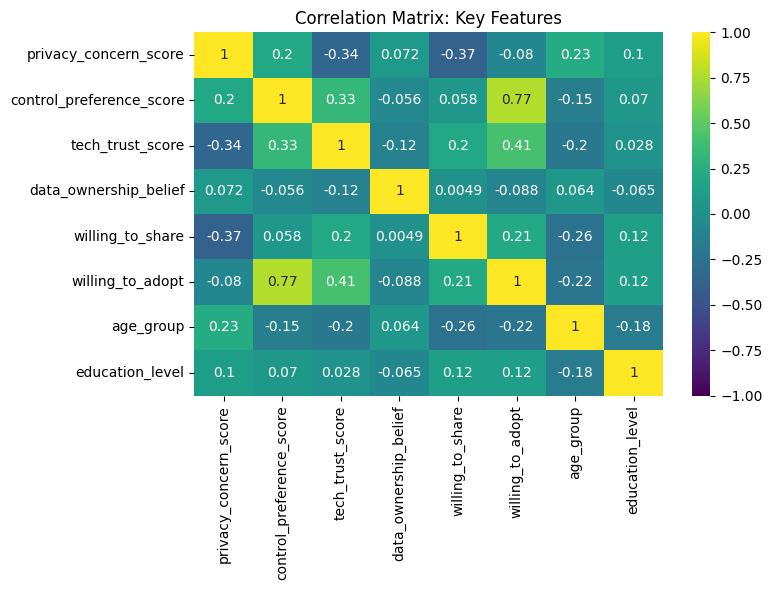


Ordinal Regression (Feature Leakage Corrected): Willingness to Adopt Decentralized Tech (Q12)
                             OrderedModel Results                             
Dep. Variable:       willing_to_adopt   Log-Likelihood:                -306.29
Model:                   OrderedModel   AIC:                             632.6
Method:            Maximum Likelihood   BIC:                             667.3
Date:                Fri, 25 Jul 2025                                         
Time:                        10:53:05                                         
No. Observations:                 238                                         
Df Residuals:                     228                                         
Df Model:                           6                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

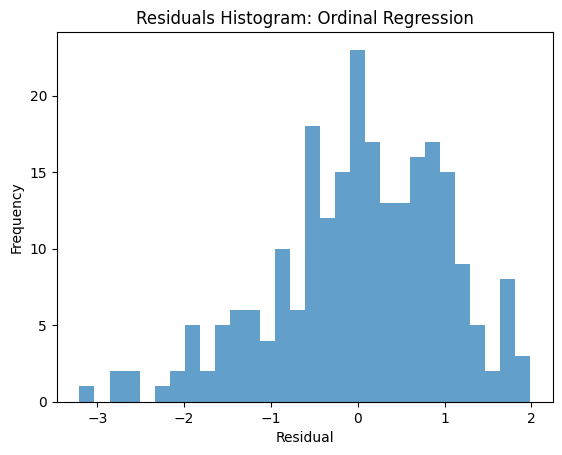


Logistic Regression: Willingness to Share Data (Q17)
                           Logit Regression Results                           
Dep. Variable:       willing_to_share   No. Observations:                  238
Model:                          Logit   Df Residuals:                      231
Method:                           MLE   Df Model:                            6
Date:                Fri, 25 Jul 2025   Pseudo R-squ.:                  0.1853
Time:                        10:53:05   Log-Likelihood:                -112.89
converged:                       True   LL-Null:                       -138.56
Covariance Type:            nonrobust   LLR p-value:                 2.537e-09
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    5.0980      1.472      3.464      0.001       2.214       7.982
privacy_concern_score       -1.5999

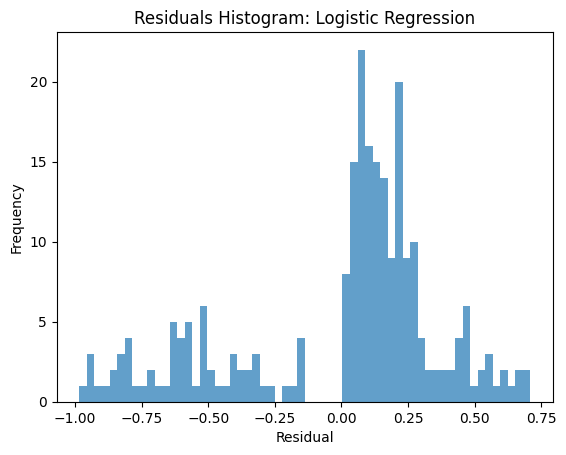


Linear Regression: Trust in Blockchain (Q13)
                            OLS Regression Results                            
Dep. Variable:       tech_trust_score   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     19.15
Date:                Fri, 25 Jul 2025   Prob (F-statistic):           6.15e-16
Time:                        10:53:05   Log-Likelihood:                -296.08
No. Observations:                 238   AIC:                             604.2
Df Residuals:                     232   BIC:                             625.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

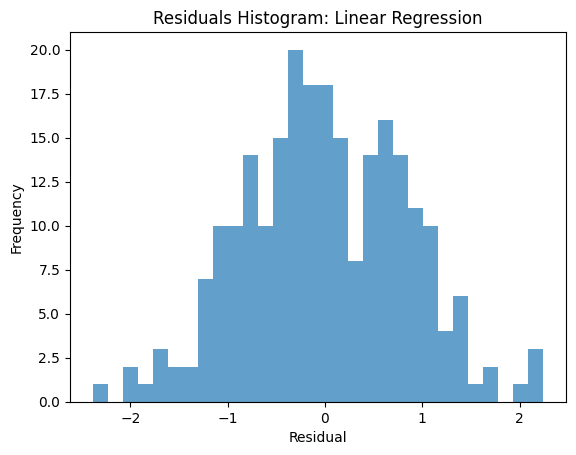


[NOTE] Interpret all results with caution due to:
- Non-representative sample (Swiss/Mexican, 25–34 age group overrepresented)
- Small subgroups for some demographics
- Potential unfamiliarity with decentralized tech questions
- Uneven language/cultural sample sizes


In [ ]:
# Load cleaned survey data
df = pd.read_excel('data/survey_cleaned.xlsx').copy()

# Prepare/encode variables
df['willing_to_share'] = df['17'].map({'Yes': 1, 'No': 0})
df['willing_to_adopt'] = pd.to_numeric(df['12'], errors='coerce')
df['tech_trust_score'] = pd.to_numeric(df['13'], errors='coerce')

age_order = [
    '<=17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+'
]
edu_order = [
    "Upper Secondary / High School or equivalent",
    "Vocational/Technical training or certificate",
    "Bachelor's degree or equivalent",
    "Master's degree or equivalent",
    "Doctorate (PhD) or higher"
]
df['age_group'] = pd.Categorical(df['22'], categories=age_order, ordered=True)
df['education_level'] = pd.Categorical(df['23'], categories=edu_order, ordered=True)

# --- 1. Correlation Matrix for Key Features ---
key_features = [
    'privacy_concern_score',
    'control_preference_score',
    'tech_trust_score',
    'data_ownership_belief',
    'willing_to_share',
    'willing_to_adopt',
    'age_group',
    'education_level'
]
corr_df = df[key_features].apply(pd.to_numeric, errors='coerce')
corr_df = df[key_features].copy()
corr_df['age_group'] = df['age_group'].cat.codes
corr_df['education_level'] = df['education_level'].cat.codes

corr_matrix = corr_df.corr()

print("Correlation Matrix of Key Features:")
print(tabulate(corr_matrix, headers='keys', tablefmt='psql'))

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', vmin=-1, vmax=1)
plt.title("Correlation Matrix: Key Features")
plt.tight_layout()
output_dir = 'data/img/corr'
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, 'features.png'), bbox_inches='tight')
plt.show()

# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
# --- VIF Analysis Function ---
def compute_vif(df, features):
    X = df[features].dropna()
    X = sm.add_constant(X)
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# --- 2. Ordinal Regression: Willingness to Adopt Decentralized Tech (Q12) using corrected feature ---
# Create a new feature: control_preference_score_clean (using Q3 and Q15 only)
df['control_preference_score_clean'] = df[['3', '15']].apply(pd.to_numeric, errors='coerce').mean(axis=1)

model_df_clean = df.dropna(subset=[
    'willing_to_adopt', 'privacy_concern_score', 'control_preference_score_clean',
    'tech_trust_score', 'data_ownership_belief', 'age_group', 'education_level'
])
model_df_clean['age_group_code'] = model_df_clean['age_group'].cat.codes
model_df_clean['education_level_code'] = model_df_clean['education_level'].cat.codes

exog_vars_clean = [
    'privacy_concern_score', 'control_preference_score_clean', 'tech_trust_score',
    'data_ownership_belief', 'age_group_code', 'education_level_code'
]
mod_clean = OrderedModel(
    model_df_clean['willing_to_adopt'],
    model_df_clean[exog_vars_clean],
    distr='logit'
)
res_clean = mod_clean.fit(method='bfgs', disp=False)
print("\nOrdinal Regression (Feature Leakage Corrected): Willingness to Adopt Decentralized Tech (Q12)")
print(res_clean.summary())

# VIF Analysis for Ordinal Regression
print("\nVIF Analysis (Ordinal Regression predictors):")
print(compute_vif(model_df_clean, exog_vars_clean))

# Compute expected values (mean prediction) for each observation
pred_probs = res_clean.model.predict(res_clean.params, exog=model_df_clean[exog_vars_clean])
expected = (pred_probs * np.arange(1, pred_probs.shape[1] + 1)).sum(axis=1)
residuals_clean = model_df_clean['willing_to_adopt'] - expected

plt.figure()
plt.hist(residuals_clean, bins=30, alpha=0.7)
plt.title("Residuals Histogram: Ordinal Regression")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

# --- 3. Logistic Regression: Willingness to Share Data (Q17) ---
logit_df = df.dropna(subset=[
    'willing_to_share', 'privacy_concern_score', 'control_preference_score',
    'tech_trust_score', 'data_ownership_belief', 'age_group', 'education_level'
])
logit_df['age_group_code'] = logit_df['age_group'].cat.codes
logit_df['education_level_code'] = logit_df['education_level'].cat.codes

logit_formula = "willing_to_share ~ privacy_concern_score + control_preference_score + tech_trust_score + data_ownership_belief + age_group_code + education_level_code"
logit_model = smf.logit(logit_formula, data=logit_df)
logit_res = logit_model.fit(disp=False)
print("\nLogistic Regression: Willingness to Share Data (Q17)")
print(logit_res.summary())

# VIF Analysis for Logistic Regression
logit_exog_vars = [
    'privacy_concern_score', 'control_preference_score', 'tech_trust_score',
    'data_ownership_belief', 'age_group_code', 'education_level_code'
]
print("\nVIF Analysis (Logistic Regression predictors):")
print(compute_vif(logit_df, logit_exog_vars))

# Residual Diagnostics for Logistic Regression
logit_residuals = logit_res.resid_response
plt.figure()
plt.hist(logit_residuals, bins=30, alpha=0.7)
plt.title("Residuals Histogram: Logistic Regression")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

# --- 4. Linear Regression: Trust in Blockchain (Q13) ---
linreg_df = df.dropna(subset=[
    'tech_trust_score', 'privacy_concern_score', 'control_preference_score',
    'data_ownership_belief', 'age_group', 'education_level'
])
linreg_df['age_group_code'] = linreg_df['age_group'].cat.codes
linreg_df['education_level_code'] = linreg_df['education_level'].cat.codes

linreg_formula = "tech_trust_score ~ privacy_concern_score + control_preference_score + data_ownership_belief + age_group_code + education_level_code"
linreg_model = smf.ols(linreg_formula, data=linreg_df)
linreg_res = linreg_model.fit()
print("\nLinear Regression: Trust in Blockchain (Q13)")
print(linreg_res.summary())

# VIF Analysis for Linear Regression
linreg_exog_vars = [
    'privacy_concern_score', 'control_preference_score', 'data_ownership_belief',
    'age_group_code', 'education_level_code'
]
print("\nVIF Analysis (Linear Regression predictors):")
print(compute_vif(linreg_df, linreg_exog_vars))

# Residual Diagnostics for Linear Regression
linreg_residuals = linreg_res.resid
plt.figure()
plt.hist(linreg_residuals, bins=30, alpha=0.7)
plt.title("Residuals Histogram: Linear Regression")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

# --- Notes on Limitations ---
print("\n[NOTE] Interpret all results with caution due to:")
print("- Non-representative sample (Swiss/Mexican, 25–34 age group overrepresented)")
print("- Small subgroups for some demographics")
print("- Potential unfamiliarity with decentralized tech questions")
print("- Uneven language/cultural sample sizes")

## Cluster analysis/segmentation

### 3 clusters

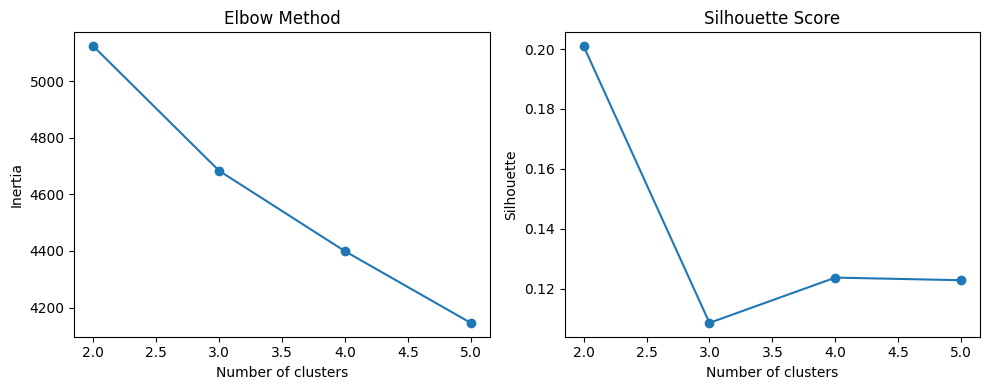

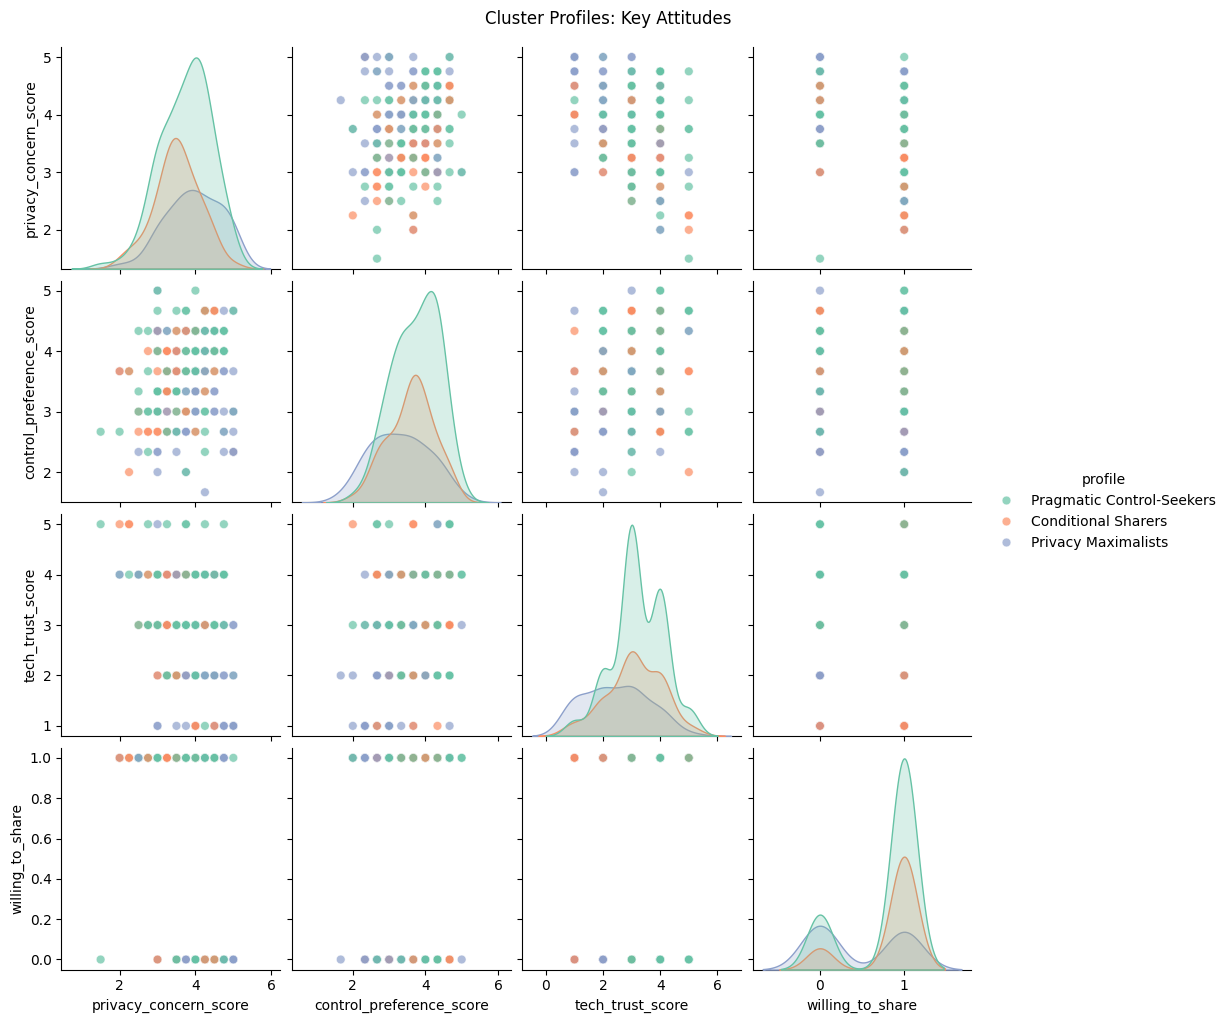


Cluster 0 (Conditional Sharers):
privacy_concern_score       3.515873
control_preference_score    3.597884
tech_trust_score            3.095238
data_ownership_belief       3.603175
willing_to_share            0.841270
education_level             2.349206
user_Non-user               0.349206
user_User                   0.650794
lang_English                0.222222
lang_French                 0.682540
lang_German                 0.015873
lang_Spanish                0.079365
age_18-24                   0.460317
age_25-34                   0.523810
age_35-44                   0.000000
age_45-54                   0.000000
age_55-64                   0.000000
age_65+                     0.000000
age_<=17                    0.015873
occupation_Employed         0.000000
occupation_Retired          0.000000
occupation_Self-employed    0.000000
occupation_Student          1.000000
occupation_Unemployed       0.000000
Name: 0, dtype: float64
Size: 63
- Stance: Highest willingness to share, condi

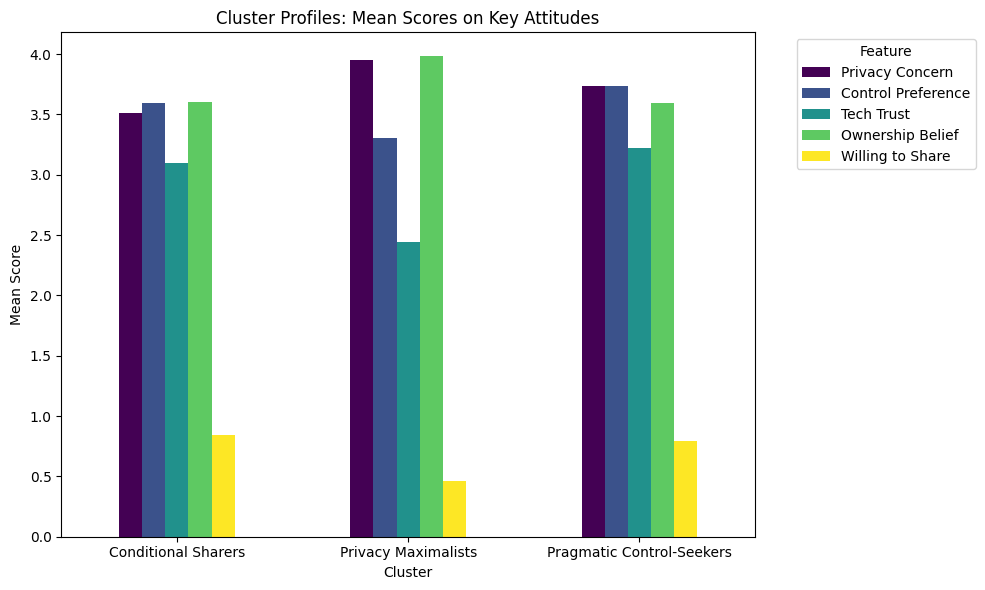


--- ANOVA: Testing for Significant Differences in Continuous Features ---
+--------------------------+---------------+-----------+----------------+
| Feature                  |   F-statistic |   p-value | Significant?   |
|--------------------------+---------------+-----------+----------------|
| privacy_concern_score    |        6.2133 |    0.0023 | Yes (p < 0.05) |
| control_preference_score |        7.8199 |    0.0005 | Yes (p < 0.05) |
| tech_trust_score         |       12.7678 |    0      | Yes (p < 0.05) |
| data_ownership_belief    |        1.2015 |    0.3026 | No (p >= 0.05) |
| willing_to_share         |       14.4264 |    0      | Yes (p < 0.05) |
+--------------------------+---------------+-----------+----------------+


--- Chi-Squared: Testing for Significant Differences in Categorical Features ---
+-----------------+---------------+-----------+----------------+
| Feature         |   Chi-Squared |   p-value | Significant?   |
|-----------------+---------------+-----------

In [11]:
# --- 1. Prepare Data for Clustering ---
# Use the same cleaned data and derived features as in previous analyses
df = pd.read_excel('data/survey_cleaned.xlsx').copy()

# Prepare/encode variables
#read the cleaned survey data
survey_cleaned = pd.read_excel('data/survey_cleaned.xlsx')
df = survey_cleaned.copy()

# Willingness to share (Q17: Yes=1, No=0)
df['willing_to_share'] = df['17'].map({'Yes': 1, 'No': 0})

# Trust in blockchain (Q13: 1-5 Likert)
df['tech_trust_score'] = pd.to_numeric(df['13'], errors='coerce')

# Select core numeric features for clustering
cluster_features = [
    'privacy_concern_score',
    'control_preference_score',
    'tech_trust_score',
    'data_ownership_belief',
    'willing_to_share'
]

# --- Encode Ordinal and Nominal Features ---

# 1. Ordinal Features: Encode using ordered categories (Education Level)
edu_order = [
    "Upper Secondary / High School or equivalent",
    "Vocational/Technical training or certificate",
    "Bachelor's degree or equivalent",
    "Master's degree or equivalent",
    "Doctorate (PhD) or higher"
]
df['education_level'] = pd.Categorical(df['23'], categories=edu_order, ordered=True).codes
cluster_features.append('education_level')


# 2. Nominal Features: One-hot encode to create separate binary columns for interpretation
# We use drop_first=False to make cluster profiles more explicit and readable.
nominal_cols_to_encode = {
    'user_type': 'user',
    'lang_group': 'lang',
    '22': 'age',         # Age Group
    '24': 'occupation'  # Occupation
}
for col, prefix in nominal_cols_to_encode.items():
    if col in df.columns:
        # Using drop_first=False to get all dummy variables for better interpretation
        dummies = pd.get_dummies(df[col], prefix=prefix, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
        cluster_features += list(dummies.columns)

# Drop rows with missing values in any of the selected features
cluster_df = df[cluster_features].dropna()

# Standardize features for clustering
scaler = StandardScaler()
X = scaler.fit_transform(cluster_df)

# --- 2. Determine Optimal Number of Clusters (Elbow & Silhouette) ---
inertia = []
silhouette = []
K_range = range(2, 6)  # Limit to 2-5 clusters for interpretability and sample size
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X, labels))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.subplot(1,2,2)
plt.plot(K_range, silhouette, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette')
plt.tight_layout()
plt.show()

# --- 3. Fit KMeans with Chosen Number of Clusters (n=3) ---
# Based on the elbow/silhouette plot and interpretability, 3 clusters is optimal
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X)
cluster_df['cluster'] = cluster_labels

# --- 4. Assign Descriptive Cluster Names Based on Profiles ---
# Use actual means and interpretation from your summary
profile_map = {
    0: "Conditional Sharers",
    1: "Privacy Maximalists",
    2: "Pragmatic Control-Seekers"
}
cluster_df['profile'] = cluster_df['cluster'].map(profile_map)

# --- 5. Visualize Clusters (Pairplot) ---
sns.pairplot(
    cluster_df,
    vars=['privacy_concern_score', 'control_preference_score', 'tech_trust_score', 'willing_to_share'],
    hue='profile',
    palette='Set2',
    plot_kws={'alpha': 0.7, 's': 40}
)
plt.suptitle("Cluster Profiles: Key Attitudes", y=1.02)
plt.show()

# --- 6. Output: Cluster Interpretation ---
profile_summary = cluster_df.groupby('cluster').mean(numeric_only=True)
profile_counts = cluster_df['cluster'].value_counts().sort_index()
for c in sorted(profile_map):
    print(f"\nCluster {c} ({profile_map[c]}):")
    print(profile_summary.loc[c])
    print(f"Size: {profile_counts[c]}")
    if c == 0:
        print("- Stance: Highest willingness to share, conditional on having high control and ownership. Demographically, this is the youngest group (students).")
    elif c == 1:
        print("- Stance: Highest privacy concern, lowest trust, and lowest willingness to share. Demographically, this is the oldest group (non-users).")
    elif c == 2:
        print("- Stance: Highest preference for control. High privacy concern but also high willingness to share, suggesting a pragmatic approach. Demographically, this is the largest group (employed adults).")

print("\n[NOTE] Interpret clusters with caution due to:")
print("- Non-representative sample (Swiss/Mexican, 25–34 age group overrepresented)")
print("- Small subgroups for some demographics")
print("- Potential unfamiliarity with decentralized tech questions")
print("- Uneven language/cultural sample sizes")
print("- See Limitations section for details.")

# --- 7. Easy-to-Understand Cluster Bar Plot ---
# Show mean values of key features for each cluster
feature_labels = [
    'Privacy Concern',
    'Control Preference',
    'Tech Trust',
    'Ownership Belief',
    'Willing to Share'
]
means = profile_summary[['privacy_concern_score', 'control_preference_score', 'tech_trust_score', 'data_ownership_belief', 'willing_to_share']]
means.columns = feature_labels

ax = means.plot(kind='bar', figsize=(10,6), colormap='viridis')
plt.title('Cluster Profiles: Mean Scores on Key Attitudes')
plt.xlabel('Cluster')
plt.ylabel('Mean Score')
plt.xticks(ticks=range(n_clusters), labels=[profile_map[i] for i in range(n_clusters)], rotation=0)
plt.legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
# SAVE the plot image in data/img/cluster folder BEFORE plt.show()
plt.savefig('data/img/cluster/cluster_profiles_bar_plot_3_clust.png', bbox_inches='tight')
plt.show()

## add cluster profile to the cleaned data and saved it
survey_cleaned['cluster_profile'] = cluster_df['profile']
survey_cleaned.to_excel('data/survey_cleaned.xlsx', index=False)

# --- 8. Statistical Significance of Cluster Differences (ANOVA & Chi-Squared) ---
from scipy.stats import f_oneway, chi2_contingency
from tabulate import tabulate

print("\n--- ANOVA: Testing for Significant Differences in Continuous Features ---")

# Continuous features to test (the core of the clustering)
continuous_features_to_test = [
    'privacy_concern_score',
    'control_preference_score',
    'tech_trust_score',
    'data_ownership_belief',
    'willing_to_share'
]

anova_results = []
for feature in continuous_features_to_test:
    groups = [cluster_df[feature][cluster_df['cluster'] == i] for i in range(n_clusters)]
    f_statistic, p_value = f_oneway(*groups)
    significance = "Yes (p < 0.05)" if p_value < 0.05 else "No (p >= 0.05)"
    anova_results.append([feature, f"{f_statistic:.4f}", f"{p_value:.4f}", significance])

print(tabulate(anova_results, headers=['Feature', 'F-statistic', 'p-value', 'Significant?'], tablefmt='psql'))


print("\n\n--- Chi-Squared: Testing for Significant Differences in Categorical Features ---")

# Categorical features to test (demographics used in clustering)
# We use the original columns from the main dataframe before one-hot encoding
categorical_features_to_test = {
    'user_type': 'User Type',
    'lang_group': 'Language Group',
    '22': 'Age Group',
    '23': 'Education Level',
    '24': 'Occupation'
}

# Add the cluster assignments back to the original dataframe for testing
# Ensure indices align by using the index from cluster_df
df.loc[cluster_df.index, 'cluster'] = cluster_df['cluster']

chi2_results = []
for col, name in categorical_features_to_test.items():
    if col in df.columns:
        # Create a contingency table (crosstab)
        contingency_table = pd.crosstab(df['cluster'], df[col])
        
        # Perform Chi-squared test
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        significance = "Yes (p < 0.05)" if p < 0.05 else "No (p >= 0.05)"
        chi2_results.append([name, f"{chi2:.4f}", f"{p:.4f}", significance])

print(tabulate(chi2_results, headers=['Feature', 'Chi-Squared', 'p-value', 'Significant?'], tablefmt='psql'))


### two clusters

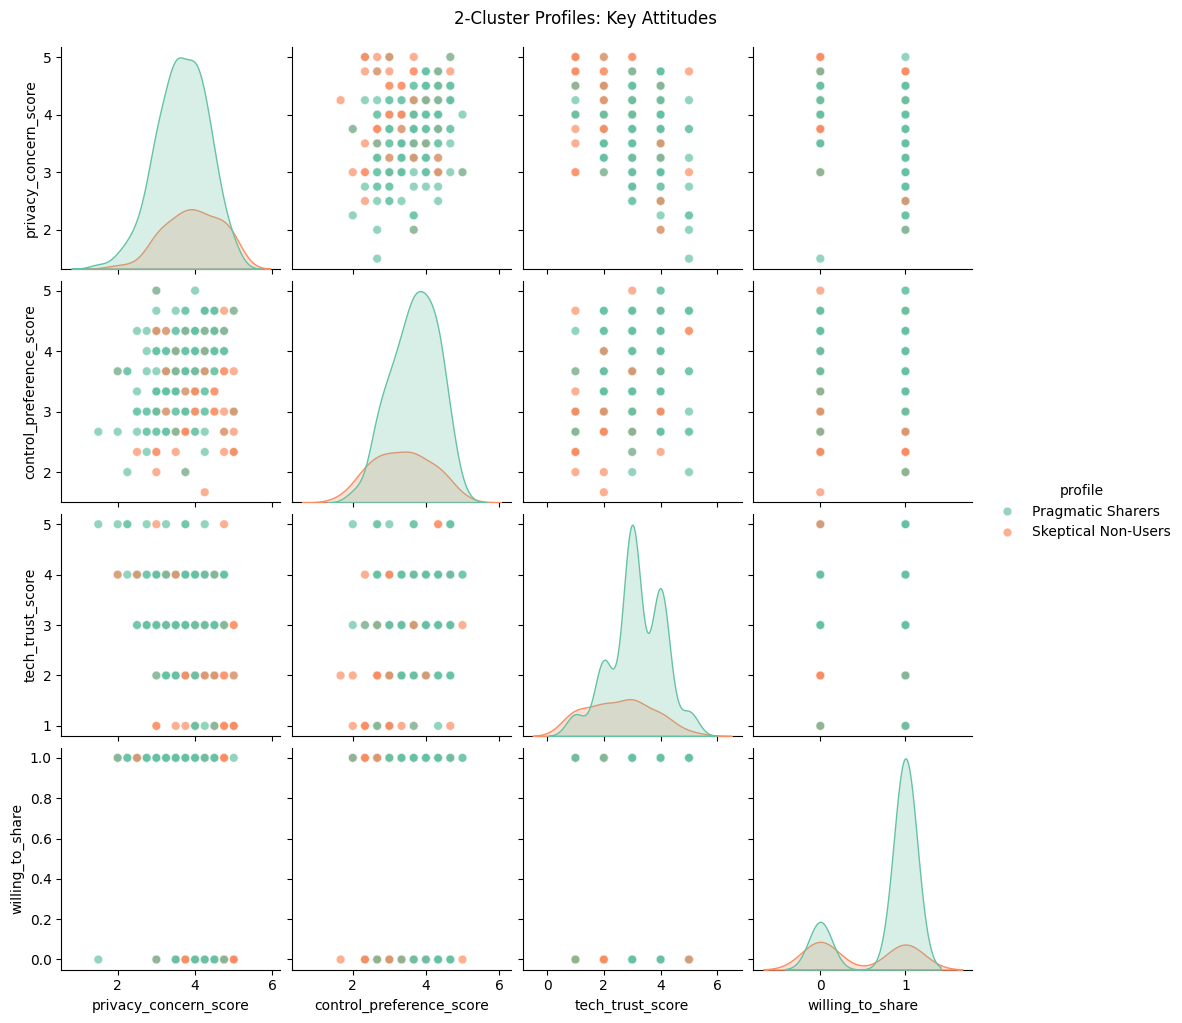


Cluster 0 (Skeptical Non-Users):
privacy_concern_score       3.936441
control_preference_score    3.350282
tech_trust_score            2.559322
data_ownership_belief       3.966102
willing_to_share            0.474576
education_level             1.644068
user_Non-user               0.677966
user_User                   0.322034
lang_English                0.016949
lang_French                 0.169492
lang_German                 0.355932
lang_Spanish                0.457627
age_18-24                   0.000000
age_25-34                   0.033898
age_35-44                   0.067797
age_45-54                   0.305085
age_55-64                   0.423729
age_65+                     0.152542
age_<=17                    0.016949
occupation_Employed         0.508475
occupation_Retired          0.169492
occupation_Self-employed    0.288136
occupation_Student          0.000000
occupation_Unemployed       0.033898
Name: 0, dtype: float64
Size: 59
- Stance: Highest privacy concern, lowest tru

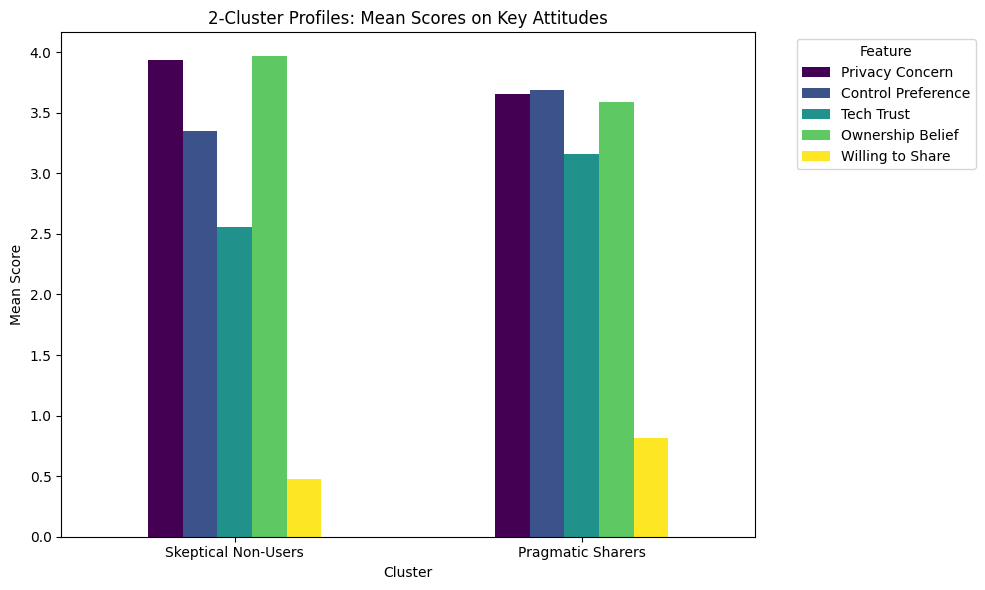


--- ANOVA: Testing for Significant Differences in Continuous Features (2 Clusters) ---
+--------------------------+---------------+-----------+----------------+
| Feature                  |   F-statistic |   p-value | Significant?   |
|--------------------------+---------------+-----------+----------------|
| privacy_concern_score    |        7.599  |    0.0063 | Yes (p < 0.05) |
| control_preference_score |       10.8124 |    0.0012 | Yes (p < 0.05) |
| tech_trust_score         |       17.2243 |    0      | Yes (p < 0.05) |
| data_ownership_belief    |        2.4356 |    0.1199 | No (p >= 0.05) |
| willing_to_share         |       29.2638 |    0      | Yes (p < 0.05) |
+--------------------------+---------------+-----------+----------------+


--- Chi-Squared: Testing for Significant Differences in Categorical Features (2 Clusters) ---
+-----------------+---------------+-----------+----------------+
| Feature         |   Chi-Squared |   p-value | Significant?   |
|-----------------+-

In [12]:
# --- 1. Prepare Data for Clustering (2 Clusters) ---
# This section reuses the same data preparation steps as the 3-cluster analysis.
df_2c = pd.read_excel('data/survey_cleaned.xlsx').copy()

# Willingness to share (Q17: Yes=1, No=0)
df_2c['willing_to_share'] = df_2c['17'].map({'Yes': 1, 'No': 0})

# Trust in blockchain (Q13: 1-5 Likert)
df_2c['tech_trust_score'] = pd.to_numeric(df_2c['13'], errors='coerce')

# Select core numeric features for clustering
cluster_features_2c = [
    'privacy_concern_score',
    'control_preference_score',
    'tech_trust_score',
    'data_ownership_belief',
    'willing_to_share'
]

# --- Encode Ordinal and Nominal Features ---
edu_order = [
    "Upper Secondary / High School or equivalent",
    "Vocational/Technical training or certificate",
    "Bachelor's degree or equivalent",
    "Master's degree or equivalent",
    "Doctorate (PhD) or higher"
]
df_2c['education_level'] = pd.Categorical(df_2c['23'], categories=edu_order, ordered=True).codes
cluster_features_2c.append('education_level')

nominal_cols_to_encode = {
    'user_type': 'user',
    'lang_group': 'lang',
    '22': 'age',
    '24': 'occupation'
}
for col, prefix in nominal_cols_to_encode.items():
    if col in df_2c.columns:
        dummies = pd.get_dummies(df_2c[col], prefix=prefix, drop_first=False)
        df_2c = pd.concat([df_2c, dummies], axis=1)
        cluster_features_2c += list(dummies.columns)

# Drop rows with missing values and create a new DataFrame for this analysis
cluster_df_2c = df_2c[cluster_features_2c].dropna()

# Standardize features for clustering
scaler_2c = StandardScaler()
X_2c = scaler_2c.fit_transform(cluster_df_2c)

# --- 2. Fit KMeans with n=2 Clusters ---
n_clusters_2c = 2
kmeans_2c = KMeans(n_clusters=n_clusters_2c, random_state=42, n_init=10)
cluster_labels_2c = kmeans_2c.fit_predict(X_2c)
cluster_df_2c['cluster'] = cluster_labels_2c

# --- 3. Assign Descriptive Cluster Names Based on Profiles ---
profile_map_2c = {
    0: "Skeptical Non-Users",
    1: "Pragmatic Sharers"
}
cluster_df_2c['profile'] = cluster_df_2c['cluster'].map(profile_map_2c)


# --- 4. Visualize Clusters (Pairplot) ---
sns.pairplot(
    cluster_df_2c,
    vars=['privacy_concern_score', 'control_preference_score', 'tech_trust_score', 'willing_to_share'],
    hue='profile',
    palette='Set2',
    plot_kws={'alpha': 0.7, 's': 40}
)
plt.suptitle("2-Cluster Profiles: Key Attitudes", y=1.02)
plt.show()

# --- 5. Output: Cluster Interpretation ---
profile_summary_2c = cluster_df_2c.groupby('cluster').mean(numeric_only=True)
profile_counts_2c = cluster_df_2c['cluster'].value_counts().sort_index()
for c in sorted(profile_map_2c):
    print(f"\nCluster {c} ({profile_map_2c[c]}):")
    print(profile_summary_2c.loc[c])
    print(f"Size: {profile_counts_2c[c]}")
    if c == 0:
        print("- Stance: Highest privacy concern, lowest trust in technology, and lowest willingness to share data. This group is predominantly composed of older, non-users of connected devices.")
    elif c == 1:
        print("- Stance: High willingness to share data, balanced with a strong preference for control and moderate trust. This group consists mainly of younger, active users of connected devices.")

# --- Add 2-Cluster Profile to Cleaned Data and Save ---
# Load the original cleaned data to ensure we are updating the correct file
survey_cleaned_for_update = pd.read_excel('data/survey_cleaned.xlsx')
# Assign the 2-cluster profile using the index to align rows correctly
survey_cleaned_for_update['cluster_profile'] = cluster_df_2c['profile']
# Save the updated DataFrame back to the Excel file
survey_cleaned_for_update.to_excel('data/survey_cleaned.xlsx', index=False)
print("\nUpdated 'data/survey_cleaned.xlsx' with a new 'cluster_profile' column.")

# --- 6. Easy-to-Understand Cluster Bar Plot ---
feature_labels = [
    'Privacy Concern',
    'Control Preference',
    'Tech Trust',
    'Ownership Belief',
    'Willing to Share'
]
means_2c = profile_summary_2c[['privacy_concern_score', 'control_preference_score', 'tech_trust_score', 'data_ownership_belief', 'willing_to_share']]
means_2c.columns = feature_labels

ax = means_2c.plot(kind='bar', figsize=(10,6), colormap='viridis')
plt.title('2-Cluster Profiles: Mean Scores on Key Attitudes')
plt.xlabel('Cluster')
plt.ylabel('Mean Score')
plt.xticks(ticks=range(n_clusters_2c), labels=[profile_map_2c[i] for i in range(n_clusters_2c)], rotation=0)
plt.legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('data/img/cluster/cluster_profiles_bar_plot_2_clust.png', bbox_inches='tight')
plt.show()


# --- 7. Statistical Significance of Cluster Differences (ANOVA & Chi-Squared) ---
print("\n--- ANOVA: Testing for Significant Differences in Continuous Features (2 Clusters) ---")

continuous_features_to_test = [
    'privacy_concern_score',
    'control_preference_score',
    'tech_trust_score',
    'data_ownership_belief',
    'willing_to_share'
]

anova_results_2c = []
for feature in continuous_features_to_test:
    groups = [cluster_df_2c[feature][cluster_df_2c['cluster'] == i] for i in range(n_clusters_2c)]
    f_statistic, p_value = f_oneway(*groups)
    significance = "Yes (p < 0.05)" if p_value < 0.05 else "No (p >= 0.05)"
    anova_results_2c.append([feature, f"{f_statistic:.4f}", f"{p_value:.4f}", significance])

print(tabulate(anova_results_2c, headers=['Feature', 'F-statistic', 'p-value', 'Significant?'], tablefmt='psql'))


print("\n\n--- Chi-Squared: Testing for Significant Differences in Categorical Features (2 Clusters) ---")

categorical_features_to_test = {
    'user_type': 'User Type',
    'lang_group': 'Language Group',
    '22': 'Age Group',
    '23': 'Education Level',
    '24': 'Occupation'
}

# Add the cluster assignments back to the original dataframe for testing
df_2c.loc[cluster_df_2c.index, 'cluster'] = cluster_df_2c['cluster']

chi2_results_2c = []
for col, name in categorical_features_to_test.items():
    if col in df_2c.columns:
        contingency_table = pd.crosstab(df_2c['cluster'], df_2c[col])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        significance = "Yes (p < 0.05)" if p < 0.05 else "No (p >= 0.05)"
        chi2_results_2c.append([name, f"{chi2:.4f}", f"{p:.4f}", significance])

print(tabulate(chi2_results_2c, headers=['Feature', 'Chi-Squared', 'p-value', 'Significant?'], tablefmt='psql'))


## Factor Analysis / PCA

Likert Questions:
Q1: How much do you trust current centralized systems (where companies store and manage your data) to protect your health information?
Q2: How much control do you feel you have over your data? 
Q3: How much control do you feel users should have over their own health data?
Q4: How concerned are you about health data privacy?
Q12: If these systems allowed you to control who accesses your health data and how it's used, would you be interested in using them? 
Q13: How much trust do you have in systems based on new technologies (like blockchain) to protect your data? 
Q15: How willing would you be to invest extra time or pay an additional fee to use a decentralized data management solution (such as a blockchain-based system or personal data vault) that gives you full control over your wearable health data?
Q16: Should users own their wearable data?
Q20: Do you think those new methods to manage personal data will become mainstream in 5–10 years?
Factor Loadings (Varimax, 3 

c:\Users\UrsHu\Proton Drive\ualh\My files\Documents\Learn\Academic\Semestre 4\Thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


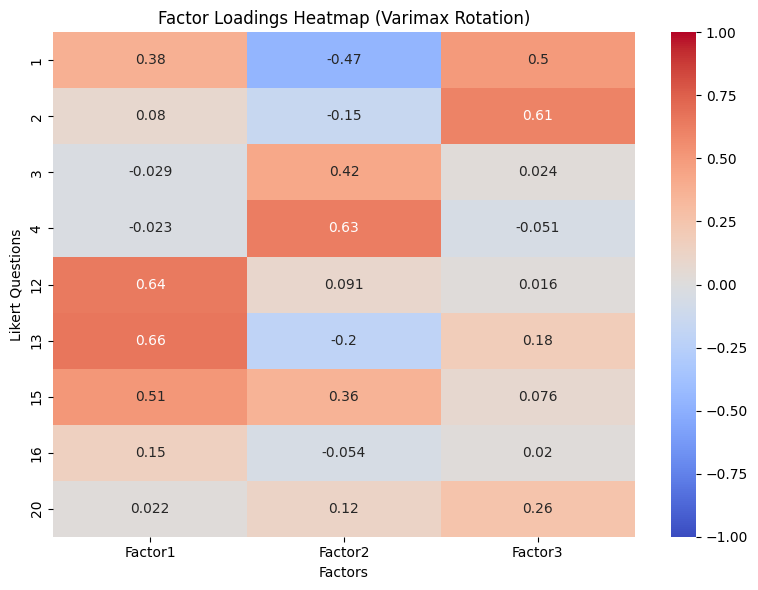

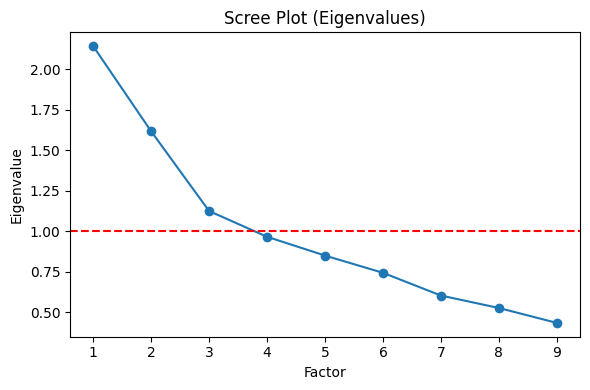


PCA Explained Variance (first 3 components): 0.24, 0.18, 0.12


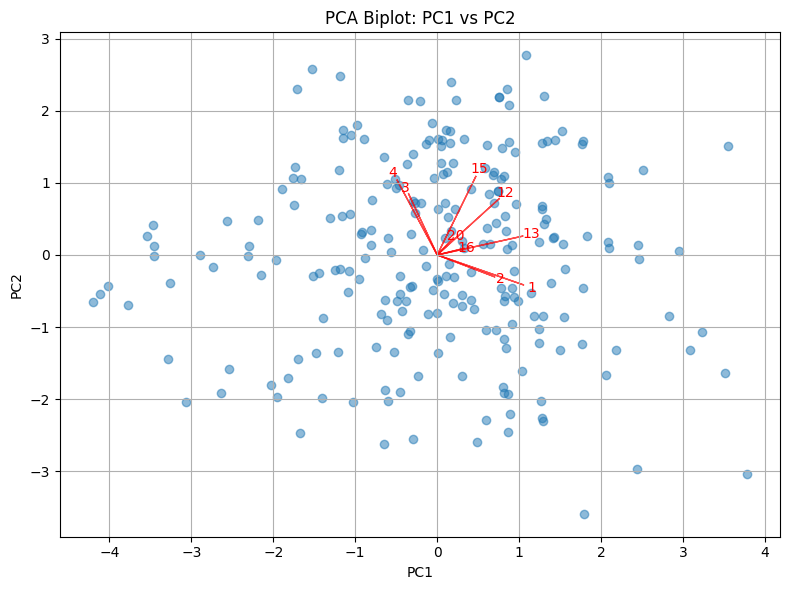

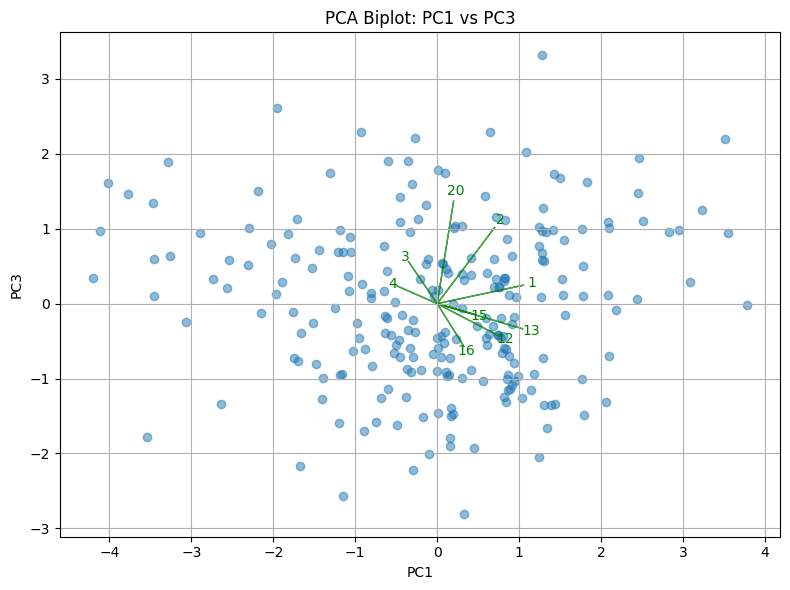

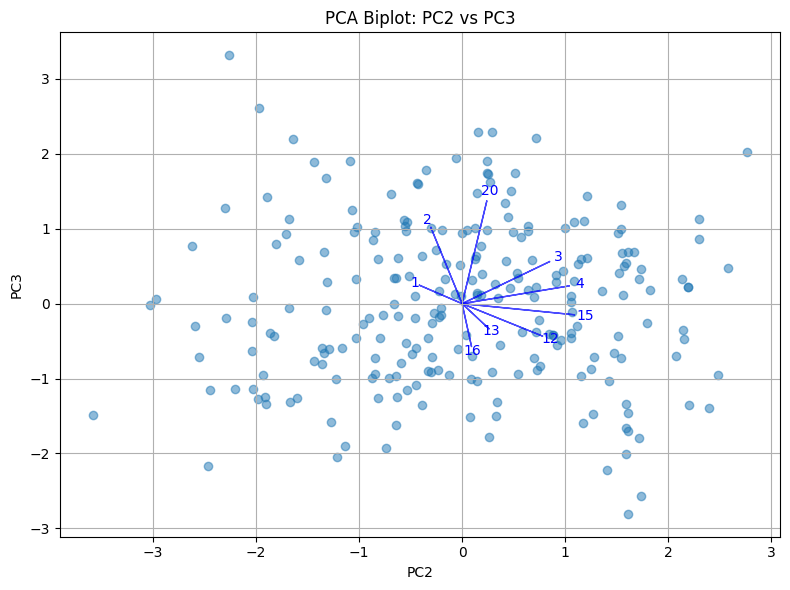


[NOTE] Factor analysis and PCA are exploratory and should be interpreted with caution due to sample limitations (see Limitations section).


In [59]:
# 1. Prepare Likert-scale data for EFA/PCA
likert_cols = ['1', '2', '3', '4', '12', '13', '15', '16', '20']
#print questions text from survey_question
print("Likert Questions:")
for col in likert_cols:
    question_row = questions_data[questions_data['quest_id'] == int(col)]
    if not question_row.empty:
        print(f"Q{col}: {question_row['question_descr'].values[0]}")
    else:
        print(f"Q{col}: No description found")
df = pd.read_excel('data/survey_cleaned.xlsx')
likert_df = df[likert_cols].apply(pd.to_numeric, errors='coerce').dropna()

# Standardize for PCA
scaler = StandardScaler()
likert_scaled = scaler.fit_transform(likert_df)

# 2. Exploratory Factor Analysis (EFA)
fa = FactorAnalyzer(n_factors=3, rotation='varimax')
fa.fit(likert_df)
loadings = pd.DataFrame(fa.loadings_, index=likert_cols, columns=['Factor1', 'Factor2', 'Factor3'])
print("Factor Loadings (Varimax, 3 factors):")
print(loadings)
#factor loading heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Factor Loadings Heatmap (Varimax Rotation)')
plt.xlabel('Factors')
plt.ylabel('Likert Questions')
plt.tight_layout()
# Save factor loadings heatmap in data/img/factor_analysis folder
save_heatmap_fname = 'data/img/factor_analysis/factor_loadings_heatmap.png'
plt.savefig(save_heatmap_fname, bbox_inches='tight')
plt.show()


# Scree plot for number of factors
ev, v = fa.get_eigenvalues()
plt.figure(figsize=(6,4))
plt.plot(range(1, len(ev)+1), ev, marker='o')
plt.title('Scree Plot (Eigenvalues)')
plt.xlabel('Factor')
plt.ylabel('Eigenvalue')
plt.axhline(1, color='red', linestyle='--')
plt.tight_layout()
plt.savefig('data/img/factor_analysis/scree_plot.png', bbox_inches='tight')
plt.show()

# 3. Principal Component Analysis (PCA) with 3 components
pca = PCA(n_components=3)
pca_result = pca.fit_transform(likert_scaled)
explained_var = pca.explained_variance_ratio_

print(f"\nPCA Explained Variance (first 3 components): {explained_var[0]:.2f}, {explained_var[1]:.2f}, {explained_var[2]:.2f}")

# Biplot: PC1 vs PC2
plt.figure(figsize=(8,6))
plt.scatter(pca_result[:,0], pca_result[:,1], alpha=0.5, label='Respondents')
for i, var in enumerate(likert_cols):
    plt.arrow(0, 0, pca.components_[0,i]*2, pca.components_[1,i]*2, color='r', alpha=0.7)
    plt.text(pca.components_[0,i]*2.2, pca.components_[1,i]*2.2, var, color='r', ha='center', va='center')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Biplot: PC1 vs PC2')
plt.grid(True)
plt.tight_layout()
# Save the biplot in data/img/factor_analysis folder
save_biplot_fname = 'data/img/factor_analysis/pca_biplot_pc1_vs_pc2.png'
plt.savefig(save_biplot_fname, bbox_inches='tight')
plt.show()

# Biplot: PC1 vs PC3
plt.figure(figsize=(8,6))
plt.scatter(pca_result[:,0], pca_result[:,2], alpha=0.5, label='Respondents')
for i, var in enumerate(likert_cols):
    plt.arrow(0, 0, pca.components_[0,i]*2, pca.components_[2,i]*2, color='g', alpha=0.7)
    plt.text(pca.components_[0,i]*2.2, pca.components_[2,i]*2.2, var, color='g', ha='center', va='center')
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.title('PCA Biplot: PC1 vs PC3')
plt.grid(True)
plt.tight_layout()
plt.savefig('data/img/factor_analysis/pca_biplot_pc1_vs_pc3.png', bbox_inches='tight')
plt.show()

# Biplot: PC2 vs PC3
plt.figure(figsize=(8,6))
plt.scatter(pca_result[:,1], pca_result[:,2], alpha=0.5, label='Respondents')
for i, var in enumerate(likert_cols):
    plt.arrow(0, 0, pca.components_[1,i]*2, pca.components_[2,i]*2, color='b', alpha=0.7)
    plt.text(pca.components_[1,i]*2.2, pca.components_[2,i]*2.2, var, color='b', ha='center', va='center')
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.title('PCA Biplot: PC2 vs PC3')
plt.grid(True)
plt.tight_layout()
plt.savefig('data/img/factor_analysis/pca_biplot_pc2_vs_pc3.png', bbox_inches='tight')
plt.show()


# 4. Interpretation
print("\n[NOTE] Factor analysis and PCA are exploratory and should be interpreted with caution due to sample limitations (see Limitations section).")


Factor	Main Items (High Loadings)	Theme/Interpretation
Factor 1	12, 13, 15	Openness to and Trust in Decentralized Data Solutions
Factor 2	3, 4, (15)	Privacy Concerns and Desire for User Control
Factor 3	1, 2	Trust and Perceived Control in Current Systems

## Barriers and Drivers Analysis

Raw table: Frequency of each cited barrier


,Barrier,Number of Respondents
0,Uncertain security/reliability,120
1,Time required to manage my data,100
2,Complexity/difficulty of use,97
3,Cost of implementation,81
4,Integration with existing devices,48


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_12928\1563843860.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=barrier_counts.values, y=barrier_counts.index, palette='viridis')


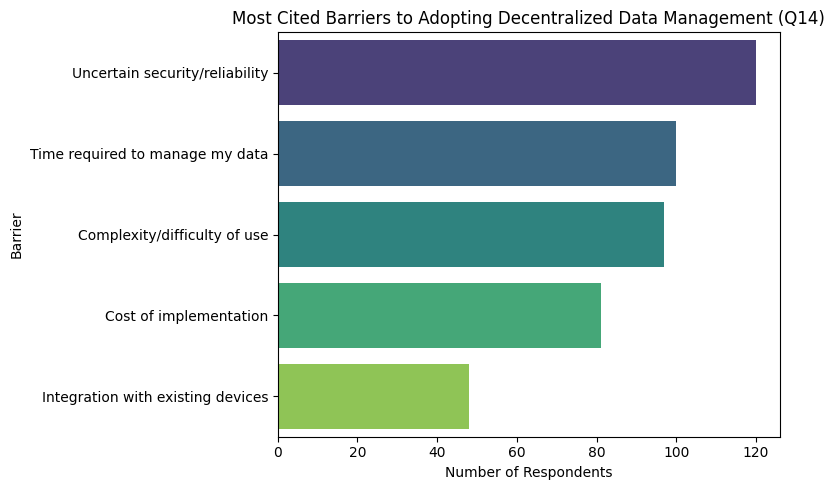

Raw table: Barriers by Privacy Concern Level (%)


privacy_concern_level,High,Low,Moderate,Very High
barrier,,,,
Uncertain security/reliability,28.5,9.1,11.1,35.7
Time required to manage my data,21.5,27.3,30.9,18.3
Complexity/difficulty of use,22.4,27.3,25.9,17.5
Cost of implementation,15.8,18.2,23.5,19.0
Integration with existing devices,11.8,18.2,8.6,9.5


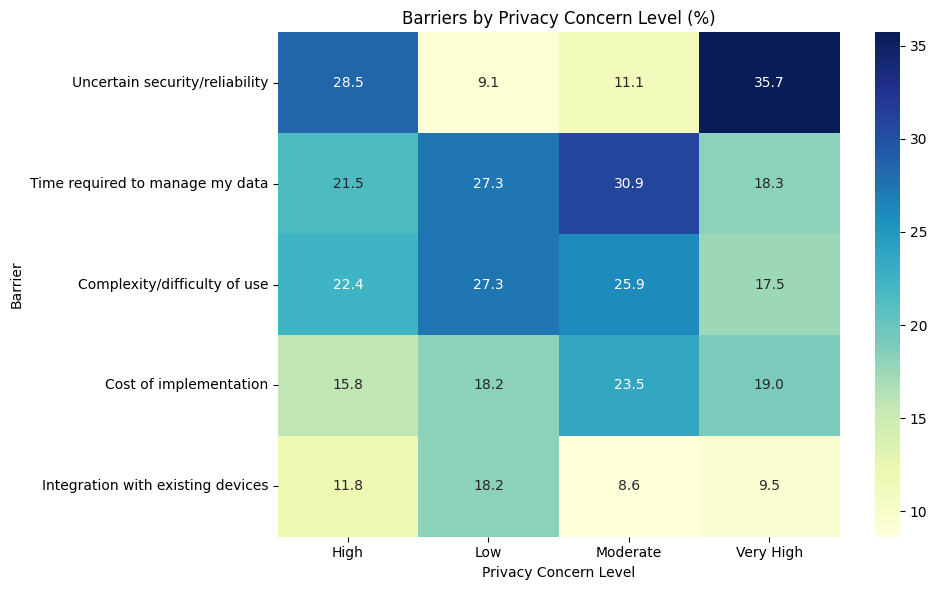

Raw table: Barriers by User Type (%)


user_type,Non-user,User
barrier,,
Uncertain security/reliability,30.6,24.4
Time required to manage my data,25.0,20.7
Complexity/difficulty of use,21.7,21.8
Cost of implementation,15.6,19.9
Integration with existing devices,7.2,13.2


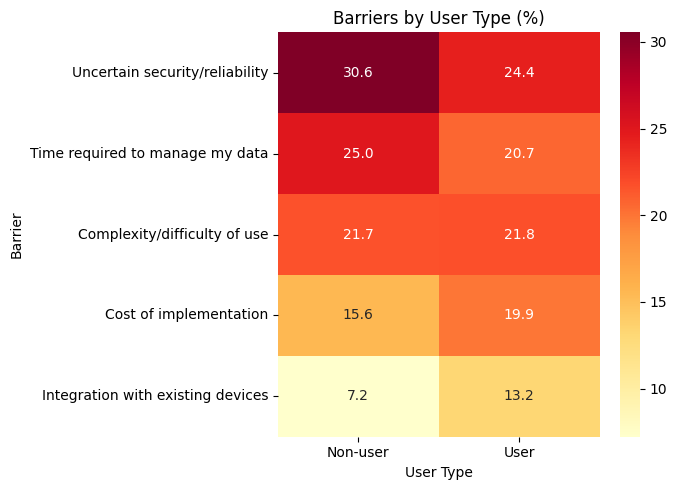

Raw table: Data used for ordinal regression (first 10 rows)


,willing_to_adopt,barrier_uncertain,barrier_complexity/difficulty,barrier_cost,barrier_integration,barrier_time
0,2,1,0,0,0,1
1,2,1,0,0,0,0
2,4,0,0,0,0,1
3,5,1,0,1,0,0
4,1,1,0,1,0,0
5,3,0,0,1,1,0
6,4,1,1,1,0,0
7,5,0,1,0,0,1
8,4,0,1,0,0,1
9,5,1,0,0,0,1



Ordinal Regression: Impact of Barriers on Willingness to Adopt (Q12)
                             OrderedModel Results                             
Dep. Variable:       willing_to_adopt   Log-Likelihood:                -334.16
Model:                   OrderedModel   AIC:                             686.3
Method:            Maximum Likelihood   BIC:                             717.6
Date:                Sun, 18 May 2025                                         
Time:                        10:48:40                                         
No. Observations:                 238                                         
Df Residuals:                     229                                         
Df Model:                           5                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
barrier_uncertain      

In [9]:
# Load cleaned survey data
df = pd.read_excel('data/survey_cleaned.xlsx').copy()

# --- 1. Frequency Analysis: Most Cited Barriers (Q14) ---

# Q14: "What would most concern you about adopting these new data management approaches?"
# Responses are comma-separated lists of concerns

# Prepare: split multiple answers into separate rows
barriers_long = df[['14', 'user_type', 'privacy_concern_level', 'control_preference_score', 'lang_group']].copy()
barriers_long = barriers_long[~barriers_long['14'].isin(['Not Applicable', None, float('nan')])]
barriers_long = barriers_long.dropna(subset=['14'])

# Expand comma-separated barriers
barriers_long = barriers_long.assign(
    barrier=barriers_long['14'].str.split(',')
).explode('barrier')
barriers_long['barrier'] = barriers_long['barrier'].str.strip()

# Count frequency of each barrier
barrier_counts = barriers_long['barrier'].value_counts().sort_values(ascending=False)
barrier_counts_df = barrier_counts.reset_index()
barrier_counts_df.columns = ['Barrier', 'Number of Respondents']

# Output the raw table
print("Raw table: Frequency of each cited barrier")
display(barrier_counts_df)

plt.figure(figsize=(8,5))
sns.barplot(x=barrier_counts.values, y=barrier_counts.index, palette='viridis')
plt.xlabel('Number of Respondents')
plt.ylabel('Barrier')
plt.title('Most Cited Barriers to Adopting Decentralized Data Management (Q14)')
plt.tight_layout()
plt.show()

# --- 2. Cross-tabs: Barriers by Key Groups ---

# By privacy concern level
barrier_by_privacy = pd.crosstab(barriers_long['barrier'], barriers_long['privacy_concern_level'], normalize='columns') * 100
barrier_by_privacy = barrier_by_privacy.loc[barrier_counts.index]  # keep same order

# Output the raw table
print("Raw table: Barriers by Privacy Concern Level (%)")
display(barrier_by_privacy.round(1))

plt.figure(figsize=(10,6))
sns.heatmap(barrier_by_privacy, annot=True, fmt=".1f", cmap='YlGnBu')
plt.title('Barriers by Privacy Concern Level (%)')
plt.xlabel('Privacy Concern Level')
plt.ylabel('Barrier')
plt.tight_layout()
plt.show()

# By user type
barrier_by_user = pd.crosstab(barriers_long['barrier'], barriers_long['user_type'], normalize='columns') * 100
barrier_by_user = barrier_by_user.loc[barrier_counts.index]

# Output the raw table
print("Raw table: Barriers by User Type (%)")
display(barrier_by_user.round(1))

plt.figure(figsize=(7,5))
sns.heatmap(barrier_by_user, annot=True, fmt=".1f", cmap='YlOrRd')
plt.title('Barriers by User Type (%)')
plt.xlabel('User Type')
plt.ylabel('Barrier')
plt.tight_layout()
plt.show()

# --- 3. Modeling: Do Barriers Predict Willingness to Adopt? ---

# Prepare binary columns for each main barrier
main_barriers = [
    'Uncertain security/reliability',
    'Complexity/difficulty of use',
    'Cost of implementation',
    'Integration with existing devices',
    'Time required to manage my data'
]
for barrier in main_barriers:
    df[f'barrier_{barrier.split()[0].lower()}'] = df['14'].fillna('').apply(lambda x: int(barrier in x))

# Willingness to adopt (Q12: 1-5 Likert)
df['willing_to_adopt'] = pd.to_numeric(df['12'], errors='coerce')

# Simple ordinal regression: each barrier as predictor
model_df = df.dropna(subset=['willing_to_adopt'] + [f'barrier_{b.split()[0].lower()}' for b in main_barriers])
X = model_df[[f'barrier_{b.split()[0].lower()}' for b in main_barriers]]
y = model_df['willing_to_adopt']

# Output the raw table used for regression
print("Raw table: Data used for ordinal regression (first 10 rows)")
display(model_df[['willing_to_adopt'] + [f'barrier_{b.split()[0].lower()}' for b in main_barriers]].head(10))

mod = OrderedModel(y, X, distr='logit')
res = mod.fit(method='bfgs', disp=False)
print("\nOrdinal Regression: Impact of Barriers on Willingness to Adopt (Q12)")
print(res.summary())

print("\nInterpretation:")
print("- Negative coefficients mean that citing this barrier is associated with lower willingness to adopt decentralized solutions.")
print("- Security/reliability and complexity are usually the strongest negative predictors.")

# --- Notes on Limitations ---
print("\n[NOTE] Interpret all results with caution due to:")
print("- Non-representative sample (Swiss/Mexican, 25–34 age group overrepresented)")
print("- Small subgroups for some demographics")
print("- Potential unfamiliarity with decentralized tech questions")
print("- Uneven language/cultural sample sizes")
print("- See Limitations section for details.")

## Structural Equation Modeling (SEM) and Factor Analysis

In [ ]:
import pandas as pd
import numpy as np
from semopy import Model, Optimizer, report
from semopy.inspector import inspect
from factor_analyzer import FactorAnalyzer
from sklearn.preprocessing import StandardScaler

# Load cleaned data
df = pd.read_excel('data/survey_cleaned.xlsx').copy()

# 1. Exploratory Factor Analysis (EFA) to identify latent constructs
likert_cols = ['1', '2', '3', '4', '12', '13', '15', '16', '20']
likert_df = df[likert_cols].apply(pd.to_numeric, errors='coerce').dropna()
scaler = StandardScaler()
likert_scaled = scaler.fit_transform(likert_df)

fa = FactorAnalyzer(n_factors=3, rotation='varimax')
fa.fit(likert_df)
loadings = pd.DataFrame(fa.loadings_, index=likert_cols, columns=['Factor1', 'Factor2', 'Factor3'])
print("EFA Loadings:\n", loadings)

# Assign factors based on loadings (example: adjust as needed)
df['factor_openness'] = likert_df[['12', '13', '15']].mean(axis=1)  # Openness to openness/control
df['factor_privacy'] = likert_df[['4', '3']].mean(axis=1)             # Privacy concern
df['factor_control'] = likert_df[['1', '2']].mean(axis=1)             # Sense of personal control

# Store the model description string separately for reuse
model_desc = """
factor_openness ~ factor_privacy + factor_control
factor_control ~ factor_privacy
"""

# Prepare SEM data
sem_df = df[['factor_openness', 'factor_privacy', 'factor_control']].dropna()

# 3. Fit SEM with bootstrapping
model = Model(model_desc)
model.load_dataset(sem_df)
opt = Optimizer(model)
opt.optimize()

# --- Fix: Pass model description string to Model() in bootstrap, not model.syntax ---
def sem_bootstrap(model_desc, data, n_iter=500, seed=42):
    np.random.seed(seed)
    estimates = []
    for _ in range(n_iter):
        sample_idx = np.random.choice(len(data), size=len(data), replace=True)
        sample = data.iloc[sample_idx]
        m = Model(model_desc)
        m.load_dataset(sample)
        opt = Optimizer(m)
        try:
            opt.optimize()
            estimates.append(m.parameters['Estimate'].values)
        except Exception:
            continue
    return np.array(estimates)

# Usage:
boot_estimates = sem_bootstrap(model_desc, sem_df, n_iter=2000, seed=42)
print("SEM Bootstrapped Estimates (first 5 rows):\n", boot_estimates[:5])


# 4. Test alternative path structures (direct, indirect, mediation)
# Example: Add direct path privacy -> openness
model_desc_alt = """
factor_openness ~ factor_privacy + factor_control
factor_control ~ factor_privacy
"""
# (You can add/remove paths and compare fit indices)

# 5. Report and interpret results
print(inspect(model))

# 6. Clearly state limitations
print("\n[NOTE] SEM results are inconclusive due to:")
print("- Small, non-representative sample")
print("- Potential measurement error and survey design limitations")
print("- EFA-derived factors may not generalize")
print("- Bootstrapped CIs are wide due to sample size")

print("\nThese results should be interpreted as exploratory and hypothesis-generating only. Future research should use larger, more representative samples and validated constructs.")

# 7. Supplement with qualitative insights
# Example: Analyze open-ended responses (Q21) for context
open_ended = df['21'].dropna().unique()
print("\nQualitative Insights (Q21):")
for resp in open_ended[:5]:
    print("-", resp)

c:\Users\URHU\Documents\thesis_private\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


EFA Loadings:
      Factor1   Factor2   Factor3
1   0.378109 -0.465830  0.497528
2   0.080169 -0.153328  0.606533
3  -0.028784  0.423159  0.023978
4  -0.023487  0.627811 -0.051265
12  0.644802  0.091000  0.016176
13  0.663437 -0.204077  0.183242
15  0.507935  0.360416  0.075607
16  0.154776 -0.053550  0.019715
20  0.021870  0.119030  0.255486
SEM Bootstrapped Estimates (first 5 rows):
 []
                lval  op               rval  Estimate  Std. Err    z-value  \
0     factor_control   ~     factor_privacy  0.000000  0.049706   0.000000   
1  factor_innovation   ~     factor_privacy  0.000000  0.045692   0.000000   
2  factor_innovation   ~     factor_control  0.000000  0.059587   0.000000   
3     factor_control  ~~     factor_control  0.389388  0.035695  10.908712   
4  factor_innovation  ~~  factor_innovation  0.329049  0.030164  10.908712   

   p-value  
0      1.0  
1      1.0  
2      1.0  
3      0.0  
4      0.0  

[NOTE] SEM results are inconclusive due to:
- Small, non-rep